In [1]:
# import whatever needed 

import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import camb
# import classy module
from classy import Class
import astropy.units as u
import astropy.constants as cu
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import quad
from scipy import integrate


import hmvec.ksz as ksz
import hmvec.hod as hod
import hmvec.hmvec as hm

from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
import getdist
from getdist import plots, MCSamples
import IPython
# The plotting scripts also let you plot Gaussian (or Gaussian mixture) contours 
from getdist.gaussian_mixtures import GaussianND

print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))
# matplotlib 2 may not work very well without usetex on, can uncomment
# plt.rcParams['text.usetex']=True

from matplotlib import pyplot as plt
palette=['#165783', '#cd9b00', '#ad321f', '#3c651e', '#5f685f','#377eb8', '#ff7f00', '#4daf4a',
           '#f781bf', '#a65628', '#984ea3',
           '#999999', '#e41a1c', '#dede00']
# palette =  ['#377eb8', '#ff7f00', '#4daf4a',
#            '#f781bf', '#a65628', '#984ea3',
#            '#999999', '#e41a1c', '#dede00']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [6, 5]
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['axes.linewidth'] = 1.






plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"})

GetDist Version: 1.4.3, Matplotlib version: 3.7.1


In [2]:
cosmo_params = dict(
         H0=67.67, cosmomc_theta=None,
         ombh2=0.022, omch2=0.12, omk=0.0,
         mnu=0.06, nnu=3.046,
         TCMB=2.7255, tau=0.06, w=-1.0, wa=0., cs2=1.0,
         dark_energy_model='ppf',As=2.2e-09,
         # !!! Planck 2018 eq. 16/17/18 arXiv:1807.06211
         ns=0.965, nrun=0.0, nrunrun=0.0,
         r=0.0, nt=None, ntrun=0.0,
         pivot_scalar=0.05, pivot_tensor=0.05,
         parameterization=2,halofit_version='mead')


# Functions

In [3]:

#%% Calculate the matter power spectrum with the scale-dependent growth rate using CAMB
def Pmm_k(Z, k, cosmo_params):
    nz = 101
    zcosmo = np.linspace(0.,15.,nz)
    cosmo_1 = cosmo_params.copy()
    camb_pars = camb.set_params(**cosmo_1)
    camb_pars.set_matter_power(redshifts=list(zcosmo))
    cosmo = camb.get_results(camb_pars)
    interp_Pmm_linear = camb.get_matter_power_interpolator(camb_pars, zmin=0, zmax=zcosmo[-1], nz_step=150,zs=None, kmax=max(k), nonlinear=False,var1=camb.model.Transfer_tot, var2=camb.model.Transfer_tot, hubble_units=False, 
    k_hunit=False, return_z_k=False, k_per_logint=None, log_interp=False,  extrap_kmax=False).P # Mpc^3

    return interp_Pmm_linear(Z,k)

#%% Calculate the scale-dependent growth rate as derivative of the matter power spectrum
def fgrowth_k(Z, k, cosmo_params):
    
    dz = 0.01
    Pmm_p = Pmm_k(Z+dz,k,cosmo_params)
    Pmm = Pmm_k(Z,k,cosmo_params)
    d_lnPmm_dz = (Pmm_p - Pmm)/dz/Pmm

    f_k = -0.5*(1+Z)*d_lnPmm_dz
    return f_k

#%% Calculate the velocity reconstructed noise N_vv
def Rec_noise(Z, cosmo_params, k_large, mu_L, bg, ng, survey, Delta_T):
    if survey == 'VRO10':
        sigma_phot = lambda z: 0.03*(1+z)
    elif survey == 'DESI':
        sigma_phot = lambda z: 0*(1+z)
    else:
        raise KeyError(f"{survey} is not a valid galaxy survey for this code!")
    nkS = 300
    nz = 101
    nmu = len(mu_L)
    nkL = len(k_large)
    #k_small = np.linspace(1,5,nkS) # Mpc^-1
    k_small = np.logspace(-1,np.log10(5),nkS) # Mpc^-1
    mu_S = -(k_large[np.newaxis,:,np.newaxis]*np.ones((nkS,nkL,nmu))/k_small[:,np.newaxis,np.newaxis]*np.ones((nkS,nkL,nmu))) * mu_L[np.newaxis,np.newaxis,:]*np.ones((nkS,nkL,nmu))
    Mh = np.logspace(8,15,200) # Msun
    zcosmo = np.linspace(0.,15.,nz)
    cosmo_1 = cosmo_params.copy()
    camb_pars = camb.set_params(**cosmo_1)
    camb_pars.set_matter_power(redshifts=list(zcosmo))
    cosmo = camb.get_results(camb_pars)
    H = lambda z: cosmo.hubble_parameter(z)/(cu.c.to(u.km/u.s)).value # 1/Mpc    
    a = lambda z: 1/(1+z)
    T_CMB = ((camb_pars.TCMB* u.K).to(u.uK)).value # muK
    chi_star = lambda z: cosmo.comoving_radial_distance(z) # Mpc
    ell = lambda z,kS: chi_star(z) * kS
    gal_profile = hod.Leauthaud12_HOD
    elec_profile = 'electron'
    b1=None # linear biases, we add from the outside 
    b2=None # linear biases, we add from the outside 
    m_integrand=False # if False, the output is Pk integrated in Mh, otherwise you get the integrand in dMh
    rsd=False # RSD, we add from the outside
    fog=False # FoG, we add from the outside
    hcos_ksmall = hm.HaloModel([Z],k_small,Mh,params=cosmo_params)
    hcos_ksmall.add_hod("g",family=gal_profile,ngal=ng+np.asarray([Z])*0.,corr="max")
    hcos_ksmall.add_battaglia_profile("electron",family="AGN",xmax=20,nxs=5000)
    pgg_1h_ksmall = hcos_ksmall.get_power_1halo(name='g', name2=None, m_integrand=m_integrand,fog=fog)[0] # Mpc^3
    pgg_2h_ksmall = hcos_ksmall.get_power_2halo(name='g',name2=None,b1_in=b1,b2_in=b2,m_integrand=m_integrand,rsd=rsd,fog=fog)[0] # Mpc^3
    pge_1h_ksmall = hcos_ksmall.get_power_1halo(name='g', name2 = elec_profile, m_integrand=m_integrand,fog=fog)[0] # Mpc^3
    pge_2h_ksmall = hcos_ksmall.get_power_2halo(name='g',name2=elec_profile,b1_in=b1,b2_in=b2,m_integrand=m_integrand,rsd=rsd,fog=fog)[0] # Mpc^3
    fgrowth = fgrowth_k(Z,k_small,cosmo_params)
    resize_ksmall = k_small[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_fgrowth = fgrowth[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_pgg = (pgg_1h_ksmall+pgg_2h_ksmall)[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_ell_ksmall = chi_star(Z) * k_small[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_pge = (pge_1h_ksmall+pge_2h_ksmall)[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    P_gg_ksmall = (1 + mu_S**2*resize_fgrowth/bg)**2 * (resize_pgg) # Mpc^3
    W_phot_ksmall = np.exp(-mu_S**2*resize_ksmall**2*sigma_phot(Z)**2/2/H(Z)**2)
    P_gg_obs_ksmall = W_phot_ksmall**2 * P_gg_ksmall + 1/ng # Mpc^3
    P_ge_ksmall = W_phot_ksmall*(1 + mu_S**2*resize_fgrowth/bg) * (resize_pge) 
#     TT_total_for_S4 = np.loadtxt('./tt_total_power_s4_new_12.txt') # From Selim
#     lvec = TT_total_for_S4[:,0]
#     Cl_TT = interp1d(lvec,TT_total_for_S4[:,1],bounds_error=False,fill_value=0.) # muK^2
#     Cltot_noise = Cl_TT(resize_ell_ksmall)
    s = Delta_T *u.arcmin.to(u.radian)
    fwhm = 1.4 *u.arcmin.to(u.radian)
    N_ell=CMB_noise(resize_ell_ksmall, s, fwhm)
    Cltot_noise=Cl_tot(resize_ell_ksmall)+N_ell
    # kSZ
    xe = 1 # ionization fraction
    gasfrac = 0.9 # fraction of baryons in gas form, use default
    Yp = camb_pars.YHe # primordial He abundance
    ne0 = ksz.ne0_shaw(ombh2=cosmo_params['ombh2'],gasfrac=gasfrac,Yp=Yp) # m^-3 # mean free electron density at z = 0
    Kstar = lambda z: -ksz.ksz_radial_function(z, camb_pars.ombh2, Yp) # muK / Mpc
    itgrnd = resize_ksmall * (P_ge_ksmall**2 / P_gg_obs_ksmall) / Cltot_noise # Mpc^-1 muK^-2
    mask = np.isinf(itgrnd)
    itgrnd[mask] = 0.
    integral = np.trapz(itgrnd, x=k_small, axis=0) # Mpc / muK^2
    Nvv_par = (chi_star(Z)/ Kstar(Z))**2 * 2*np.pi / integral # Mpc^3
    N_vv = (mu_L[np.newaxis,:]*np.ones((nkL,nmu)))**-2 * Nvv_par
    
    T_CMB=2.7260 #K
    T_CMB_uK=T_CMB*1e6 #uK
    # get potential Pk (non linearities included) - CAMB results is already multiplied by k^4
    interp_Pphiphi = camb.get_matter_power_interpolator(camb_pars, zmin=0, zmax=zcosmo[-1], nz_step=150, zs=None, kmax=max(k_small), nonlinear=True,var1=camb.model.Transfer_Weyl, var2=camb.model.Transfer_Weyl, hubble_units=False, 
                                                        k_hunit=False, return_z_k=False, k_per_logint=None, log_interp=False,  extrap_kmax=True).P  # Mpc^3
    omegam = (camb_pars.ombh2 + camb_pars.omch2 + camb_pars.omnuh2) / (camb_pars.H0 / 100) ** 2
    rhoM0 = 3*omegam*H(0.)**2 # Mpc^-2
    # potential Pk , change of units
    use_Pphiphi_ksmall = (interp_Pphiphi(Z,k_small)/k_small**4)[:,np.newaxis,np.newaxis]*np.ones((nkS,nkL,nmu)) # Mpc^3
    noise_pot = ((1+Z)*rhoM0/2)**2/((resize_ksmall)**4 * bg**2*ng * W_phot_ksmall**2)  # Mpc^3
    # observed potential
    use_Ppot_ob = use_Pphiphi_ksmall + noise_pot # Mpc^3
    itgrnd_ML = (resize_ksmall)**3 * (use_Pphiphi_ksmall**2 / use_Ppot_ob) / Cltot_noise # muK^-2
    mask = np.isinf(itgrnd_ML)
    itgrnd_ML[mask] = 0
    integral_ML = np.trapz(itgrnd_ML, x=k_small, axis=0) # 1 / Mpc / muK^2
    new_resize_muL = mu_L[np.newaxis,:]*np.ones((nkL,nmu))
    new_resize_kL = k_large[:,np.newaxis]*np.ones((nkL,nmu))
    # noise on the transverse velocity potential (T_CMB factor to cancel the uK units from Cls)
    N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
    Nvv_perp = (new_resize_kL)**2 * N_perp_Vpot # v = grad pot so in Fourier you get v = k*pot
    N_vv_ML = (np.sqrt(1-new_resize_muL**2))**-2 * Nvv_perp # Mpc^3

    return Nvv_par, Nvv_perp
    
    

#%% Calculate power spectra
def get_powers(Z, cosmo_params, bias_params, k_large, mu, survey):
    nmu = len(mu)
    nkL = len(k_large)
    nz = 101
    zcosmo = np.linspace(0.,15.,nz)
    cosmo_1 = cosmo_params.copy()
    camb_pars = camb.set_params(**cosmo_1)
    camb_pars.set_matter_power(redshifts=list(zcosmo))
    cosmo = camb.get_results(camb_pars)
    H = lambda z: cosmo.hubble_parameter(z)/(cu.c.to(u.km/u.s)).value # 1/Mpc
    fgrowth = fgrowth_k(Z,k_large,cosmo_params)
    resize_klarge = k_large[:,np.newaxis]*np.ones((nkL,nmu))
    resize_fgrowth = fgrowth[:,np.newaxis]*np.ones((nkL,nmu))
    resize_mu = mu[np.newaxis,:]*np.ones((nkL,nmu))
    resize_Pmm = Pmm_k(Z, k_large, cosmo_params)[:,np.newaxis]*np.ones((nkL,nmu))
    RSD = bias_params['brsd']*resize_fgrowth*resize_mu**2
    
    if survey == 'VRO10':
        bg1 = bias_params['m']*Z+bias_params['q'] # linear fit for the linear bias term
    elif survey == 'DESI':
        bg1 = bias_params['bg'] # independent linear bias parameter for each bin
    bg2 = bg1+bias_params['b2']*resize_klarge**2

    a = lambda z: 1/(1+z)
    b_v = resize_fgrowth * a(Z) * H(Z) / resize_klarge
    b_vpar = bias_params['b_par'] * b_v * resize_mu
    b_vperp = bias_params['b_perp'] * b_v * np.sqrt(1-resize_mu**2)
    
    Pgg = (bg2 + RSD)**2 * resize_Pmm
    Pvv_par = b_vpar**2 * resize_Pmm
    Pvv_perp = b_vperp**2 * resize_Pmm
    Pgv_par = b_vpar * (bg2 + RSD) * resize_Pmm
    Pgv_perp = b_vperp * (bg2 + RSD) * resize_Pmm
    Pvv_par_perp = b_vpar * b_vperp * resize_Pmm
    
    return Pgg, Pgv_par, Pgv_perp, Pvv_par, Pvv_perp, Pvv_par_perp


#%% Calculate noise power spectra
def get_noises(Z, cosmo_params, k_large, mu_L, bg, ng, survey, Delta_T):
    nmu = len(mu_L)
    nkL = len(k_large)
    if survey == 'VRO10':
        sigma_phot = lambda z: 0.03*(1+z)
    elif survey == 'DESI':
        sigma_phot = lambda z: 0*(1+z)
    else:
        raise KeyError(f"{survey} is not a valid galaxy survey for this code!")
    nz = 101
    zcosmo = np.linspace(0.,15.,nz)
    cosmo_1 = cosmo_params.copy()
    camb_pars = camb.set_params(**cosmo_1)
    camb_pars.set_matter_power(redshifts=list(zcosmo))
    cosmo = camb.get_results(camb_pars)
    H = lambda z: cosmo.hubble_parameter(z)/(cu.c.to(u.km/u.s)).value # 1/Mpc
    a = lambda z: 1/(1+z)
    
    resize_muL = mu_L[np.newaxis,:]*np.ones((nkL,nmu))
    resize_klarge = k_large[:,np.newaxis]*np.ones((nkL,nmu))
    W_phot_klarge = np.exp(-resize_muL**2*resize_klarge**2*sigma_phot(Z)**2/2/H(Z)**2)
    Ngg = 1/ W_phot_klarge**2 / ng
    
    Nvv_par, Nvv_perp = Rec_noise(Z, cosmo_params, k_large, mu_L, bg, ng, survey, Delta_T)
    
    #N_vv = resize_muL**-2. * Nvv_par
    #Nmm = k_large**2/(fgrowth*a(Z)*H(Z))**2 * N_vv[:,-1]
    
    return Ngg, Nvv_par, Nvv_perp#, Nmm



#%% Calculate derivatives of power spectra
def derivs(Z, cosmo0, bias0, free_params, deltas, k_large, mu, survey):
    nmu = len(mu)
    nk = len(k_large)
    d_Pgg = np.zeros((len(free_params), nk, nmu))
    d_Pgv_par = np.zeros((len(free_params), nk, nmu))
    d_Pgv_perp = np.zeros((len(free_params), nk, nmu))
    d_Pvv_par = np.zeros((len(free_params), nk, nmu))
    d_Pvv_perp = np.zeros((len(free_params), nk, nmu))
    d_Pvv_par_perp = np.zeros((len(free_params), nk, nmu))
    param_values = np.zeros(len(free_params))
    for free_param_ind, free_param in enumerate(free_params):
        if free_param in cosmo0:
            param_values[free_param_ind] = cosmo0[free_param]
        elif free_param in bias0:
            param_values[free_param_ind] = bias0[free_param]
        else:
            raise KeyError(f"{free_param} is not a valid parameters for this code!")
          
    for i, param in enumerate(free_params):
        delta = deltas[i]
        param_value = param_values[i]
        if param in cosmo0:
            cosmo_p = cosmo0.copy()
            cosmo_n = cosmo0.copy()
            if not cosmo0[param] == 0.:
                cosmo_p[param] = cosmo0[param]*(1.+delta)
                cosmo_n[param] = cosmo0[param]*(1.-delta)
            else:
                cosmo_p[param] = delta
                cosmo_n[param] = -delta
            print('\n\nNow simulating for (1+delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            Pgg_p, Pgv_par_p, Pgv_perp_p, Pvv_par_p, Pvv_perp_p, Pvv_par_perp_p = get_powers(Z, cosmo_p, bias0, k_large, mu_L, survey)
            print('\n\nNow simulating for (1-delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            Pgg_n, Pgv_par_n, Pgv_perp_n, Pvv_par_n, Pvv_perp_n, Pvv_par_perp_n = get_powers(Z, cosmo_n, bias0, k_large, mu_L, survey)
        else:
            bias_p = bias0.copy()
            bias_n = bias0.copy()
            if not bias0[param] == 0.:
                bias_p[param] = bias0[param]*(1.+delta)
                bias_n[param] = bias0[param]*(1.-delta)
            else:
                bias_p[param] = delta
                bias_n[param] = -delta
            print('\n\nNow simulating for (1+delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            Pgg_p, Pgv_par_p, Pgv_perp_p, Pvv_par_p, Pvv_perp_p, Pvv_par_perp_p = get_powers(Z, cosmo0, bias_p, k_large, mu_L, survey)
            print('\n\nNow simulating for (1-delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            Pgg_n, Pgv_par_n, Pgv_perp_n, Pvv_par_n, Pvv_perp_n, Pvv_par_perp_n = get_powers(Z, cosmo0, bias_n, k_large, mu_L, survey)
        if not param_value == 0.:
            d_Pgg[i] = (Pgg_p - Pgg_n)/(2*param_value*delta)
            d_Pgv_par[i] = (Pgv_par_p - Pgv_par_n)/(2*param_value*delta)
            d_Pgv_perp[i] = (Pgv_perp_p - Pgv_perp_n)/(2*param_value*delta)
            d_Pvv_par[i] = (Pvv_par_p - Pvv_par_n)/(2*param_value*delta)
            d_Pvv_perp[i] = (Pvv_perp_p - Pvv_perp_n)/(2*param_value*delta)
            d_Pvv_par_perp[i] = (Pvv_par_perp_p - Pvv_par_perp_n)/(2*param_value*delta)
        else:
            d_Pgg[i] = (Pgg_p - Pgg_n)/(2*delta)
            d_Pgv_par[i] = (Pgv_par_p - Pgv_par_n)/(2*delta)
            d_Pgv_perp[i] = (Pgv_perp_p - Pgv_perp_n)/(2*delta)
            d_Pvv_par[i] = (Pvv_par_p - Pvv_par_n)/(2*delta)
            d_Pvv_perp[i] = (Pvv_perp_p - Pvv_perp_n)/(2*delta)
            d_Pvv_par_perp[i] = (Pvv_par_perp_p - Pvv_par_perp_n)/(2*delta)
    return d_Pgg, d_Pgv_par, d_Pgv_perp, d_Pvv_par, d_Pvv_perp, d_Pvv_par_perp
    
    
    
def Fisher_mat(Z, cosmo0, bias0, free_params, deltas, k, mu, ng, survey, Delta_T, vol):
    k_grid=np.meshgrid(mu, k)[1]
    if survey == 'VRO10':
        bg = bias0['m']*Z+bias0['q']
    elif survey == 'DESI':
        bg = bias0['bg']
    else:
        raise KeyError(f"{survey} is not a valid galaxy survey for this code!")
    Pgg, Pgv_par, Pgv_perp, Pvv_par, Pvv_perp, Pvv_par_perp = get_powers(Z, cosmo0, bias0, k, mu, survey)
    Ngg, Nvv_par, Nvv_perp = get_noises(Z, cosmo0, k, mu, bg, ng, survey, Delta_T)
    d_Pgg, d_Pgv_par, d_Pgv_perp, d_Pvv_par, d_Pvv_perp, d_Pvv_par_perp = derivs(Z, cosmo0, bias0, free_params, deltas, k, mu, survey)
    S=np.zeros((len(k),len(mu),4,4))
    S[:,:,0,0]=Pvv_par; S[:,:,0,1]=Pvv_par_perp; S[:,:,1,0]=Pvv_par_perp; S[:,:,1,1]=Pvv_perp;
    S[:,:,0,3]=Pgv_par; S[:,:,3,0]=Pgv_par; S[:,:,1,3]=Pgv_perp; S[:,:,3,1]=Pgv_perp; S[:,:,3,3]=Pgg;
    N=np.zeros((len(k),len(mu),4,4))
    N[:,:,0,0]=Nvv_par; N[:,:,1,1]=Nvv_perp; N[:,:,2,2]=Nvv_perp; N[:,:,3,3]=Ngg;
    C = S + N
    C_inv = np.linalg.inv(C)
    F_gg=np.zeros((len(free_params), len(free_params)))
    F_gv=np.zeros((len(free_params), len(free_params)))
    F_vv=np.zeros((len(free_params), len(free_params)))
    for a in range(len(free_params)):
        d_Pgg_a=d_Pgg[a,:,:]; d_Pgv_par_a=d_Pgv_par[a,:,:]; d_Pgv_perp_a=d_Pgv_perp[a,:,:]
        d_Pvv_par_a=d_Pvv_par[a,:,:]; d_Pvv_perp_a=d_Pvv_perp[a,:,:]; d_Pvv_par_perp_a=d_Pvv_par_perp[a,:,:]
        for b in range(len(free_params)):
            d_Pgg_b=d_Pgg[b,:,:]; d_Pgv_par_b=d_Pgv_par[b,:,:]; d_Pgv_perp_b=d_Pgv_perp[b,:,:]
            d_Pvv_par_b=d_Pvv_par[b,:,:]; d_Pvv_perp_b=d_Pvv_perp[b,:,:]; d_Pvv_par_perp_b=d_Pvv_par_perp[b,:,:]
            dC_a=np.zeros((len(k),len(mu),4,4))
            dC_a[:,:,0,0]=d_Pvv_par_a; dC_a[:,:,0,1]=d_Pvv_par_perp_a; dC_a[:,:,1,0]=d_Pvv_par_perp_a; dC_a[:,:,1,1]=d_Pvv_perp_a;
            dC_a[:,:,0,3]=d_Pgv_par_a; dC_a[:,:,3,0]=d_Pgv_par_a; dC_a[:,:,1,3]=d_Pgv_perp_a; dC_a[:,:,3,1]=d_Pgv_perp_a; dC_a[:,:,3,3]=d_Pgg_a;
            dC_b=np.zeros((len(k),len(mu),4,4))
            dC_b[:,:,0,0]=d_Pvv_par_b; dC_b[:,:,0,1]=d_Pvv_par_perp_b; dC_b[:,:,1,0]=d_Pvv_par_perp_b; dC_b[:,:,1,1]=d_Pvv_perp_b;
            dC_b[:,:,0,3]=d_Pgv_par_b; dC_b[:,:,3,0]=d_Pgv_par_b; dC_b[:,:,1,3]=d_Pgv_perp_b; dC_b[:,:,3,1]=d_Pgv_perp_b; dC_b[:,:,3,3]=d_Pgg_b;
    
               
            int_F_gv=vol.value*((k_grid**2)/(8.*(np.pi**2)))*(np.trace(np.matmul(dC_a, np.matmul(C_inv, np.matmul(dC_b, C_inv))), axis1=2, axis2=3))
            F_gv[a,b]=integrate.simps(integrate.simps(int_F_gv, mu, axis=1), k)
            F_gv[b,a]=F_gv[a,b]
            
            int_F_gg=vol.value*((k_grid**2)/(8.*(np.pi**2)))*(d_Pgg_a*d_Pgg_b)*((1./(Pgg+Ngg))**2)
            F_gg[a,b]=integrate.simps(integrate.simps(int_F_gg, mu, axis=1), k)
            F_gg[b,a]=F_gg[a,b]
            
    
    return F_gg, F_gv


#%% Calculate the covariance matrix, including fixing
def covariance_mat(F,
                   free_params,
                   fixed_params,
                   priors):
    F1 = np.copy(F)
    # Add priors to the Fisher matrix
    sigma_priors = np.inf*np.ones(len(free_params))
    for prior in priors:
        sigma_priors[free_params.index(prior)] = priors[prior]
    F1 += np.diag(1./sigma_priors**2.)
    # Find the fixed parameters indices within the free parameters list
    fixed_inds = []
    if len(fixed_params)>0:
        for i in range(len(fixed_params)):
            for j in range(len(free_params)):
                if fixed_params[i] == free_params[j]:
                    fixed_inds.append(j)
    # Omit the fixed parameters from the Fisher matrix
    F1 = np.delete(F1,fixed_inds,0)
    F1 = np.delete(F1,fixed_inds,1)
    # Keep only the remaining free parameters (that weren't fixed)
    cov_inds = [ind for ind in np.arange(len(free_params)) if ind not in fixed_inds]
    cov_params = [free_params[i] for i in cov_inds]
    # Calculate the covariance matrix
    cov_mat = np.linalg.inv(F1)
    # Return covariance matrix and its corresponding parameters
    return cov_mat, cov_params


#%% Print the 1-sigmas of the parameters
def print_1_sigmas(cov_mat,
                   cov_params):
    print('\n')
    sigmas = {}
    for ind, param in enumerate(cov_params):
        sigmas[param] = np.sqrt(cov_mat[ind,ind])
        print('1-sigma of '+param+f' is {sigmas[param]}')
    
    
#%% Define latex names for Fisher plot
def latex_gen(parameters_list):
    names_list = []
    for element in parameters_list:
        if element == 'h':
            names_list.append('h')
        elif element == 'ombh2' :
            names_list.append('\Omega_b h^2')
        elif element == 'omch2':
            names_list.append('\Omega_c h^2')
        elif element == 'As':
            names_list.append('A_s')
        elif element == 'ns':
            names_list.append('n_s')
        elif element == 'tau':
            names_list.append('\tau')
        elif element == 'H0':
            names_list.append('H_0')
        elif element == 'bv':
            names_list.append('b_v')
        elif element == 'mnu':
            names_list.append('\Sigma m_\nu')
        elif element == 'bg':
            names_list.append('b_g')
        elif element == 'brsd':
            names_list.append('b_\mathrm{rsd}')
        elif element == 'b_par':
            names_list.append('b_\parallel')
        elif element == 'b_perp':
            names_list.append('b_\perp')
        elif element == 'b2':
            names_list.append('b_2')
    return(names_list)


### Adding CMB+BAO data

In [4]:
fisher_root = '/Users/user1/Desktop/School/Cosmology/kSZ+ML/Fisher matrices/'
F_planck_lowell = np.loadtxt(fisher_root+'Fisher_Planck_lowell')
F_bao = np.loadtxt(fisher_root+'Fisher_DESI_BAO')

import pickle


with open(fisher_root+'fisher_8p_S4.pkl', "rb") as f:
    F_CMB_S4 = pickle.load(f)
    
F_CMB_S4


{'cmbNoiseSpectra': {0: {'l': array([   2,    3,    4, ..., 8498, 8499, 8500]),
   'cl_TT': array([1.65847292e-07, 1.65847321e-07, 1.65847361e-07, ...,
          1.43825370e-06, 1.43898507e-06, 1.43971689e-06]),
   'cl_EE': array([3.31694583e-07, 3.31694643e-07, 3.31694722e-07, ...,
          2.87650740e-06, 2.87797013e-06, 2.87943379e-06]),
   'cl_TE': array([0., 0., 0., ..., 0., 0., 0.]),
   'cl_BB': array([3.31694583e-07, 3.31694643e-07, 3.31694722e-07, ...,
          2.87650740e-06, 2.87797013e-06, 2.87943379e-06]),
   'dl_TT': array([1.58372498e-07, 3.16745052e-07, 5.27908546e-07, ...,
          1.65325630e+01, 1.65448629e+01, 1.65571725e+01]),
   'dl_EE': array([3.16744995e-07, 6.33490104e-07, 1.05581709e-06, ...,
          3.30651260e+01, 3.30897259e+01, 3.31143451e+01]),
   'dl_TE': array([0., 0., 0., ..., 0., 0., 0.]),
   'dl_BB': array([3.16744995e-07, 6.33490104e-07, 1.05581709e-06, ...,
          3.30651260e+01, 3.30897259e+01, 3.31143451e+01])}},
 'powersFid': {0: {'unlens

In [5]:
fsky=0.4
#F_S4 = F_CMB_DT['fisherNonGaussian_delensed'][4]*fsky
F_S4 = F_CMB_S4['fisherGaussian'][0]['lensed']*fsky
F_S4 = np.delete(F_S4, -1, axis=0)
F_S4 = np.delete(F_S4, -1, axis=1)
F_bao_CMB_S4 = F_bao + F_planck_lowell + F_S4

free_params2 = ['H0','ombh2','omch2','ns','As','tau','mnu']
cov, covp = covariance_mat(F_bao_CMB_S4, free_params2, [], {})#{'tau':0.01})
print_1_sigmas(cov,covp)




1-sigma of H0 is 0.23743819001822128
1-sigma of ombh2 is 2.9755013936899858e-05
1-sigma of omch2 is 0.0006202468896810857
1-sigma of ns is 0.0021416703088988453
1-sigma of As is 4.300607508764283e-11
1-sigma of tau is 0.010748234050895228
1-sigma of mnu is 0.03799981310467601


In [65]:
# fisher_root = '/Users/user1/Desktop/School/Cosmology/kSZ+ML/Fisher matrices/'
# F_planck_lowell = np.loadtxt(fisher_root+'Fisher_Planck_lowell')
# F_bao = np.loadtxt(fisher_root+'Fisher_DESI_BAO')

# import pickle


# with open(fisher_root+'fisher_8p_varyDT_theta14.pkl', "rb") as f:
#     F_CMB_DT = pickle.load(f)
    
# F_CMB_DT


{'cmbNoiseSpectra': {0: {'l': array([   2,    3,    4, ..., 8498, 8499, 8500]),
   'cl_TT': array([8.46159651e-10, 8.46159803e-10, 8.46160006e-10, ...,
          7.33802907e-09, 7.34176054e-09, 7.34549436e-09]),
   'cl_EE': array([1.69231930e-09, 1.69231961e-09, 1.69232001e-09, ...,
          1.46760581e-08, 1.46835211e-08, 1.46909887e-08]),
   'cl_TE': array([0., 0., 0., ..., 0., 0., 0.]),
   'cl_BB': array([1.69231930e-09, 1.69231961e-09, 1.69232001e-09, ...,
          1.46760581e-08, 1.46835211e-08, 1.46909887e-08]),
   'dl_TT': array([8.08022947e-10, 1.61604618e-09, 2.69341095e-09, ...,
          8.43498113e-02, 8.44125660e-02, 8.44753701e-02]),
   'dl_EE': array([1.61604589e-09, 3.23209237e-09, 5.38682190e-09, ...,
          1.68699623e-01, 1.68825132e-01, 1.68950740e-01]),
   'dl_TE': array([0., 0., 0., ..., 0., 0., 0.]),
   'dl_BB': array([1.61604589e-09, 3.23209237e-09, 5.38682190e-09, ...,
          1.68699623e-01, 1.68825132e-01, 1.68950740e-01])},
  1: {'l': array([   2,    

In [191]:
# Delta_Ts = np.logspace(-1,1, 8)
# print('Delta_T for CMB-S4: %g'%np.round(Delta_Ts[4],1))

# fsky=0.4
# #F_S4 = F_CMB_DT['fisherNonGaussian_delensed'][4]*fsky
# F_S4 = F_CMB_DT['fisherGaussian'][4]['lensed']*fsky
# F_S4 = np.delete(F_S4, -1, axis=0)
# F_S4 = np.delete(F_S4, -1, axis=1)
# F_bao_CMB_S4 = F_bao + F_S4#F_S4# + F_planck_highell

# free_params2 = ['H0','ombh2','omch2','ns','As','tau','mnu']
# cov, covp = covariance_mat(F_bao_CMB_S4, free_params2, [], {})#{'tau':0.01})
# print_1_sigmas(cov,covp)


Delta_T for CMB-S4: 1.4


1-sigma of H0 is 0.2374588875109797
1-sigma of ombh2 is 2.9728131256558435e-05
1-sigma of omch2 is 0.0006166787290562559
1-sigma of ns is 0.002151918579411116
1-sigma of As is 4.288322011134794e-11
1-sigma of tau is 0.01071875899869169
1-sigma of mnu is 0.037812304811569906


In [6]:
# with open(fisher_root+'fisher_8p_vary_theta_DT14.pkl', "rb") as f:
#     F_CMB_f = pickle.load(f)
    
# fwhms = np.logspace(-1,1, 8)
# print('Delta_T for CMB-S4: %g'%np.round(fwhms[4],1))


Delta_T for CMB-S4: 1.4


# CMB power spectrum - late time kSZ + noise

In [6]:
#Primary CMB
T_CMB=2.7260 #K
T_CMB_uK=T_CMB*1e6
ell_max_CMB = 10000
zcosmo = np.linspace(0.,15.,101)
cosmo1 = cosmo_params.copy()
camb_pars = camb.set_params(**cosmo1)
camb_pars.set_matter_power(redshifts=list(zcosmo))
cosmo = camb.get_results(camb_pars)
camb_pars.set_for_lmax(ell_max_CMB, lens_potential_accuracy=0)
camb_pars.Reion.set_tau(0.056)
powers =cosmo.get_cmb_power_spectra(camb_pars, CMB_unit='muK', raw_cl=True)
cl_TT_camb=powers['unlensed_scalar'][:,0]
ls = np.arange(cl_TT_camb.shape[0])
cl_TT=interp1d(ls, cl_TT_camb, fill_value='extrapolate')

kSZ_outroot = '/Users/user1/Desktop/School/Cosmology/kSZ+ML/'
output = np.loadtxt(kSZ_outroot+'kSZ_PS_kSZ_Cells.txt')
ls_kSZ2 = output[:,0]
ClTT_kSZ = output[:,1] * T_CMB_uK**2

ls_kSZ=np.logspace(3, 6, 1000)
Cl_kSZ=interp1d(ls_kSZ2, ClTT_kSZ, fill_value='extrapolate')

ls_tot = np.arange(0, 1e6)
cl_TT_tot = np.zeros((len(ls_tot)))
cl_TT_tot[:len(ls)] = cl_TT(ls)

Cl_tot=interp1d(ls_tot, (cl_TT_tot+Cl_kSZ(ls_tot)), fill_value='extrapolate')

def CMB_noise(ell, s, th_FWHM):
    return s**2*np.exp((ell*(ell+1)*(th_FWHM**2))/(8*np.log(2)))

### First entry is for SO, second for CMB-S4
theta_FWHM = np.array([1.5, 1.5]) *u.arcmin.to(u.radian)
s = np.array([5.,  1.])*u.arcmin.to(u.radian) #in micro-Kelvin
#sigma_b = theta_FWHM*u.arcmin.to(u.radian)
N_exp = len(s)
noise_TT = np.zeros([N_exp,len(ls_tot)])
for j in range(N_exp):
    noise_TT[j] = CMB_noise(ls_tot, s[j], theta_FWHM[j])


Note: redshifts have been re-sorted (earliest first)


/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_37206/1814142096.py:32: RuntimeWarning: overflow encountered in exp
  return s**2*np.exp((ell*(ell+1)*(th_FWHM**2))/(8*np.log(2)))


/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_37206/3167565248.py:16: RuntimeWarning: overflow encountered in multiply
  plt.plot(ls_tot, noise_TT[0]*(ls_tot*(ls_tot+1))/(2.*np.pi), ':', label='Noise SO')
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_37206/3167565248.py:17: RuntimeWarning: overflow encountered in multiply
  plt.plot(ls_tot, noise_TT[1]*(ls_tot*(ls_tot+1))/(2.*np.pi), ':', label='Noise CMB-S4')


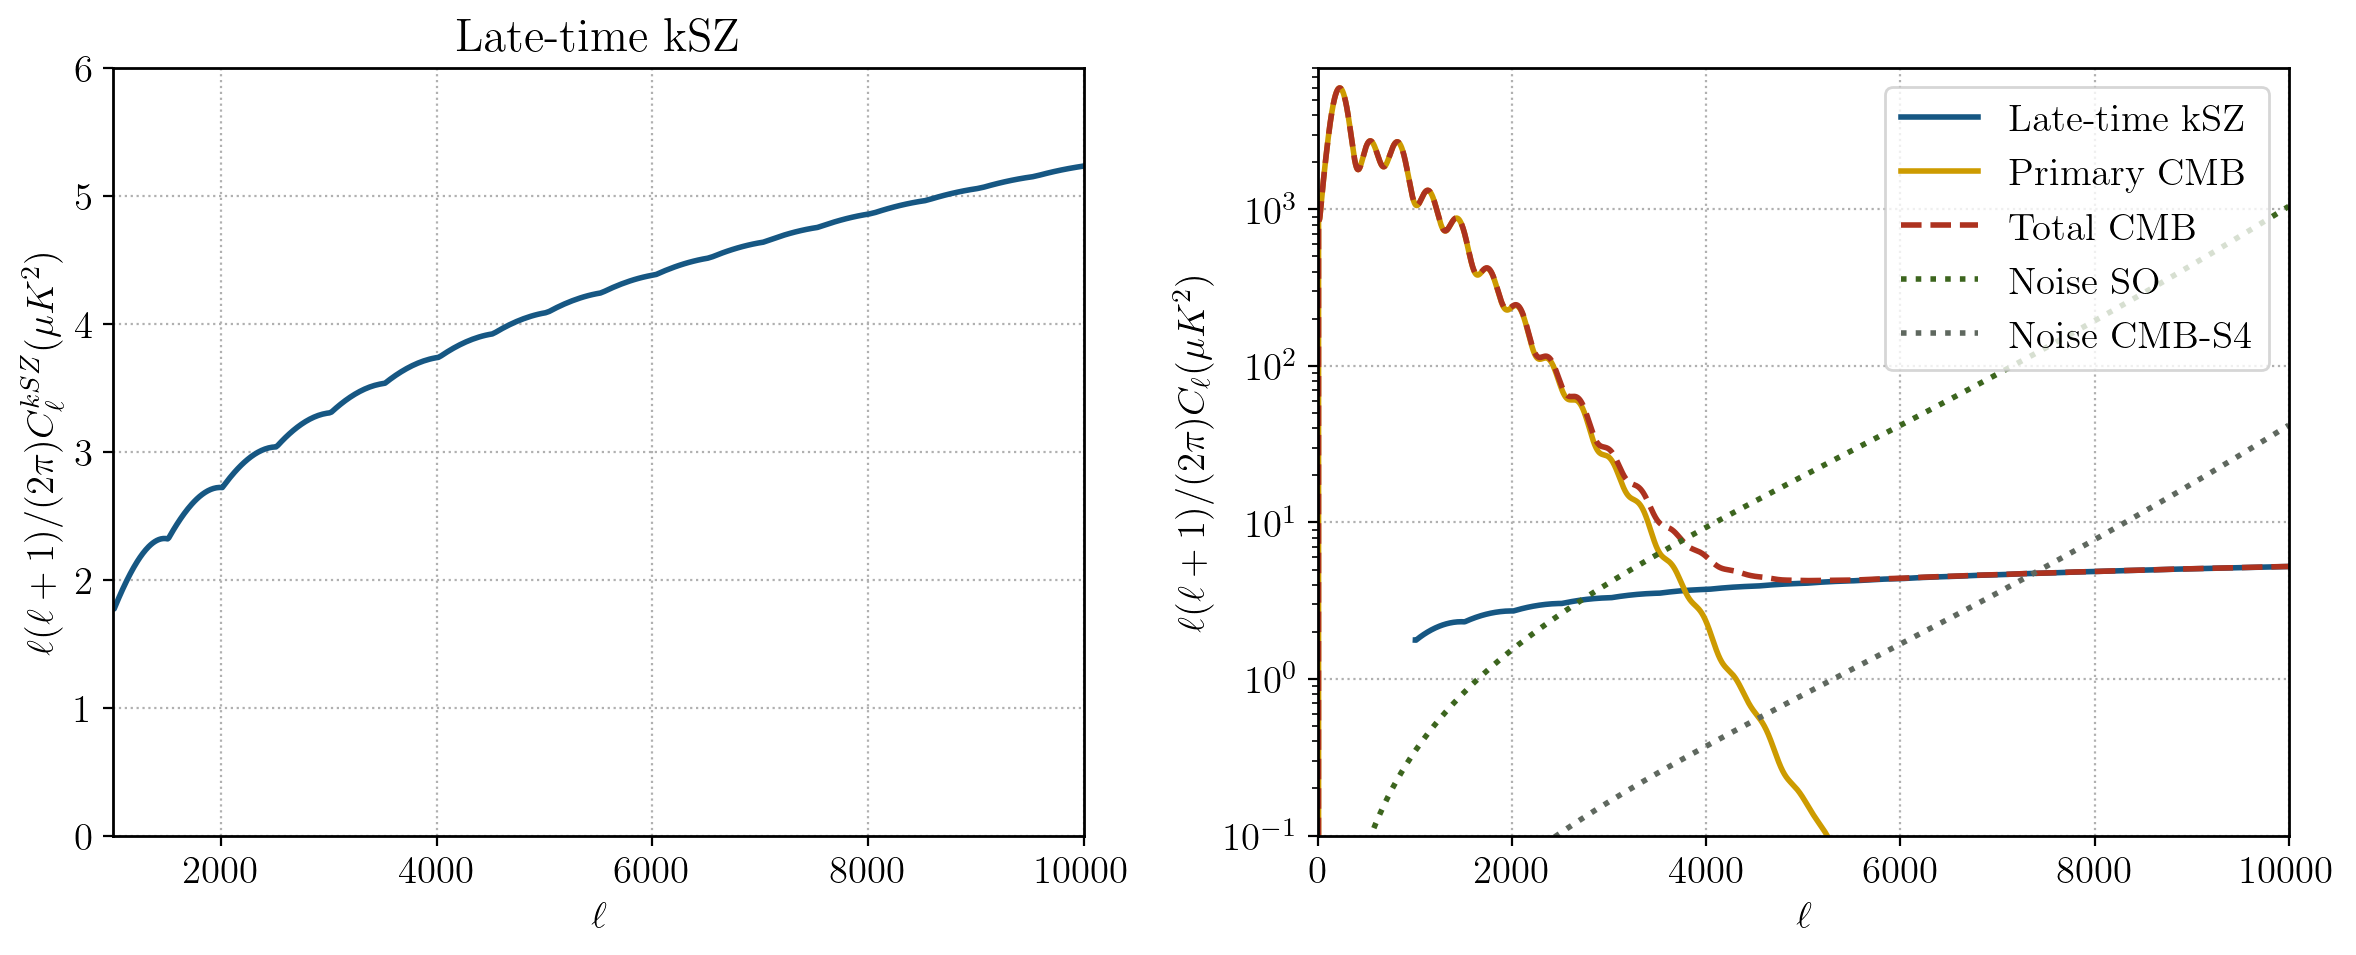

In [7]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(ls_kSZ, Cl_kSZ(ls_kSZ)*(ls_kSZ*(ls_kSZ+1))/(2.*np.pi))
plt.ylabel('$\ell(\ell +1)/(2\pi) C^{kSZ}_{\ell} (\mu K^2)$')
plt.xlabel('$\ell$')
plt.xlim(1000, 10000)
plt.ylim(0,6)
plt.title('Late-time kSZ')
plt.grid(linestyle='dotted')

plt.subplot(1,2,2)
plt.plot(ls_kSZ, Cl_kSZ(ls_kSZ)*(ls_kSZ*(ls_kSZ+1))/(2.*np.pi), label='Late-time kSZ')
plt.plot(ls[1:], cl_TT(ls[1:])*(ls[1:]*(ls[1:]+1))/(2*np.pi), label='Primary CMB')
plt.plot(ls_tot, Cl_tot(ls_tot)*(ls_tot*(ls_tot+1))/(2.*np.pi), '--', label='Total CMB')
plt.plot(ls_tot, noise_TT[0]*(ls_tot*(ls_tot+1))/(2.*np.pi), ':', label='Noise SO')
plt.plot(ls_tot, noise_TT[1]*(ls_tot*(ls_tot+1))/(2.*np.pi), ':', label='Noise CMB-S4')

plt.xlim(0, 10000)
plt.ylim(1e-1, 8e3)
plt.yscale('log')
plt.ylabel('$\ell(\ell +1)/(2\pi) C_{\ell} (\mu K^2)$')
plt.xlabel('$\ell$')
plt.legend(loc='upper right')
plt.grid(linestyle='dotted')
plt.tight_layout()

In [8]:

bias_params = dict(m=0.706, q=0.8879, brsd=1., b_par=1., b_perp=1., b2=0., bv=1.) # bv parameter is added for future use of kSZ and ML seperately


nkL = 200
nmu = 100

k_large = np.logspace(np.log10(6e-4),-1,nkL) # Mpc^-1
mu_L = np.linspace(-1,1,nmu)

# halo masses
Mh = np.logspace(8,15,200) # Msun

use_z = 1.

# VROY10 properties (from 1810.13424)
vol_VRO10 = (180*u.Gpc**3).to(u.Mpc**3)
nsources_VRO10 = 1.2e-2 # Mpc^-3 # 
bg_VRO10 = 1.6

vol_DESI = (116*u.Gpc**3).to(u.Mpc**3)
nsources_DESI = 1.4e-4 # Mpc^-3 # 
bg_DESI = 1.5



Delta_T_S4 = 1.4
FWHM_S4 = 1.4

### Calculate $P_{vv}$, $N_{vv}$ and SNR for both kSZ and ML

In [9]:
_, Nvv_par_VRO10, Nvv_perp_VRO10 = get_noises(use_z, cosmo_params, k_large, mu_L, bg_VRO10, nsources_VRO10, 'VRO10', Delta_T_S4)
_, Nvv_par_DESI, Nvv_perp_DESI = get_noises(use_z, cosmo_params, k_large, mu_L, bg_DESI, nsources_DESI, 'DESI', Delta_T_S4)
_,_,_,Pvv_par,Pvv_perp,_ = get_powers(use_z, cosmo_params, bias_params, k_large, mu_L, 'VRO10')
Pvv = Pvv_par + Pvv_perp

Nvv_VRO10_kSZ = mu_L**-2 * Nvv_par_VRO10
Nvv_DESI_kSZ = mu_L**-2 * Nvv_par_DESI

Nvv_VRO10_ML = (np.sqrt(1-mu_L**2))**-2 * Nvv_perp_VRO10
Nvv_DESI_ML = (np.sqrt(1-mu_L**2))**-2 * Nvv_perp_DESI

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  15  iterations.
Note: redshifts have been re-sorted (earliest first)


/Users/user1/Desktop/Codes/hmvec-ksz-dev/hmvec/hod.py:138: RuntimeWarning: invalid value encountered in divide
  ret = Ns ** 2.0 / Nc
/Users/user1/Desktop/Codes/hmvec-ksz-dev/hmvec/hod.py:166: RuntimeWarning: invalid value encountered in divide
  ret = Ns ** 3.0 / Nc ** 2.0
/Users/user1/Desktop/Codes/hmvec-ksz-dev/hmvec/hod.py:218: RuntimeWarning: invalid value encountered in divide
  ret = Ns ** 2.0 / Nc
/Users/user1/Desktop/Codes/hmvec-ksz-dev/hmvec/fft.py:127: RuntimeWarning: invalid value encountered in divide
  uk = ukts / kts[None, None, :] / mnorm[..., None]


Note: redshifts have been re-sorted (earliest first)


/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_37206/2817045404.py:115: RuntimeWarning: divide by zero encountered in divide
  N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_37206/2817045404.py:117: RuntimeWarning: divide by zero encountered in power
  N_vv_ML = (np.sqrt(1-new_resize_muL**2))**-2 * Nvv_perp # Mpc^3


Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  16  iterations.
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_37206/2154721784.py:9: RuntimeWarning: divide by zero encountered in power
  Nvv_VRO10_ML = (np.sqrt(1-mu_L**2))**-2 * Nvv_perp_VRO10
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_37206/2154721784.py:10: RuntimeWarning: divide by zero encountered in power
  Nvv_DESI_ML = (np.sqrt(1-mu_L**2))**-2 * Nvv_perp_DESI


Text(0.015, 0.04, '$\\mu=0.9$')

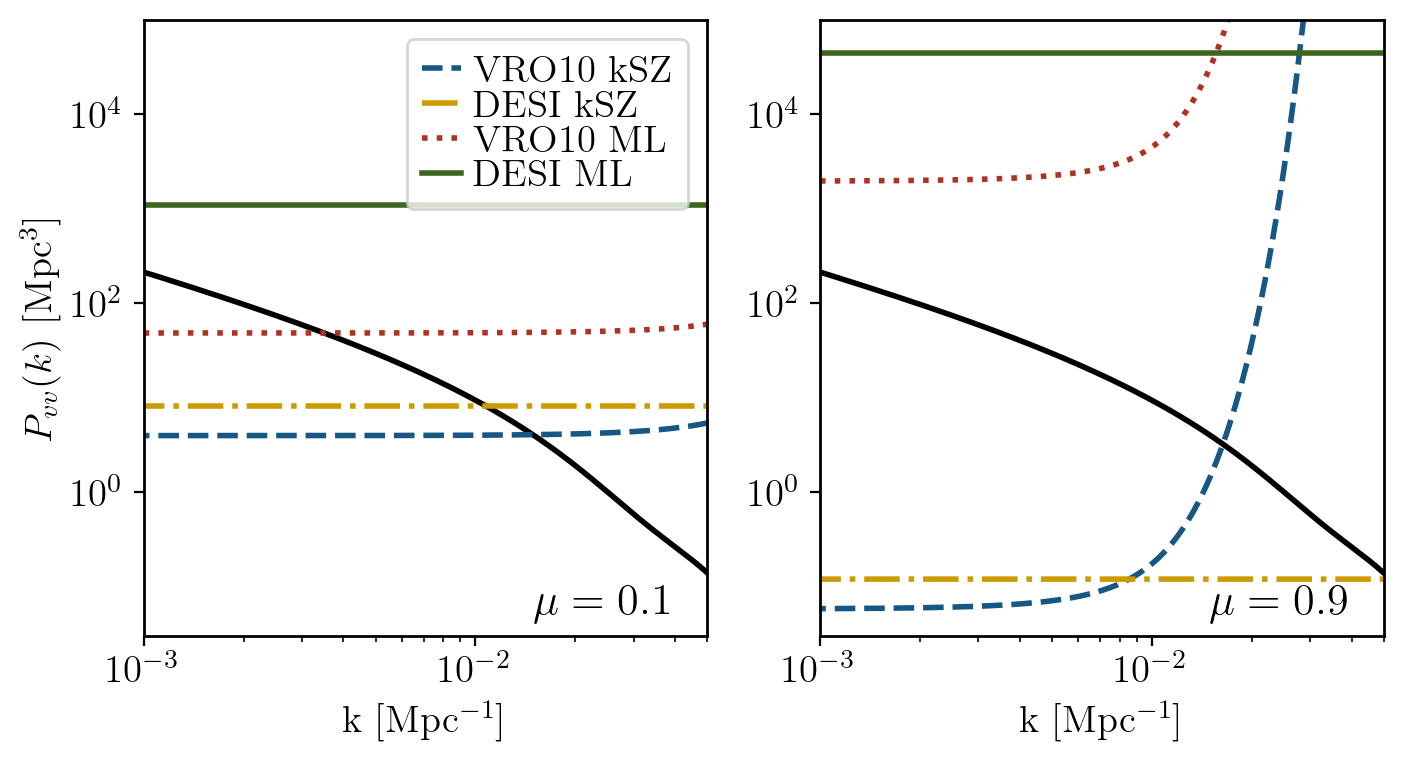

In [10]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_VRO10_kSZ[:,55], ls='--', color=palette[0], label='VRO10 kSZ')
plt.loglog(k_large, Nvv_DESI_kSZ[:,55], ls='-.', color=palette[1], label='DESI kSZ')
plt.loglog(k_large, Nvv_VRO10_ML[:,55], ls=':', color=palette[2], label='VRO10 ML')
plt.loglog(k_large, Nvv_DESI_ML[:,55], color=palette[3], label='DESI ML')
#plt.title(r'$\mu=0.1$')
plt.xlim(1e-3, 5e-2)
plt.ylim(3e-2,1e5)
plt.legend(ncol=1, handlelength=1, labelspacing=0,handletextpad=0.3, loc=1)
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel(r'$P_{vv}(k)$ [Mpc$^3$]')
plt.text(1.5e-2, 4e-2, r'$\mu=%g$'%np.round(mu_L[55],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
#plt.grid(linestyle='dotted')

plt.subplot(1,2,2)
plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_VRO10_kSZ[:,95], ls='--', color=palette[0])
plt.loglog(k_large, Nvv_DESI_kSZ[:,95], ls='-.', color=palette[1])
plt.loglog(k_large, Nvv_VRO10_ML[:,95], ls=':', color=palette[2])
plt.loglog(k_large, Nvv_DESI_ML[:,95], color=palette[3])
#plt.title(r'$\mu=0.9$')
plt.xlim(1e-3, 5e-2)
plt.ylim(3e-2,1e5)
plt.xlabel('k [Mpc$^{-1}$]')
plt.text(1.5e-2, 4e-2, r'$\mu=%g$'%np.round(mu_L[95],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
#plt.grid(linestyle='dotted')

In [11]:
zs = np.array([0.2,0.7,1.3,1.9,2.6])
bgs = np.array([1.05,1.37,1.79,2.22,2.74])
ngs = np.array([5e-2,2e-2,6e-3,15e-4,3e-4])
vs = (np.array([5.2,43.6,75.9,89.3,119.9])*u.Gpc**3).to(u.Mpc**3)

In [13]:
zs_DESI

array([0.2 , 0.6 , 0.95, 1.35, 1.85])

In [16]:
_, Nvv_par_VRO10, _ = get_noises(zs[2], cosmo_params, k_large, mu_L, bgs[2], ngs[2], 'VRO10', Delta_T_S4)
_, Nvv_par_DESI, _ = get_noises(zs_DESI[3], cosmo_params, k_large, mu_L, bgs_DESI[3], ngs_DESI[3], 'DESI', Delta_T_S4)
_,_,_,Pvv_par,Pvv_perp,_ = get_powers(zs[2], cosmo_params, bias_params, k_large, mu_L, 'VRO10')
Pvv = Pvv_par + Pvv_perp

Nvv_VRO10_kSZ = mu_L**-2 * Nvv_par_VRO10
Nvv_DESI_kSZ = mu_L**-2 * Nvv_par_DESI


Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  16  iterations.
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_37206/2817045404.py:115: RuntimeWarning: divide by zero encountered in divide
  N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_37206/2817045404.py:117: RuntimeWarning: divide by zero encountered in power
  N_vv_ML = (np.sqrt(1-new_resize_muL**2))**-2 * Nvv_perp # Mpc^3


Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  17  iterations.
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Text(0.015, 0.04, '$\\mu=0.9$')

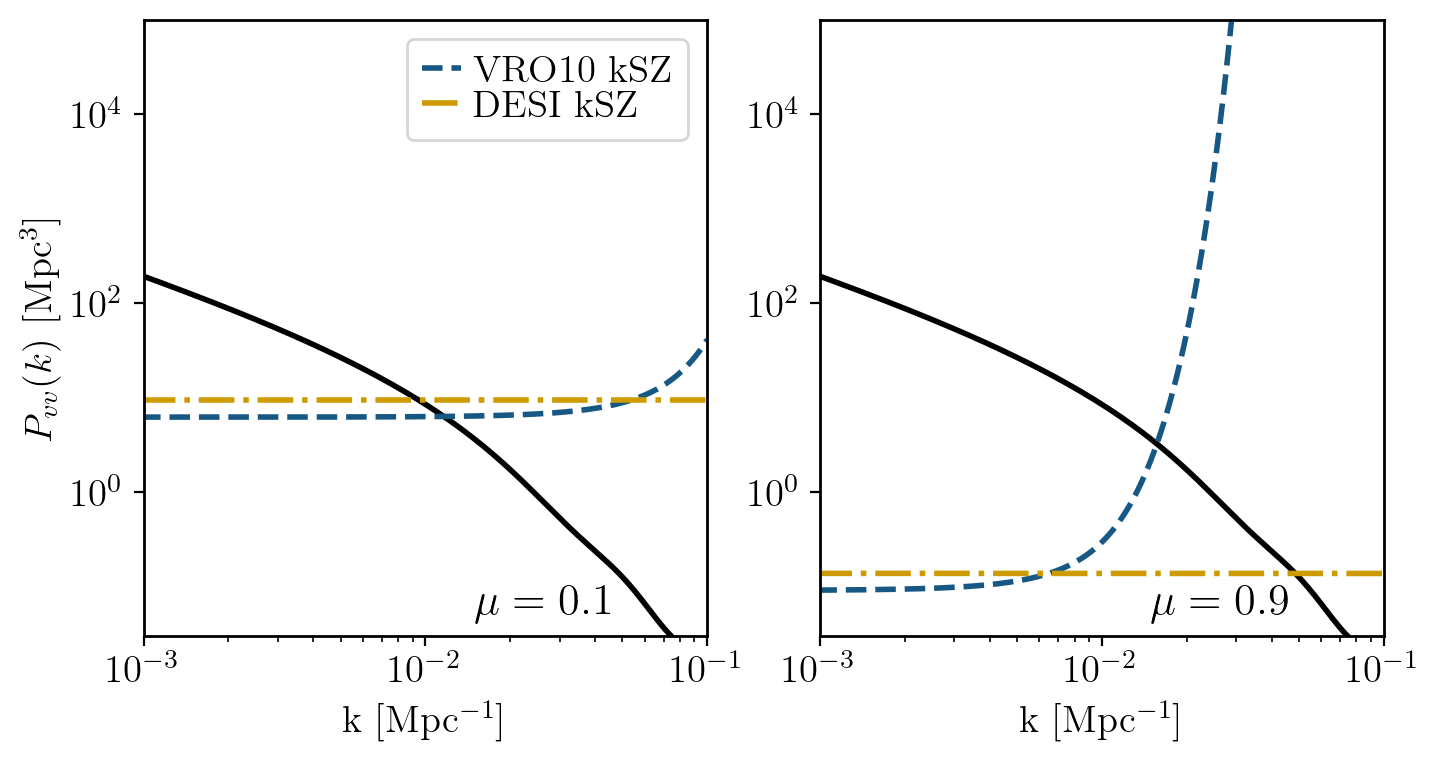

In [18]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_VRO10_kSZ[:,55], ls='--', color=palette[0], label='VRO10 kSZ')
plt.loglog(k_large, Nvv_DESI_kSZ[:,55], ls='-.', color=palette[1], label='DESI kSZ')
#plt.title(r'$\mu=0.1$')
plt.xlim(1e-3, 1e-1)
plt.ylim(3e-2,1e5)
plt.legend(ncol=1, handlelength=1, labelspacing=0,handletextpad=0.3, loc=1)
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel(r'$P_{vv}(k)$ [Mpc$^3$]')
plt.text(1.5e-2, 4e-2, r'$\mu=%g$'%np.round(mu_L[55],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
#plt.grid(linestyle='dotted')

plt.subplot(1,2,2)
plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_VRO10_kSZ[:,95], ls='--', color=palette[0])
plt.loglog(k_large, Nvv_DESI_kSZ[:,95], ls='-.', color=palette[1])
#plt.title(r'$\mu=0.9$')
plt.xlim(1e-3, 1e-1)
plt.ylim(3e-2,1e5)
plt.xlabel('k [Mpc$^{-1}$]')
plt.text(1.5e-2, 4e-2, r'$\mu=%g$'%np.round(mu_L[95],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
#plt.grid(linestyle='dotted')

Note: redshifts have been re-sorted (earliest first)


/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_37206/2345532402.py:26: RuntimeWarning: divide by zero encountered in divide
  noise_pot_VRO10 = ((1+zs[2])*rhoM0/2)**2/((bias_params['m']*zs[2]+bias_params['q'])**2 * ngs[2] * W_phot_VRO10**2)  # Mpc^-1
/Users/user1/anaconda3/lib/python3.10/site-packages/matplotlib/scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


Text(0, 0.5, '$k^4 P_{\\Phi \\Phi}(k)\\,[{\\rm Mpc^{-1}}]$')

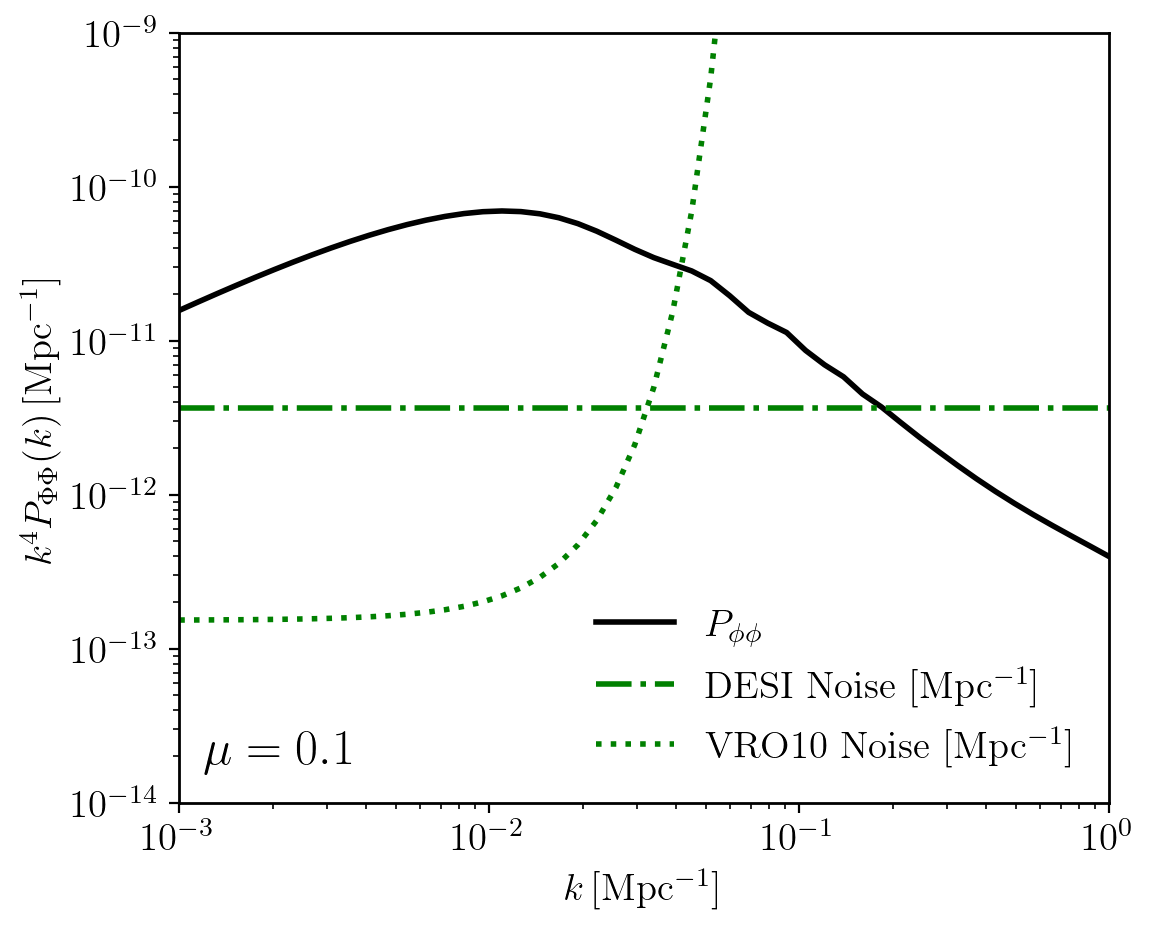

In [19]:
zcosmo = np.linspace(0.,15.,101)
cosmo_1 = cosmo_params.copy()
camb_pars = camb.set_params(**cosmo_1)
camb_pars.set_matter_power(redshifts=list(zcosmo))
cosmo = camb.get_results(camb_pars)
H = lambda z: cosmo.hubble_parameter(z)/(cu.c.to(u.km/u.s)).value # 1/Mpc
omegam = (camb_pars.ombh2 + camb_pars.omch2 + camb_pars.omnuh2) / (camb_pars.H0 / 100) ** 2
rhoM0 = 3*omegam*H(0.)**2 # Mpc^-2

sigma_phot_DESI = lambda z: 0.*(1+z)
sigma_phot_VRO10 = lambda z: 0.03*(1+z)

interp_Pphiphi = camb.get_matter_power_interpolator(camb_pars, zmin=0, zmax=zcosmo[-1], nz_step=150, zs=None, kmax=1e0, nonlinear=True,var1=camb.model.Transfer_Weyl, var2=camb.model.Transfer_Weyl, hubble_units=False, 
k_hunit=False, return_z_k=False, k_per_logint=None, log_interp=False,  extrap_kmax=True).P  # Mpc^3

# just for plot
k_vec = np.logspace(-3,0)
mu_use = 0.1#np.linspace(0,1)
#W_phot_kvec = np.exp(-mu_use**2*k_vec**2*sigma_phot(use_z)/2/Hz**2)
#noise_pot_vec = ((1+use_z)*rhoM0/2)**2/(bg**2 * nsources * W_phot_kvec**2)  # Mpc^-1

W_phot_DESI = np.exp(-mu_use**2*k_vec**2*sigma_phot_DESI(zs_DESI[3])/2/H(zs_DESI[3])**2)
noise_pot_DESI = ((1+zs_DESI[3])*rhoM0/2)**2/(bgs_DESI[3]**2 * ngs_DESI[3] * W_phot_DESI**2)  # Mpc^-1

W_phot_VRO10 = np.exp(-mu_use**2*k_vec**2*sigma_phot_VRO10(zs[2])/2/H(zs[2])**2)
noise_pot_VRO10 = ((1+zs[2])*rhoM0/2)**2/((bias_params['m']*zs[2]+bias_params['q'])**2 * ngs[2] * W_phot_VRO10**2)  # Mpc^-1

plt.loglog(k_vec, interp_Pphiphi(use_z,k_vec), 'k', label=r'$P_{\phi\phi}$')
plt.loglog(k_vec, noise_pot_DESI, color = 'green', ls='-.', label=r'DESI Noise $[{\rm Mpc^{-1}}]$')
plt.loglog(k_vec, noise_pot_VRO10, color = 'green', ls=':', label=r'VRO10 Noise $[{\rm Mpc^{-1}}]$')


plt.xlim(1e-3,1e0)
plt.ylim(1e-14,1e-9)
plt.legend(frameon=False)
plt.text(1.2e-3, 1.5e-14, r'$\mu=%g$'%mu_use, fontsize=18, ha='left', va='bottom', color='black', alpha=1)

plt.xlabel(r'$k\,[{\rm Mpc^{-1}}]$')
plt.ylabel(r'$k^4 P_{\Phi \Phi}(k)\,[{\rm Mpc^{-1}}]$')

# Fisher Calculations - VRO10

In [20]:
deltas = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 3e-1, 3e-1, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]

survey = 'VRO10'
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'm', 'q', 'brsd', 'b_par', 'b_perp', 'b2']
fixed_params=['b_par', 'b_perp']


zs = np.array([0.2,0.7,1.3,1.9,2.6])
bgs = np.array([1.05,1.37,1.79,2.22,2.74])
ngs = np.array([5e-2,2e-2,6e-3,15e-4,3e-4])
vs = (np.array([5.2,43.6,75.9,89.3,119.9])*u.Gpc**3).to(u.Mpc**3)
bias1 = bias_params.copy()

Fz_XX_VRO10=np.zeros((len(zs),len(free_params),len(free_params)))
Fz_vX_VRO10=np.zeros((len(zs),len(free_params),len(free_params)))
for i in range(len(zs)):
    k_large = np.logspace(np.log10(np.pi/vs[i].value**(1/3)),-1,nkL) # Mpc^-1
    xx,vx = Fisher_mat(zs[i], cosmo_params, bias_params, free_params, deltas, k_large, mu_L, ngs[i], survey, Delta_T_S4, vs[i])
    Fz_XX_VRO10[i,:,:]=xx
    Fz_vX_VRO10[i,:,:]=vx


Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  13  iterations.
Note: redshifts have been re-sorted (earliest first)


/Users/user1/Desktop/Codes/hmvec-ksz-dev/hmvec/hod.py:138: RuntimeWarning: invalid value encountered in divide
  ret = Ns ** 2.0 / Nc
/Users/user1/Desktop/Codes/hmvec-ksz-dev/hmvec/hod.py:166: RuntimeWarning: invalid value encountered in divide
  ret = Ns ** 3.0 / Nc ** 2.0
/Users/user1/Desktop/Codes/hmvec-ksz-dev/hmvec/hod.py:218: RuntimeWarning: invalid value encountered in divide
  ret = Ns ** 2.0 / Nc
/Users/user1/Desktop/Codes/hmvec-ksz-dev/hmvec/fft.py:127: RuntimeWarning: invalid value encountered in divide
  uk = ukts / kts[None, None, :] / mnorm[..., None]


Note: redshifts have been re-sorted (earliest first)


/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_37206/2817045404.py:115: RuntimeWarning: divide by zero encountered in divide
  N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_37206/2817045404.py:117: RuntimeWarning: divide by zero encountered in power
  N_vv_ML = (np.sqrt(1-new_resize_muL**2))**-2 * Nvv_perp # Mpc^3




Now simulating for (1+delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is par

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first



Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (ear

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (

In [35]:
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'm', 'q', 'brsd', 'b_par', 'b_perp', 'b2']


F_vX_VRO10 = np.sum(Fz_vX_VRO10, axis=0)
F_XX_VRO10 = np.sum(Fz_XX_VRO10, axis=0)


print('Galaxies:')
covmat_xx, cov_params = covariance_mat(F_XX_VRO10, free_params, fixed_params+['brsd'], {})
print_1_sigmas(covmat_xx,cov_params)
print('\n Galaxies+kSZ:')
covmat_vx, cov_params = covariance_mat(F_vX_VRO10, free_params, ['brsd'], {'b_par':0.01})
print_1_sigmas(covmat_vx,cov_params)

Galaxies:


1-sigma of H0 is 4.662933049246897
1-sigma of ombh2 is 0.00044216227653261404
1-sigma of omch2 is 0.002012483583008058
1-sigma of ns is 0.022105693313896887
1-sigma of As is 5.460060347653969e-10
1-sigma of tau is 97.35177167760628
1-sigma of mnu is 0.17031110923270457
1-sigma of m is 0.0452793656155553
1-sigma of q is 0.028009553745337208
1-sigma of b2 is 1.3357268445966461

 Galaxies+kSZ:


1-sigma of H0 is 1.7177877568453115
1-sigma of ombh2 is 0.00043398931147441334
1-sigma of omch2 is 0.0018117947897021483
1-sigma of ns is 0.01841477183489724
1-sigma of As is 1.42125887815451e-10
1-sigma of tau is 15.360807838893347
1-sigma of mnu is 0.1225884366837082
1-sigma of m is 0.011388345599958254
1-sigma of q is 0.011814819906260224
1-sigma of b_par is 0.008685406917840238
1-sigma of b_perp is 0.02658777808038669
1-sigma of b2 is 1.1010860694569802


In [23]:
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'm', 'q', 'brsd', 'b_par', 'b_perp', 'b2']


F_vX_VRO10 = np.sum(Fz_vX_VRO10, axis=0)
F_XX_VRO10 = np.sum(Fz_XX_VRO10, axis=0)


print('Galaxies:')
covmat_xx, cov_params = covariance_mat(F_XX_VRO10, free_params, fixed_params, {})
print_1_sigmas(covmat_xx,cov_params)
print('\n Galaxies+kSZ:')
covmat_vx, cov_params = covariance_mat(F_vX_VRO10, free_params, [], {})
print_1_sigmas(covmat_vx,cov_params)

Galaxies:


1-sigma of H0 is 4.662933049254961
1-sigma of ombh2 is 0.00044216227653261415
1-sigma of omch2 is 0.002012483583008081
1-sigma of ns is 0.02210569331390115
1-sigma of As is 0.000361769499646286
1-sigma of tau is 97.35177167786213
1-sigma of mnu is 0.17031110923277845
1-sigma of m is 58047.56062509203
1-sigma of q is 73003.44062191057
1-sigma of brsd is 82220.34082885107
1-sigma of b2 is 1.3357268445966564

 Galaxies+kSZ:


1-sigma of H0 is 2.0223077074252616
1-sigma of ombh2 is 0.00043812910373455815
1-sigma of omch2 is 0.001997213547464418
1-sigma of ns is 0.018598980338102776
1-sigma of As is 0.0002289930637033905
1-sigma of tau is 15.361820433583537
1-sigma of mnu is 0.12503411113771049
1-sigma of m is 36742.9779487256
1-sigma of q is 46209.759377755654
1-sigma of brsd is 52043.87811438495
1-sigma of b_par is 52043.87811433592
1-sigma of b_perp is 52043.87811434508
1-sigma of b2 is 1.102418877504272


Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu)$ [eV]')

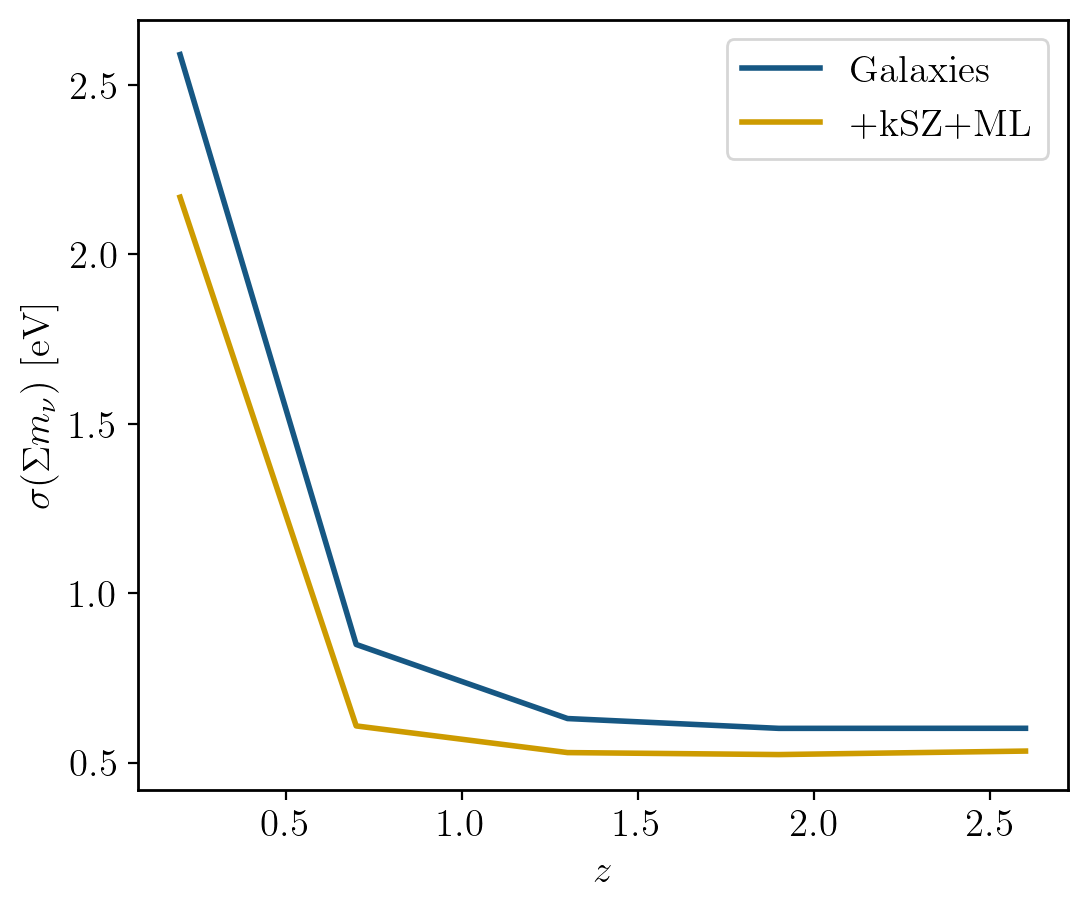

In [24]:

mnu_ind = free_params.index('mnu')
sig_mnu_VRO10_bins = np.zeros(len(zs))
sig_mnu_VRO10_kSZ_bins = np.zeros(len(zs))
for i in range(len(zs)):
    covmat_gal_z, cov_params = covariance_mat(Fz_XX_VRO10[i], free_params, fixed_params, {})
    sig_mnu_VRO10_bins[i] = np.sqrt(covmat_gal_z[mnu_ind,mnu_ind])
    covmat_gal_kSZ_z, cov_params = covariance_mat(Fz_vX_VRO10[i], free_params, [], {})
    sig_mnu_VRO10_kSZ_bins[i] = np.sqrt(covmat_gal_kSZ_z[mnu_ind,mnu_ind])

plt.plot(zs, sig_mnu_VRO10_bins, label='Galaxies')
plt.plot(zs, sig_mnu_VRO10_kSZ_bins, label='+kSZ+ML')
plt.legend()
plt.xlabel(r'$z$')
plt.ylabel(r'$\sigma(\Sigma m_\nu)$ [eV]')

In [26]:
F_bao_CMB_S4_L = np.zeros((len(F_XX_VRO10), len(F_XX_VRO10)))
F_bao_CMB_S4_L[:7,:7] = F_bao_CMB_S4


print('CMB+Galaxies:')
covmat_xx, cov_params = covariance_mat(F_bao_CMB_S4_L+F_XX_VRO10, free_params, fixed_params+[], {})
print_1_sigmas(covmat_xx,cov_params)
print('\n CMB+Galaxies+kSZ:')
covmat_vx, cov_params = covariance_mat(F_bao_CMB_S4_L+F_vX_VRO10, free_params, [], {})
print_1_sigmas(covmat_vx,cov_params)

CMB+Galaxies:


1-sigma of H0 is 0.21885771325870512
1-sigma of ombh2 is 2.9562465868658506e-05
1-sigma of omch2 is 0.0004729661148365007
1-sigma of ns is 0.0019713539534951135
1-sigma of As is 3.058731749274392e-11
1-sigma of tau is 0.007715773679077389
1-sigma of mnu is 0.028390815554007656
1-sigma of m is 0.003064609777217872
1-sigma of q is 0.004694924995223711
1-sigma of brsd is 0.025531256635547186
1-sigma of b2 is 0.633646316548124

 CMB+Galaxies+kSZ:


1-sigma of H0 is 0.21586736955732228
1-sigma of ombh2 is 2.9550742552860885e-05
1-sigma of omch2 is 0.000452687194051157
1-sigma of ns is 0.0019512063110434955
1-sigma of As is 2.869954175527237e-11
1-sigma of tau is 0.007260266819368704
1-sigma of mnu is 0.026917471703106922
1-sigma of m is 0.0029679241394373573
1-sigma of q is 0.00435368306947991
1-sigma of brsd is 0.01447654028246107
1-sigma of b_par is 0.003526766174328506
1-sigma of b_perp is 0.024907408178808006
1-sigma of b2 is 0.6208385633259665


Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu)$ [meV]')

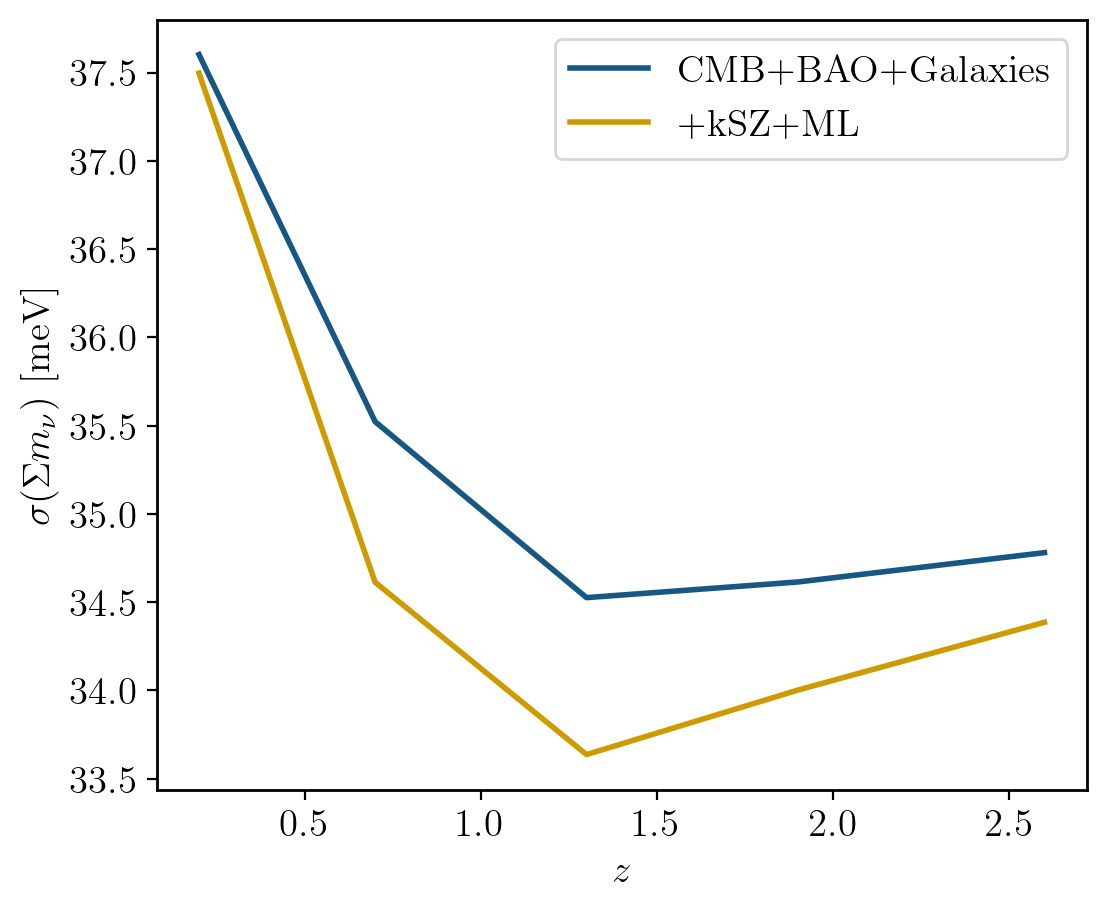

In [27]:
for i in range(len(zs)):
    covmat_gal_z, cov_params = covariance_mat(F_bao_CMB_S4_L+Fz_XX_VRO10[i], free_params, fixed_params, {})
    sig_mnu_VRO10_bins[i] = np.sqrt(covmat_gal_z[mnu_ind,mnu_ind])
    covmat_gal_kSZ_z, cov_params = covariance_mat(F_bao_CMB_S4_L+Fz_vX_VRO10[i], free_params, [], {})
    sig_mnu_VRO10_kSZ_bins[i] = np.sqrt(covmat_gal_kSZ_z[mnu_ind,mnu_ind])

plt.plot(zs, sig_mnu_VRO10_bins*1e3, label='CMB+BAO+Galaxies')
plt.plot(zs, sig_mnu_VRO10_kSZ_bins*1e3, label='+kSZ+ML')
plt.legend()
plt.xlabel(r'$z$')
plt.ylabel(r'$\sigma(\Sigma m_\nu)$ [meV]')

A test of how adding $b_\parallel$ prior affect the neutrino masses error

Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu)$')

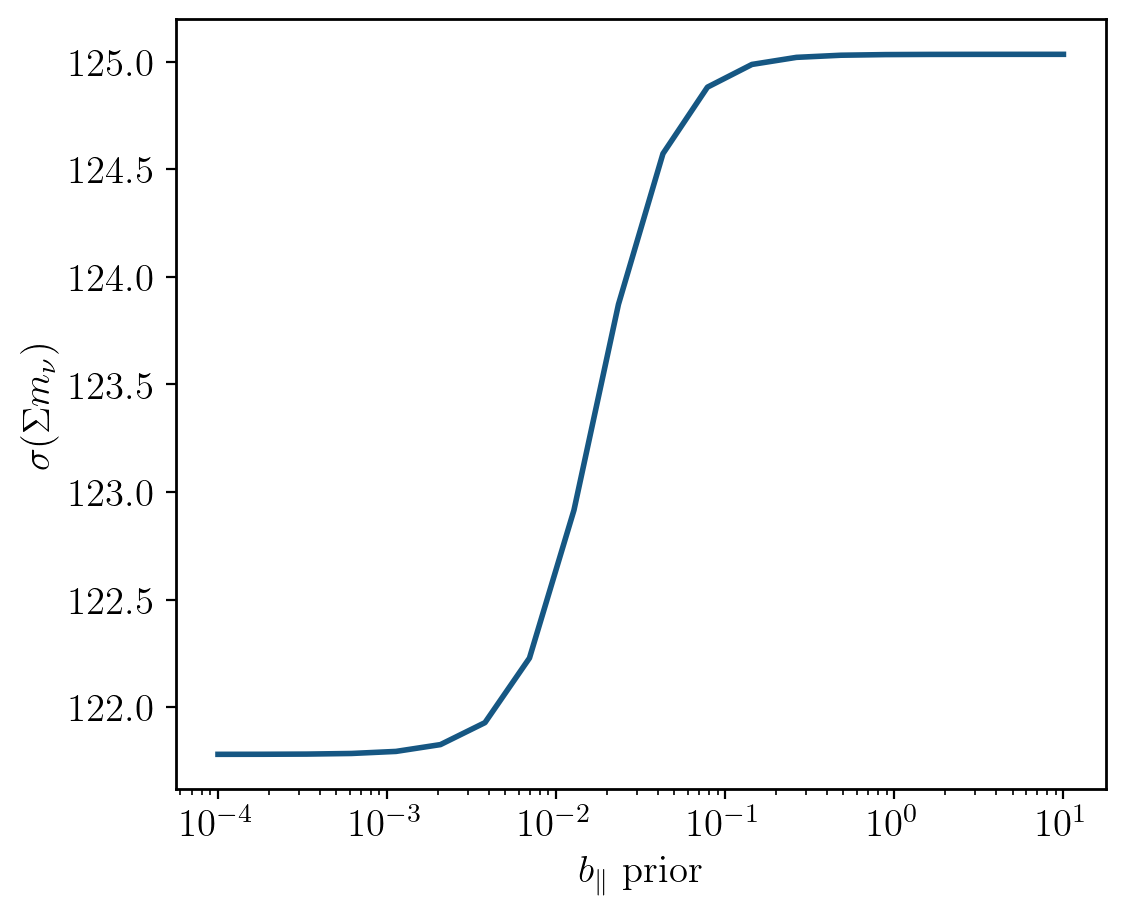

In [28]:
mnu_ind = free_params.index('mnu')


F_bao_CMB_S4_L = np.zeros((len(F_XX_VRO10), len(F_XX_VRO10)))
F_bao_CMB_S4_L[:7,:7] = F_bao_CMB_S4

priors = np.logspace(-4,1,20)
sig_mnu_prior_bpar = np.zeros(len(priors))

for i in range(len(priors)):
    #covmat_vx, cov_params = covariance_mat(F_bao_CMB_S4_L+F_vX_t[4], free_params, ['brsd'], {'b_par':priors[i]})#, 'm':0.07,'q':0.09,'b2':8,'b_perp':0.1})
    covmat_vx, cov_params = covariance_mat(F_vX_VRO10, free_params, ['brsd'], {'b_par':priors[i]})#, 'm':0.07,'q':0.09,'b2':8,'b_perp':0.1})
    sig_mnu_prior_bpar[i] = np.sqrt(covmat_vx[mnu_ind,mnu_ind])

plt.semilogx(priors,1e3*sig_mnu_prior_bpar)
plt.xlabel(r'$b_\parallel$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu)$')


Text(0.5, 0.98, 'CMB-S4 noise parameters')

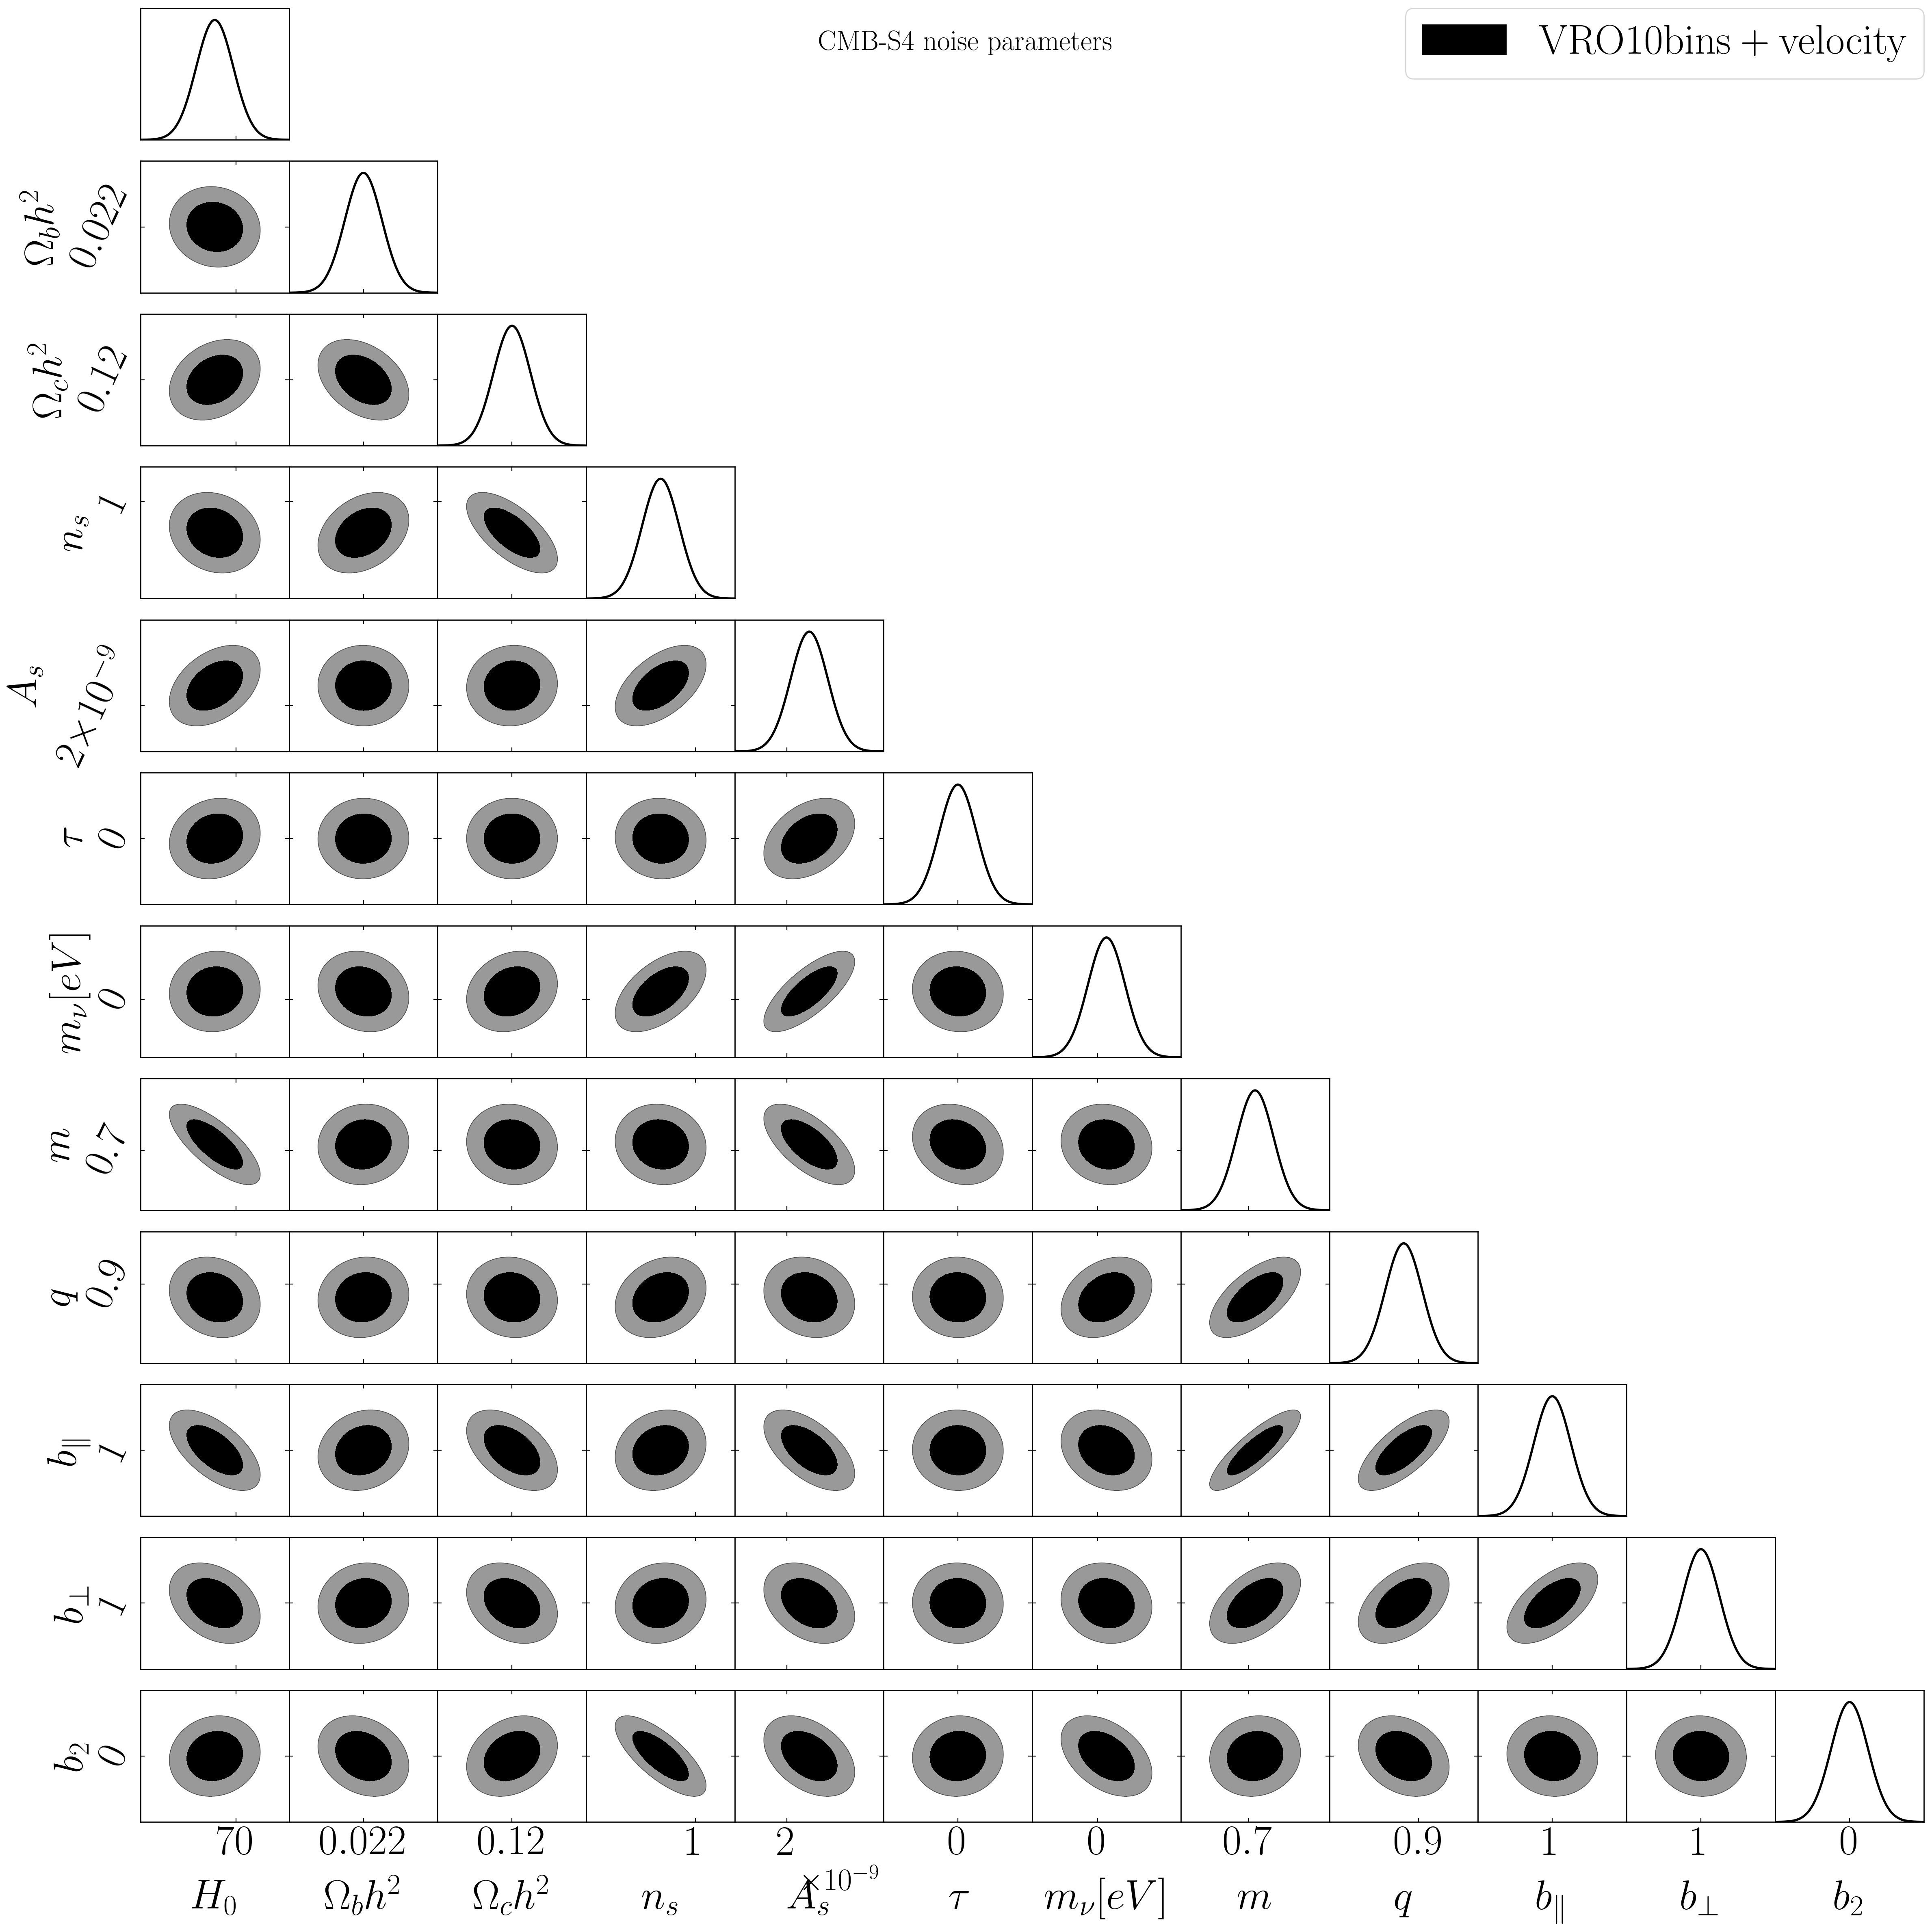

In [29]:
param_list = free_params.copy()
param_list.remove('brsd')

fiducials = np.zeros(len(param_list))
for i in range(len(param_list)):
    param = param_list[i]
    if param in cosmo_params:
        fiducials[i] = cosmo_params[param]
    else:
        fiducials[i] = bias_params[param]

names_all = [r'$H_0$',
             r'$\Omega_bh^2$',
             r'$\Omega_ch^2$',
             r'$n_s$',
             r'$A_s$',
             r'$\tau$',
             r'$m_\nu[eV]$',
             r'$m$',
             r'$q$',
             #r'$b_\mathrm{rsd}$',
             r'$b_\parallel$',
             r'$b_\perp$',
             r'$b_2$',
           ]


from getdist import plots as gp

#covmat_vx, cov_params = covariance_mat(F_bao_CMB_DT+F_vX_t[4], free_params, fixed_params, {})
#covmat_vx, cov_params = covariance_mat(F_vX_t[4], free_params, [], {})
covmat_vx, cov_params = covariance_mat(F_vX_VRO10, free_params, ['brsd'], {})

plot_dist = GaussianND(fiducials, covmat_vx, names=names_all)			

settings = gp.GetDistPlotSettings()

settings.norm_prob_label = False
settings.axes_fontsize = 40
settings.legend_fontsize = 40
settings.lab_fontsize = 40

g = gp.get_subplot_plotter(settings=settings)

g.settings.figure_legend_frame = True
g.settings.alpha_filled_add=0.4
g.settings.title_limit_fontsize = 14
g.settings.axis_tick_y_rotation = 65

g.triangle_plot([plot_dist], names_all, filled=True,\
    legend_labels=[r'${\rm VRO10 bins + velocity}$'],legend_loc='upper right',\
    contour_colors=['k'], line_args=[{'lw':2, 'color':'k'}], markers={'x2':0})

g.fig.suptitle("CMB-S4 noise parameters", fontsize=25)


## Plots for paper

Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu) \\, \\textrm{[meV]}$')

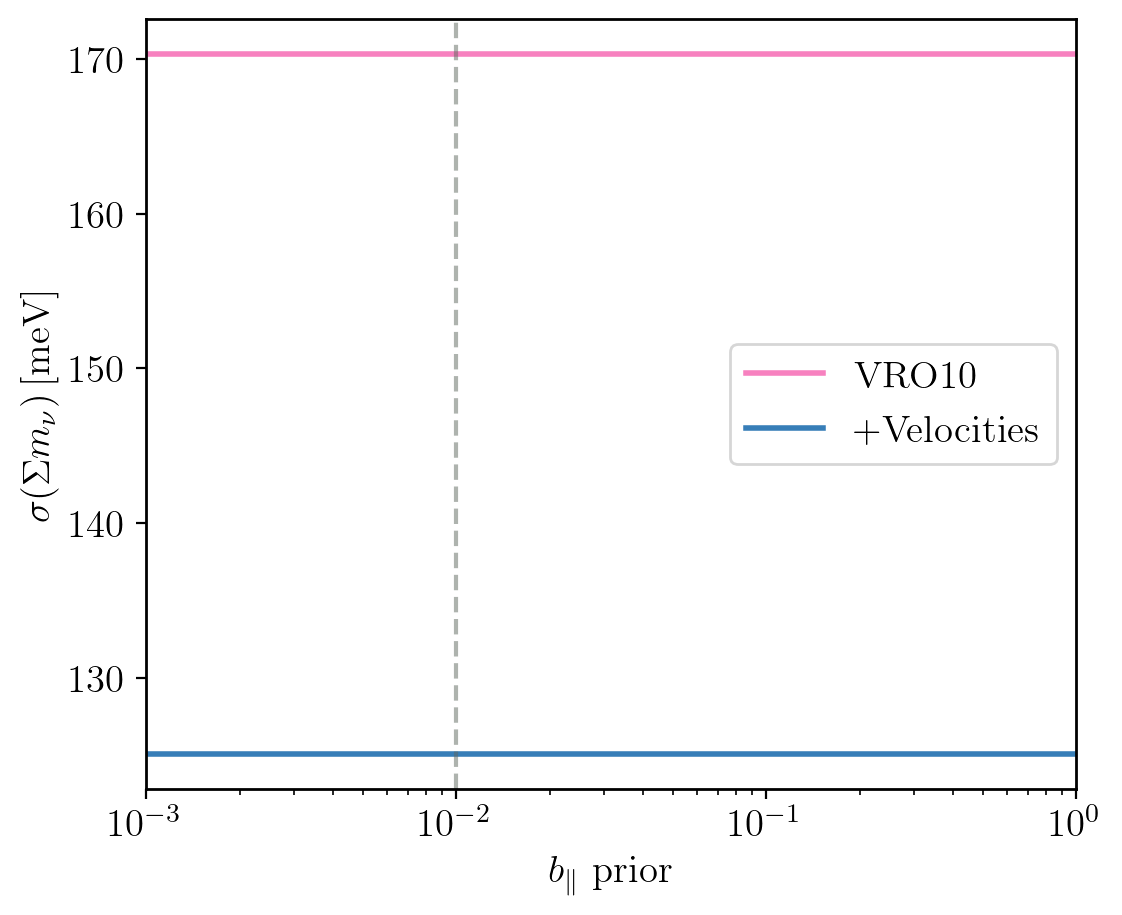

In [30]:
#bpar_pr = np.linspace(1e-4,1e-1,100)
bpar_pr = np.logspace(-3,0,100)

mnu_ind = free_params.index('mnu')
sig_mnu_gal = np.zeros(len(bpar_pr))
sig_mnu_gal_vel = np.zeros(len(bpar_pr))

for i in range(len(bpar_pr)):
    covmat_lim, cov_params = covariance_mat(F_XX_VRO10, free_params, fixed_params, {})
    sig_mnu_gal[i] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_kSZ, cov_params = covariance_mat(F_vX_VRO10, free_params, [], {'b_par':bpar_pr[i]})
    sig_mnu_gal_vel[i] = np.sqrt(covmat_lim_kSZ[mnu_ind,mnu_ind])

plt.plot(bpar_pr, sig_mnu_gal*1e3, label='VRO10', color=palette[8])
plt.plot(bpar_pr, sig_mnu_gal_vel*1e3, label='+Velocities', color=palette[5])
plt.axvline(x = 1e-2, color = palette[4], alpha=0.5, ls='--', lw=1.5)

plt.xscale('log')
plt.xlim(bpar_pr[0],bpar_pr[-1])
plt.legend()
plt.xlabel(r'$b_\parallel$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
#plt.title(r'low+high $z$ with 0.5\% prior on $b_\parallel$')
#plt.ylim(60,75)

In [31]:
vm_root ='/Users/user1/Desktop/School/Cosmology/SharedVM/galaxies/'

np.savetxt(vm_root+'sig_mnu_bpar_gal.txt', sig_mnu_gal)
np.savetxt(vm_root+'sig_mnu_bpar_gal_vel.txt', sig_mnu_gal_vel)


Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu) \\, \\textrm{[meV]}$')

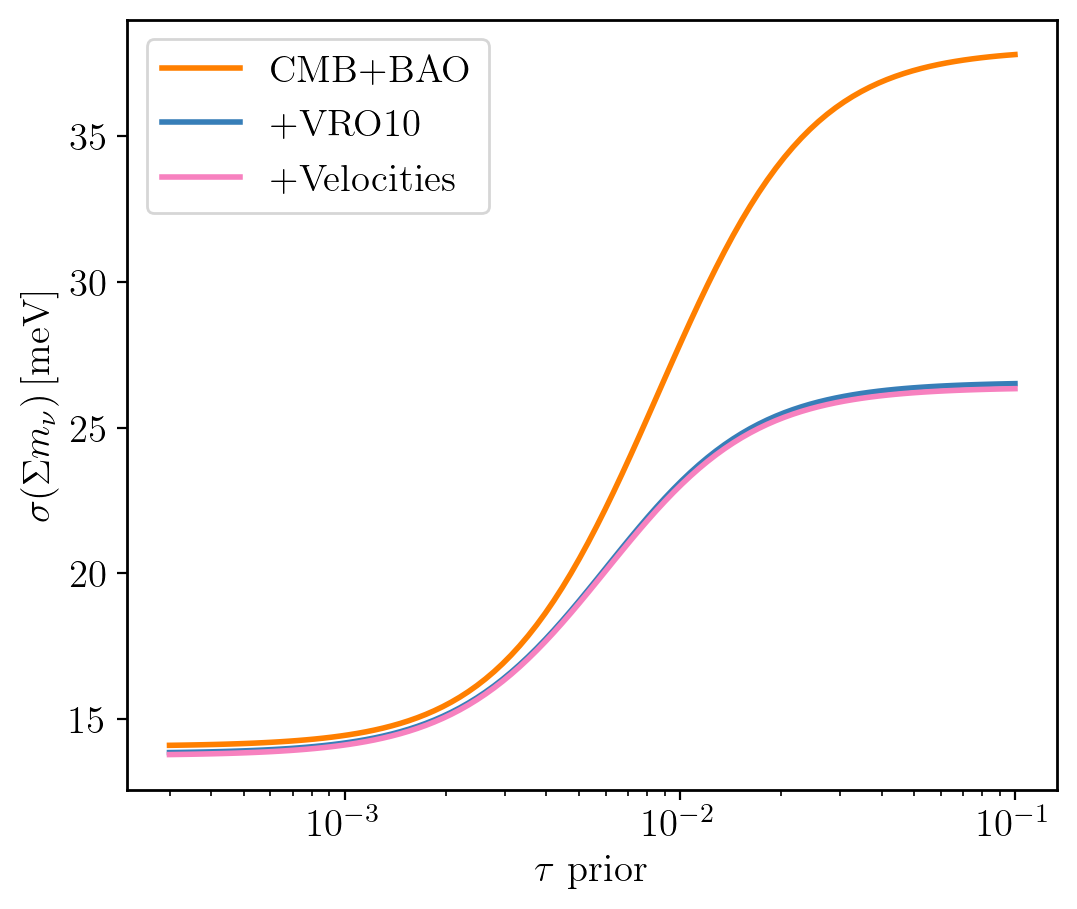

In [32]:
#bpar_pr = np.linspace(1e-4,1e-1,100)
tau_pr = np.logspace(np.log10(3e-4),-1,100)

mnu_ind = free_params.index('mnu')
sig_mnu = np.zeros(len(tau_pr))
sig_mnu_gal = np.zeros(len(tau_pr))
sig_mnu_gal_vel = np.zeros(len(tau_pr))

for i in range(len(tau_pr)):
    covmat, cov_params = covariance_mat(F_bao_CMB_S4, free_params2, [], {'tau':tau_pr[i]})
    sig_mnu[i] = np.sqrt(covmat[mnu_ind,mnu_ind])
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_S4_L+F_XX_VRO10, free_params, fixed_params+['brsd'], {'tau':tau_pr[i]})
    sig_mnu_gal[i] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_kSZ, cov_params = covariance_mat(F_bao_CMB_S4_L+F_vX_VRO10, free_params, ['brsd'], {'tau':tau_pr[i]})
    sig_mnu_gal_vel[i] = np.sqrt(covmat_lim_kSZ[mnu_ind,mnu_ind])
    

plt.plot(tau_pr, sig_mnu*1e3, label='CMB+BAO', color=palette[6])
plt.plot(tau_pr, sig_mnu_gal*1e3, label='+VRO10', color=palette[5])
plt.plot(tau_pr, sig_mnu_gal_vel*1e3, label='+Velocities', color=palette[8])
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\tau$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
#plt.title(r'low+high $z$ with 0.5\% prior on $b_\parallel$')
#plt.ylim(60,75)

In [33]:
vm_root ='/Users/user1/Desktop/School/Cosmology/SharedVM/galaxies/'

np.savetxt(vm_root+'sig_mnu_VRO10.txt', sig_mnu_gal)
np.savetxt(vm_root+'sig_mnu_VRO10_vel.txt', sig_mnu_gal_vel)

# Fisher for DESI

converting quantities for DESI redshift bins - taken from 2306.06307

In this analysis - need to changes the relevant "bg2" line in get_powers function!

In [12]:
h = cosmo_params['H0']/100
full_area = 14000*u.deg**2 #deg^-2
Dgrowth = interp1d(zcosmo[::-1],cosmo.get_sigma8()/cosmo.get_sigma8()[-1],kind='cubic', bounds_error=False,fill_value='extrapolate')


# bin 1 (BGS)
z1 = 0.2
bg1 = 1.34/Dgrowth(z1)
V1 = ((0.04+0.22+0.54+0.83)*u.Gpc**3/h**3).to(u.Mpc**3).value
ng1 = ((101.1+231.3+216.9+97.3)/u.deg**2*full_area/V1).value #1/Mpc^3

# bin 2 (LRG1)
z2 = 0.6
bg2 = 1.7/Dgrowth(z2)
V2 = ((1.06+1.42+1.76+2.07)*u.Gpc**3/h**3).to(u.Mpc**3).value
ng2 = ((47.5+65.6+80.0+93.2)/u.deg**2*full_area/V2).value #1/Mpc^3

# bin 3 (LRG2)
z3 = 0.95
bg3 = 1.7/Dgrowth(z3)
V3 = ((2.32+2.09+1.25)*u.Gpc**3/h**3).to(u.Mpc**3).value
ng3 = ((99.3+63.7+28.3)/u.deg**2*full_area/V3).value #1/Mpc^3

# bin 4 (ELG)
z4 = 1.35
bg4 = 0.84/Dgrowth(z4)
V4 = ((1.4+1.35+1.26+1.13+0.65)*u.Gpc**3/h**3).to(u.Mpc**3).value
ng4 = ((108.0+103.6+97.1+87.7+55.4)/u.deg**2*full_area/V4).value #1/Mpc^3

# bin 5 (Quasars)
z5 = 1.85
bg5 = 1.2/Dgrowth(z5)
V5 = ((0.17+0.16+0.14+0.13+0.10)*u.Gpc**3/h**3).to(u.Mpc**3).value
ng5 = ((12.1+11.8+11.1+10.6+9.5)/u.deg**2*full_area/V5).value #1/Mpc^3


zs_DESI = np.array([z1,z2,z3,z4,z5])
bgs_DESI = np.array([bg1,bg2,bg3,bg4,bg5])
ngs_DESI = np.array([ng1,ng2,ng3,ng4,ng5])
vs_DESI = np.array([V1,V2,V3,V4,V5])*u.Mpc**3


In [37]:
deltas = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 3e-1, 3e-1, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]

survey = 'DESI'
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'b_par', 'b_perp', 'brsd', 'b2', 'bg']
fixed_params=['b_par', 'b_perp']

bg_ind = free_params.index('bg')
bias_params['bg'] = bg_DESI
bias1 = bias_params.copy()

Fz_XX_DESI=np.zeros((len(zs_DESI),len(free_params),len(free_params)))
Fz_vX_DESI=np.zeros((len(zs_DESI),len(free_params),len(free_params)))
    
for i in range(len(zs_DESI)):
    bias1['bg'] = bgs_DESI[i]
    k_large = np.logspace(np.log10(np.pi/vs_DESI[i].value**(1/3)),-1,nkL) # Mpc^-1
    xx,vx = Fisher_mat(zs_DESI[i], cosmo_params, bias1, free_params, deltas, k_large, mu_L, ngs_DESI[i], survey, Delta_T_S4, vs_DESI[i])
    
    Fz_XX_DESI[i,:,:]=xx
    Fz_vX_DESI[i,:,:]=vx


Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  15  iterations.
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_37206/2817045404.py:115: RuntimeWarning: divide by zero encountered in divide
  N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_37206/2817045404.py:117: RuntimeWarning: divide by zero encountered in power
  N_vv_ML = (np.sqrt(1-new_resize_muL**2))**-2 * Nvv_perp # Mpc^3




Now simulating for (1+delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


N



Now simulating for (1-delta)tau, this is parameter #6 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #8 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_par, this is parameter #8 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_perp, this is parameter #9 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #9 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is pa

In [38]:
lcdm_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'b_par', 'b_perp', 'brsd', 'b2']
bg_params = ['bg0', 'bg1', 'bg2', 'bg3', 'bg4']
all_params = lcdm_params + bg_params
Nparams = len(all_params)

# Function to map parameter names to indices in the combined Fisher matrix
def get_param_indices(all_params):
    return {param: idx for idx, param in enumerate(all_params)}

F_XX_DESI = np.zeros((Nparams, Nparams))
F_vX_DESI = np.zeros((Nparams, Nparams))
# Get the parameter indices for the combined Fisher matrix
param_indices = get_param_indices(all_params)

bg_ind = free_params.index('bg')

# Add each individual Fisher matrix to the combined Fisher matrix
for i, F in enumerate(Fz_XX_DESI):
    # Indices for the LCDM parameters
    for j, param1 in enumerate(lcdm_params):
        for k, param2 in enumerate(lcdm_params):
            F_XX_DESI[param_indices[param1], param_indices[param2]] += F[j, k]

    # Indices for the LCDM parameters and bg parameter for this redshift bin
    bg_param = f'bg{i}'
    for j, param1 in enumerate(lcdm_params):
        F_XX_DESI[param_indices[param1], param_indices[bg_param]] += F[j, bg_ind]
        F_XX_DESI[param_indices[bg_param], param_indices[param1]] += F[bg_ind, j]

    # Index for the bg parameter for this redshift bin
    F_XX_DESI[param_indices[bg_param], param_indices[bg_param]] += F[bg_ind, bg_ind]

    
# Add each individual Fisher matrix to the combined Fisher matrix
for i, F in enumerate(Fz_vX_DESI):
    # Indices for the LCDM parameters
    for j, param1 in enumerate(lcdm_params):
        for k, param2 in enumerate(lcdm_params):
            F_vX_DESI[param_indices[param1], param_indices[param2]] += F[j, k]

    # Indices for the LCDM parameters and bg parameter for this redshift bin
    bg_param = f'bg{i}'
    for j, param1 in enumerate(lcdm_params):
        F_vX_DESI[param_indices[param1], param_indices[bg_param]] += F[j, bg_ind]
        F_vX_DESI[param_indices[bg_param], param_indices[param1]] += F[bg_ind, j]

    # Index for the bg parameter for this redshift bin
    F_vX_DESI[param_indices[bg_param], param_indices[bg_param]] += F[bg_ind, bg_ind]


In [40]:
print('Galaxies:')
covmat_xx, cov_params = covariance_mat(F_XX_DESI, all_params, fixed_params+['brsd'], {})
print_1_sigmas(covmat_xx,cov_params)
print('\n Galaxies+kSZ:')
covmat_vx, cov_params = covariance_mat(F_vX_DESI, all_params, ['brsd'], {})
print_1_sigmas(covmat_vx,cov_params)

Galaxies:


1-sigma of H0 is 1.8138337611825048
1-sigma of ombh2 is 0.00045379596683228204
1-sigma of omch2 is 0.0021330037192220067
1-sigma of ns is 0.03634417190725252
1-sigma of As is 3.993576876932569e-10
1-sigma of tau is 46.44024777559941
1-sigma of mnu is 0.29052577992604633
1-sigma of b2 is 2.309092930276888
1-sigma of bg0 is 0.017062789218559093
1-sigma of bg1 is 0.029574440661242818
1-sigma of bg2 is 0.04043220146317849
1-sigma of bg3 is 0.027203587634789878
1-sigma of bg4 is 0.05107911788827342

 Galaxies+kSZ:


1-sigma of H0 is 1.2275462294526391
1-sigma of ombh2 is 0.0004239730082527195
1-sigma of omch2 is 0.002014256607738098
1-sigma of ns is 0.027557570397224094
1-sigma of As is 2.2389230118042447e-10
1-sigma of tau is 13.42875318896182
1-sigma of mnu is 0.1930450518030718
1-sigma of b_par is 0.012410500969640957
1-sigma of b_perp is 0.07047179771982477
1-sigma of b2 is 1.7427400103165547
1-sigma of bg0 is 0.014661724502896774
1-sigma of bg1 is 0.023392055562489588
1-sig

Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu)$ [eV]')

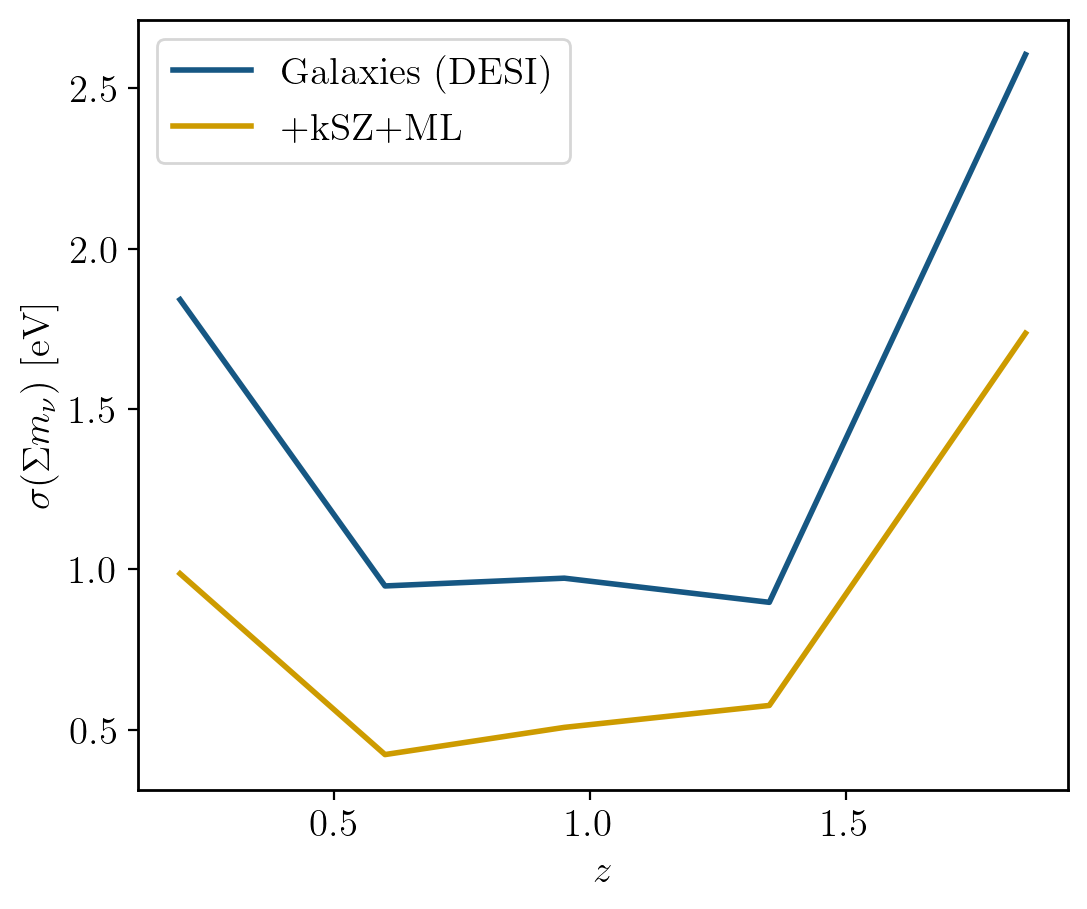

In [41]:

mnu_ind = free_params.index('mnu')
sig_mnu_DESI_bins = np.zeros(len(zs_DESI))
sig_mnu_DESI_kSZ_bins = np.zeros(len(zs_DESI))
for i in range(len(zs_DESI)):
    covmat_gal_z, cov_params = covariance_mat(Fz_XX_DESI[i], free_params, fixed_params, {})
    sig_mnu_DESI_bins[i] = np.sqrt(covmat_gal_z[mnu_ind,mnu_ind])
    covmat_gal_kSZ_z, cov_params = covariance_mat(Fz_vX_DESI[i], free_params, ['bg'], {})
    sig_mnu_DESI_kSZ_bins[i] = np.sqrt(covmat_gal_kSZ_z[mnu_ind,mnu_ind])

plt.plot(zs_DESI, sig_mnu_DESI_bins, label='Galaxies (DESI)')
plt.plot(zs_DESI, sig_mnu_DESI_kSZ_bins, label='+kSZ+ML')
plt.legend()
plt.xlabel(r'$z$')
plt.ylabel(r'$\sigma(\Sigma m_\nu)$ [eV]')

From now on the plots are not updated

## Vary $\Delta_T$ for VRO10

In [24]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_pr = np.zeros(len(Delta_Ts))

bias_list = ['m', 'q', 'brsd', 'b_par', 'b_perp', 'b2']

In [25]:

ARCMIN_TO_RAD = 1./60.*np.pi/180.

fsky=0.4

deltas = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 3e-1, 3e-1, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
survey = 'VRO10'
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'm', 'q', 'brsd', 'b_par', 'b_perp', 'b2']

F_XX_t = []
F_vX_t = []

zs = np.array([0.2,0.7,1.3,1.9,2.6])
bgs = np.array([1.05,1.37,1.79,2.22,2.74])
ngs = np.array([5e-2,2e-2,6e-3,15e-4,3e-4])
vs = (np.array([5.2,43.6,75.9,89.3,119.9])*u.Gpc**3).to(u.Mpc**3)

for t in range(len(Delta_Ts)):
    
    Fz_XX=np.zeros((len(zs),len(free_params),len(free_params)))
    Fz_vX=np.zeros((len(zs),len(free_params),len(free_params)))
    for i in range(len(zs)):
        xx,vx = Fisher_mat(zs[i], cosmo_params, bias_params, free_params, deltas, k_large, mu_L, ngs[i], survey, Delta_Ts[t], vs[i])
        Fz_XX[i,:,:]=xx
        Fz_vX[i,:,:]=vx
        
    F_vX_t.append(np.sum(Fz_vX, axis=0))
    F_XX_t.append(np.sum(Fz_XX, axis=0))

    
with open(fisher_root+'F_vX_DeltaT_VRO10.pkl', 'wb') as file: 
    pickle.dump(F_vX_t, file)
    
with open(fisher_root+'F_XX_DeltaT_VRO10.pkl', 'wb') as file: 
    pickle.dump(F_XX_t, file)

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  13  iterations.
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_98761/178138316.py:134: RuntimeWarning: divide by zero encountered in divide
  N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_98761/178138316.py:136: RuntimeWarning: divide by zero encountered in power
  N_vv_ML = (np.sqrt(1-new_resize_muL**2))**-2 * Nvv_perp # Mpc^3




Now simulating for (1+delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is par

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first



Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (ear

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)






Now simulating for (1+delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (ea

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this is parameter #8 (o

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now s



Now simulating for (1-delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earlie

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is paramet

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest 



Now simulating for (1+delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is para

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts 



Now simulating for (1-delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  14  iterations.
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have be

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  16  iterations.
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: r

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first



Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-so

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


No



Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earli

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)





Now simulating for (1+delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earlie

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out o

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


N



Now simulating for (1-delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorte

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_perp, this is 

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earlie



Now simulating for (1+delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-so

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  17  iterations.
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have bee

Bisection search converged in  13  iterations.
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now s



Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorte

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parame

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)





Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earlie

(0.01, 0.06)

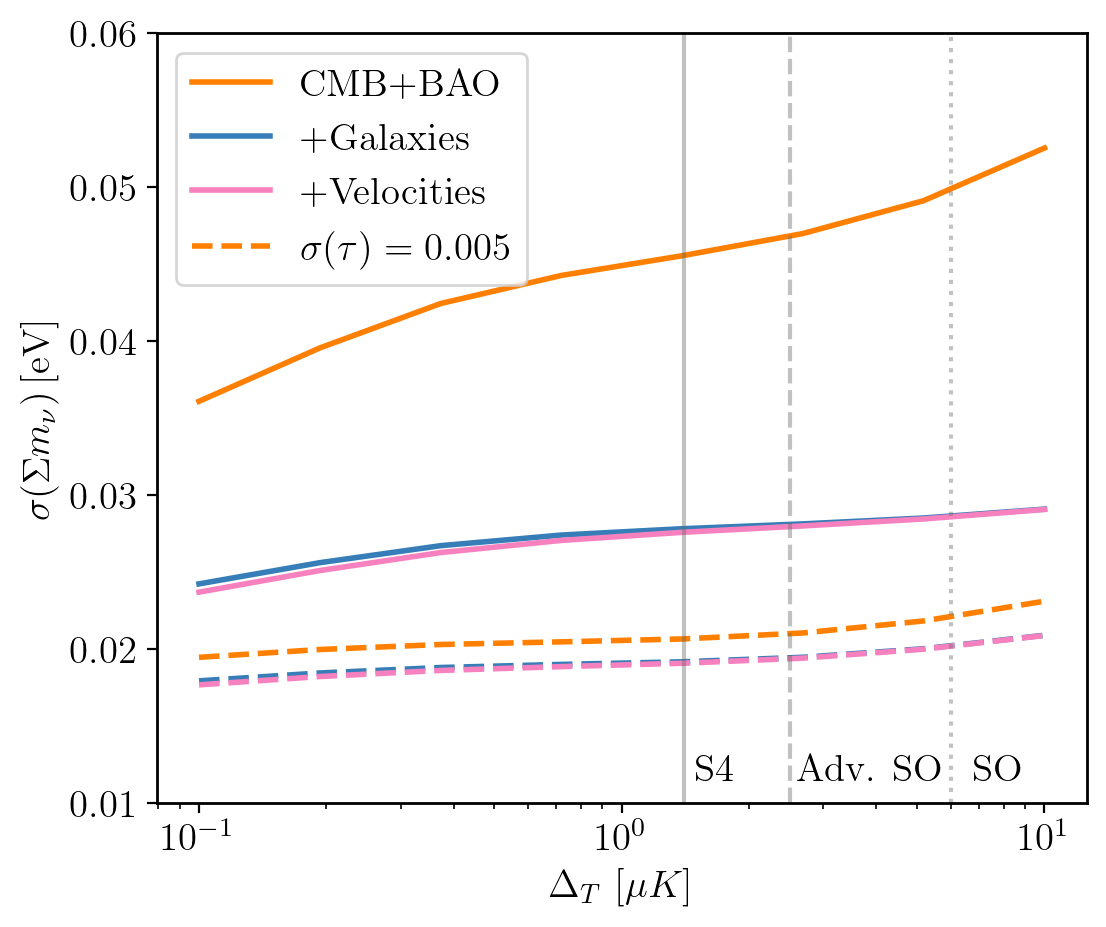

In [32]:

fixed_params = ['b_par', 'b_perp']

for t in range(len(Delta_Ts)):
    F_bao_CMB_L = np.zeros((len(free_params), len(free_params)))
    #F_S4_t = F_CMB_DT['fisherNonGaussian_delensed'][t]*fsky
    F_S4_t = F_CMB_DT['fisherNonGaussian_lensed'][t]*fsky
    #F_S4_t = F_CMB_DT['fisherGaussian'][t]['lensed']*fsky
    F_CMB_DT
    F_S4_t = np.delete(F_S4_t, -1, axis=0)
    F_S4_t = np.delete(F_S4_t, -1, axis=1)
    F_bao_CMB_L[:7,:7] = F_S4_t
    F_bao_L = np.zeros((len(free_params), len(free_params)))
    F_bao_L[:7,:7] = F_bao
    F_planck_lowell_L = np.zeros((len(free_params), len(free_params)))
    F_planck_lowell_L[:7,:7] = F_planck_lowell
    F_bao_CMB_DT = F_bao_CMB_L + F_bao_L + F_planck_lowell_L
    cov, covp = covariance_mat(F_bao_CMB_DT, free_params, bias_list, {})
    sig_mnu_DT[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    cov, covp = covariance_mat(F_bao_CMB_DT, free_params, bias_list, {'tau':0.005})
    sig_mnu_DT_pr[t] = np.sqrt(cov[mnu_ind,mnu_ind])
                
    F_vX = F_vX_t[t]
    F_XX = F_XX_t[t]
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_DT+F_XX, free_params, fixed_params+['brsd'], {})
    sig_mnu_gal_DT[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_DT+F_vX, free_params, ['brsd'], {})
    sig_mnu_gal_vel_DT[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_DT+F_XX, free_params, fixed_params+['brsd'], {'tau':0.005})
    sig_mnu_gal_DT_pr[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_DT+F_vX, free_params, ['brsd'], {'tau':0.005})
    sig_mnu_gal_vel_DT_pr[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])



plt.plot(Delta_Ts, sig_mnu_DT, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_gal_DT, label='+Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_DT_pr, label=r'$\sigma(\tau)=0.005$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_pr, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 0.011, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 0.011, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 0.011, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.ylim(0.01,0.06)



(0.01, 0.06)

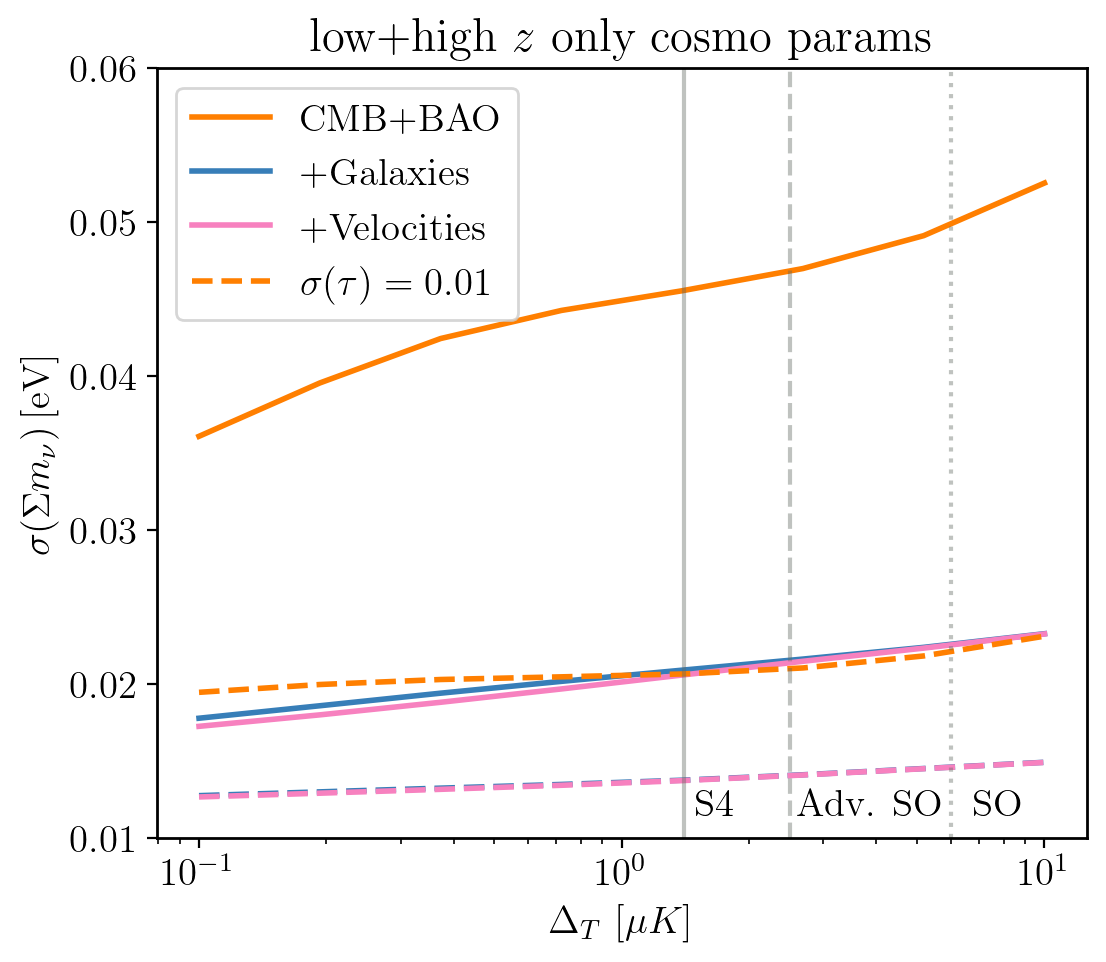

In [37]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_pr = np.zeros(len(Delta_Ts))

bias_list = ['m', 'q', 'brsd', 'b_par', 'b_perp', 'b2']
fixed_params = ['b_par', 'b_perp']

bpar_pr = 0.005

for t in range(len(Delta_Ts)):
    #F_S4_t = data['fisherNonGaussian_delensed'][t]*fsky
    F_S4_t = F_CMB_DT['fisherNonGaussian_lensed'][t]*fsky
    #F_S4_t = F_CMB_DT['fisherGaussian'][t]['lensed']*fsky
    F_S4_t = np.delete(F_S4_t, -1, axis=0)
    F_S4_t = np.delete(F_S4_t, -1, axis=1)
    F_bao_CMB_L[:7,:7] = F_S4_t
    F_bao_L = np.zeros((len(free_params), len(free_params)))
    F_bao_L[:7,:7] = F_bao
    F_planck_lowell_L = np.zeros((len(free_params), len(free_params)))
    F_planck_lowell_L[:7,:7] = F_planck_lowell
    F_bao_CMB_DT = F_bao_CMB_L + F_bao_L + F_planck_lowell_L
    cov, covp = covariance_mat(F_bao_CMB_DT, free_params, bias_list, {})
    sig_mnu_DT[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    cov, covp = covariance_mat(F_bao_CMB_DT, free_params, bias_list, {'tau':0.005})
    sig_mnu_DT_pr[t] = np.sqrt(cov[mnu_ind,mnu_ind])
                
    F_vX = F_vX_t[t]
    F_XX = F_XX_t[t]
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_DT+F_XX, free_params, fixed_params+bias_list, {})
    sig_mnu_gal_DT[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_DT+F_vX, free_params, bias_list, {'b_par':bpar_pr})
    sig_mnu_gal_vel_DT[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_DT+F_XX, free_params, fixed_params+bias_list, {'tau':0.005})
    sig_mnu_gal_DT_pr[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_DT+F_vX, free_params, bias_list, {'tau':0.005,'b_par':bpar_pr})
    sig_mnu_gal_vel_DT_pr[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])

    
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_DT, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_gal_DT, label='+Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_DT_pr, label=r'$\sigma(\tau)=0.01$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_pr, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 0.011, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 0.011, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 0.011, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'low+high $z$ only cosmo params')
plt.ylim(0.01,0.06)



Text(0.5, 1.0, '1\\% prior on $b_\\parallel$')

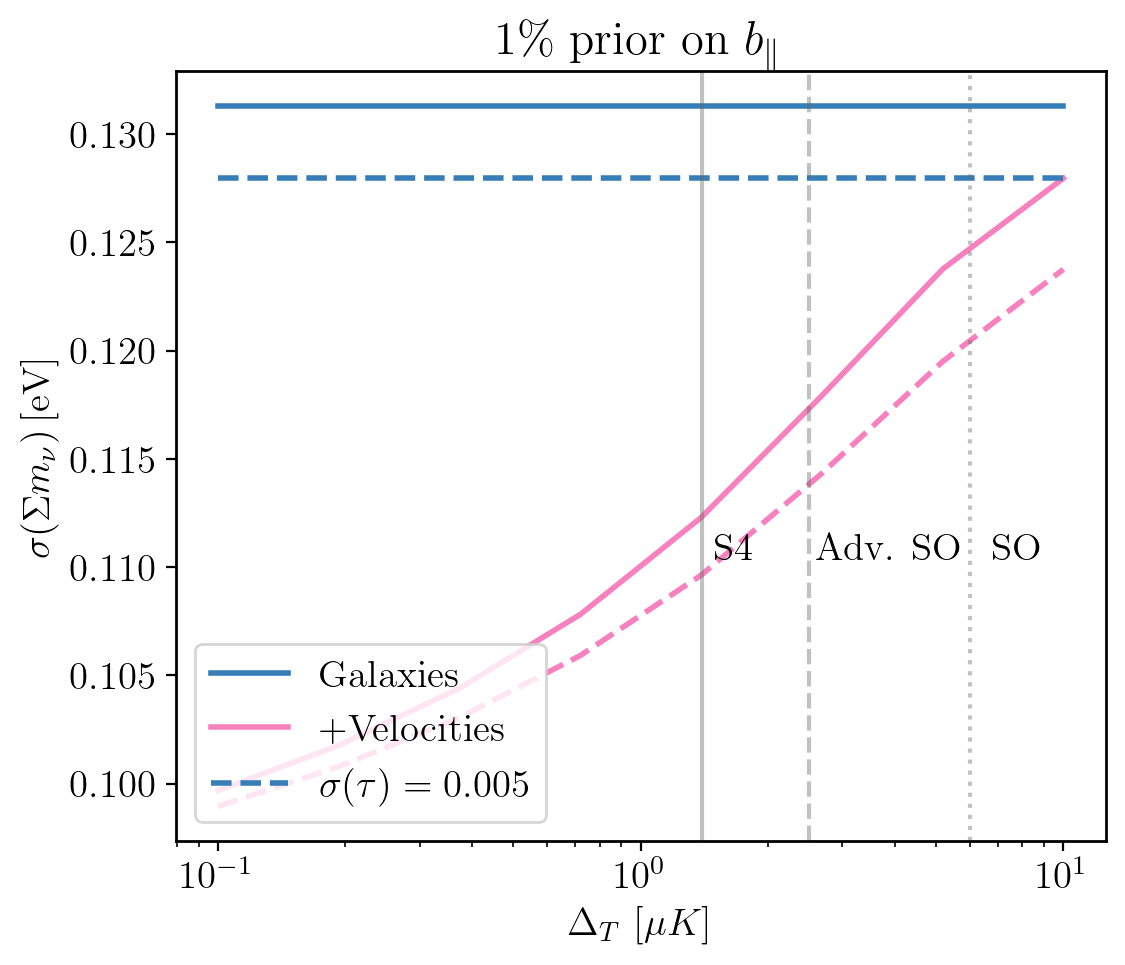

In [72]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_pr = np.zeros(len(Delta_Ts))

bias_list = ['m', 'q', 'brsd', 'b_par', 'b_perp', 'b2']
fixed_params = ['b_par', 'b_perp']

bpar_pr = 0.01

for t in range(len(Delta_Ts)):
                
    F_vX = F_vX_t[t]
    F_XX = F_XX_t[t]
    
    covmat_gal, cov_params = covariance_mat(F_XX, free_params, fixed_params+['brsd'], {})
    sig_mnu_gal_DT[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_vX, free_params, ['brsd'], {'b_par':bpar_pr})
    sig_mnu_gal_vel_DT[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_XX, free_params, fixed_params+['brsd'], {'tau':0.005})
    sig_mnu_gal_DT_pr[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_vX, free_params, ['brsd'], {'tau':0.005,'b_par':bpar_pr})
    sig_mnu_gal_vel_DT_pr[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])


plt.plot(Delta_Ts, sig_mnu_gal_DT, label='Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr, label=r'$\sigma(\tau)=0.005$', color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_pr, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 0.11, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 0.11, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 0.11, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend(loc=3)
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'1\% prior on $b_\parallel$')
#plt.ylim(0.05,0.15)

(0.08, 0.35)

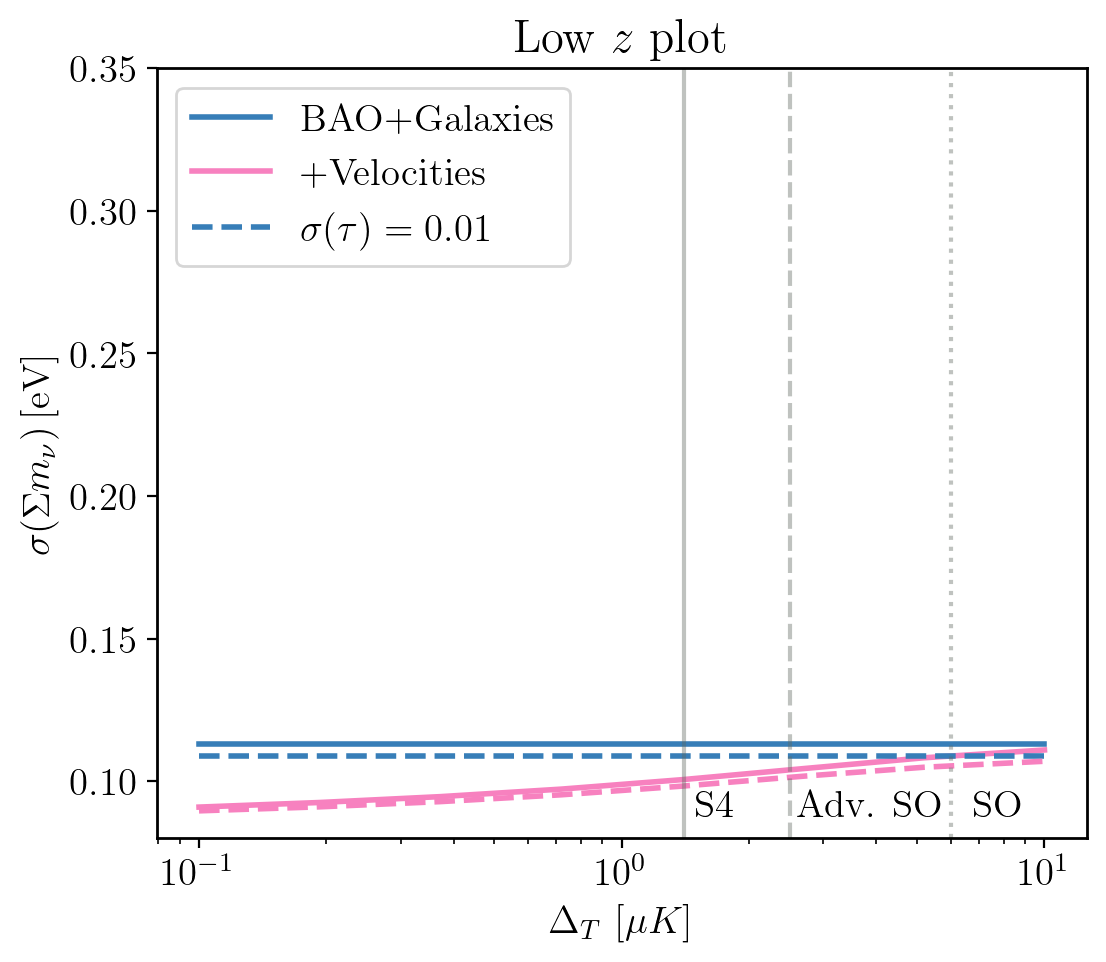

In [73]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_pr = np.zeros(len(Delta_Ts))

bias_list = ['m', 'q', 'brsd', 'b_par', 'b_perp', 'b2']
fixed_params = ['brsd', 'b_par', 'b_perp']


for t in range(len(Delta_Ts)):
                
    F_vX = F_vX_t[t]
    F_XX = F_XX_t[t]
    
    covmat_gal, cov_params = covariance_mat(F_bao_L+F_XX, free_params, fixed_params+[], {})
    sig_mnu_gal_DT[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_L+F_vX, free_params, ['brsd'], {})
    sig_mnu_gal_vel_DT[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_bao_L+F_XX, free_params, fixed_params+[], {'tau':0.01})
    sig_mnu_gal_DT_pr[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_L+F_vX, free_params, ['brsd'], {'tau':0.01})
    sig_mnu_gal_vel_DT_pr[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])

    
plt.plot(Delta_Ts, sig_mnu_gal_DT, label='BAO+Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr, label=r'$\sigma(\tau)=0.01$', color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_pr, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 0.085, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 0.085, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 0.085, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'Low $z$ plot')
plt.ylim(0.08,0.35)

(0.01, 0.06)

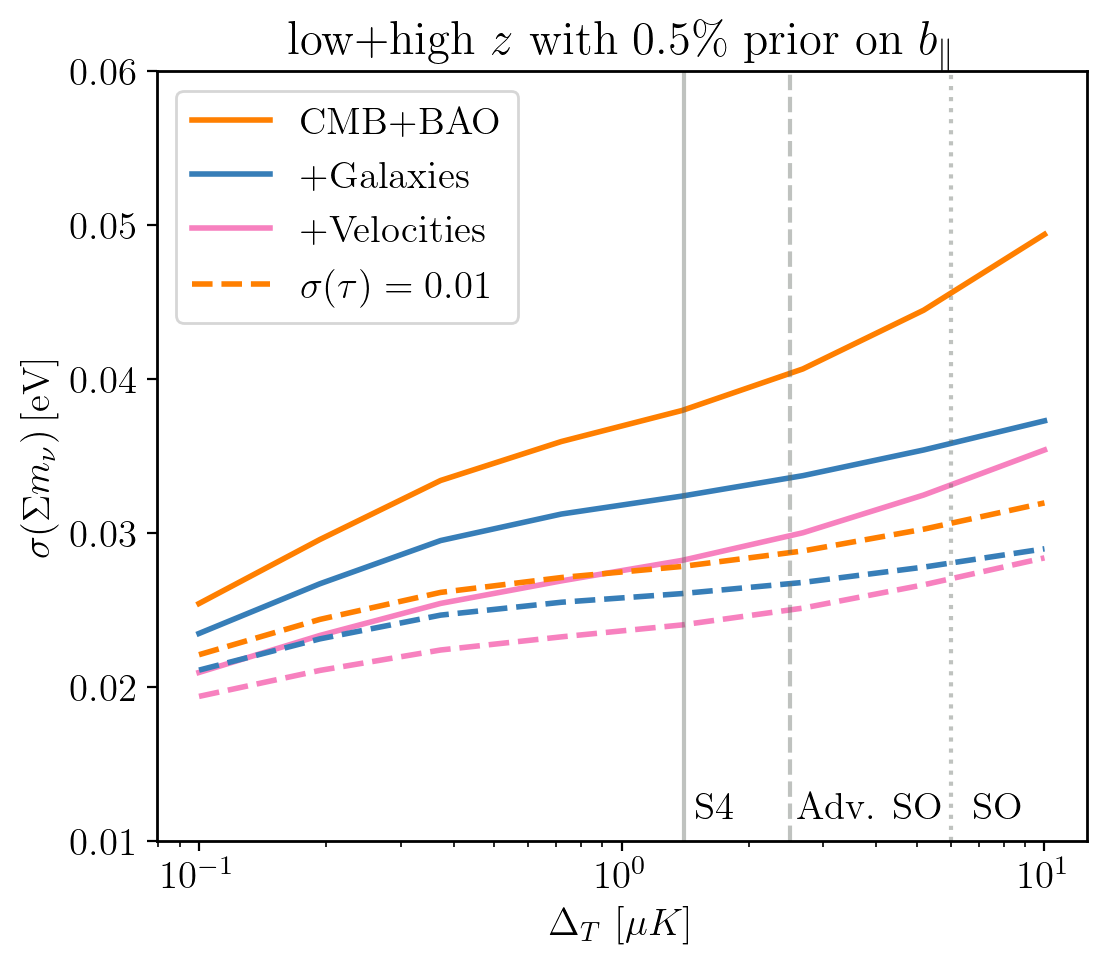

In [330]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_pr = np.zeros(len(Delta_Ts))

bias_list = ['m', 'q', 'brsd', 'b_par', 'b_perp', 'b2']
fixed_params = ['brsd', 'b_par', 'b_perp']

bpar_pr = 0.005

for t in range(len(Delta_Ts)):
    #F_S4_t = data['fisherNonGaussian_delensed'][t]*fsky
    F_S4_t = F_CMB_DT['fisherGaussian'][t]['lensed']*fsky
    F_S4_t = np.delete(F_S4_t, -1, axis=0)
    F_S4_t = np.delete(F_S4_t, -1, axis=1)
    F_bao_CMB_L[:7,:7] = F_S4_t
    F_bao_L = np.zeros((len(free_params), len(free_params)))
    F_bao_L[:7,:7] = F_bao
    F_planck_lowell_L = np.zeros((len(free_params), len(free_params)))
    F_planck_lowell_L[:7,:7] = F_planck_lowell
    F_bao_CMB_DT = F_bao_CMB_L + F_bao_L + F_planck_lowell_L
    cov, covp = covariance_mat(F_bao_CMB_DT, free_params, bias_list, {})
    sig_mnu_DT[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    cov, covp = covariance_mat(F_bao_CMB_DT, free_params, bias_list, {'tau':0.01})
    sig_mnu_DT_pr[t] = np.sqrt(cov[mnu_ind,mnu_ind])
                
    F_vX = F_vX_t[t]
    F_XX = F_XX_t[t]
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_DT+F_XX, free_params, fixed_params+[], {})
    sig_mnu_gal_DT[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_DT+F_vX, free_params, ['brsd'], {'b_par':bpar_pr})
    sig_mnu_gal_vel_DT[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_DT+F_XX, free_params, fixed_params+[], {'tau':0.01})
    sig_mnu_gal_DT_pr[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_DT+F_vX, free_params, ['brsd'], {'tau':0.01,'b_par':bpar_pr})
    sig_mnu_gal_vel_DT_pr[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])

    
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_DT, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_gal_DT, label='+Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_DT_pr, label=r'$\sigma(\tau)=0.01$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_pr, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 0.011, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 0.011, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 0.011, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'low+high $z$ with 0.5\% prior on $b_\parallel$')
plt.ylim(0.01,0.06)



(0.01, 0.06)

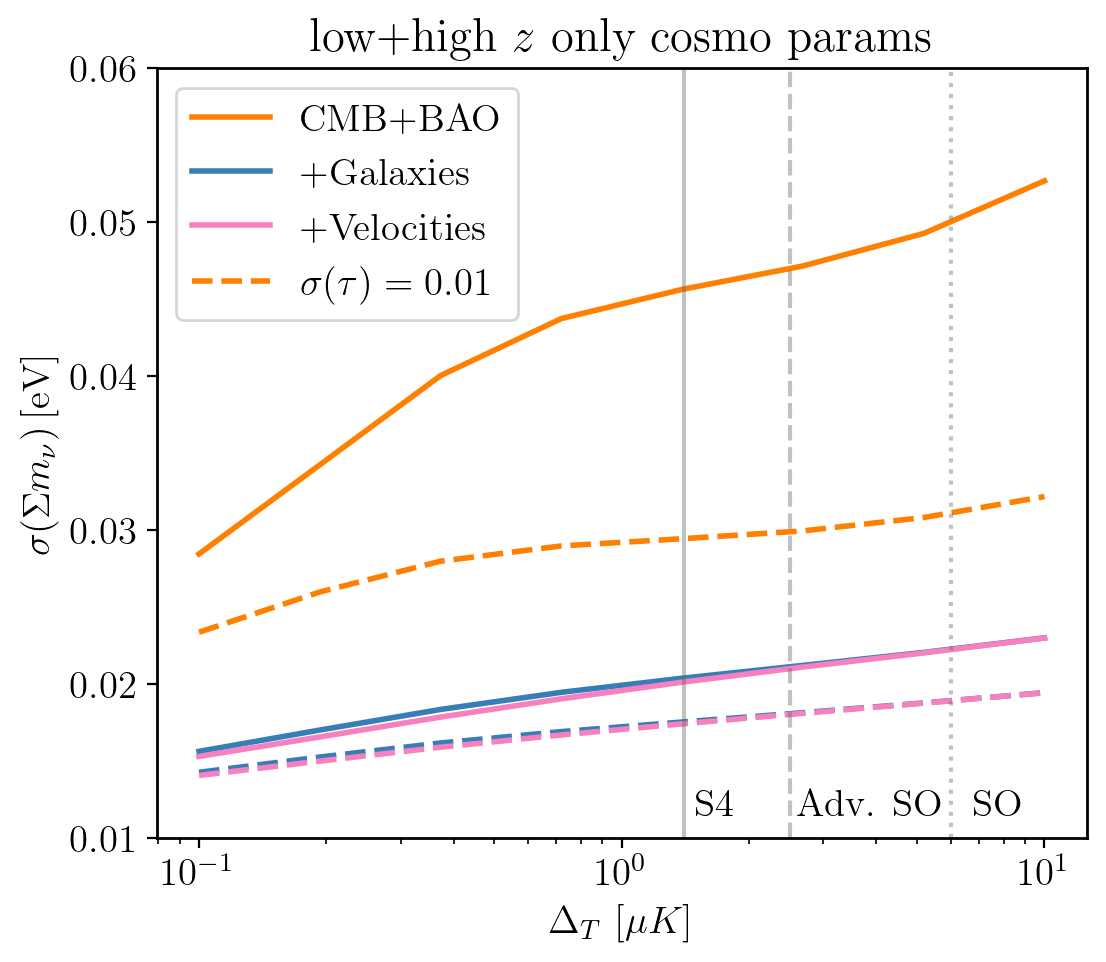

In [80]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_pr = np.zeros(len(Delta_Ts))

bias_list = ['m', 'q', 'brsd', 'b_par', 'b_perp', 'b2']
fixed_params = ['b_par', 'b_perp']

bpar_pr = 0.005

for t in range(len(Delta_Ts)):
    #F_S4_t = data['fisherNonGaussian_delensed'][t]*fsky
    F_S4_t = F_CMB_DT['fisherNonGaussian_lensed'][t]*fsky
    #F_S4_t = F_CMB_DT['fisherGaussian'][t]['lensed']*fsky
    F_S4_t = np.delete(F_S4_t, -1, axis=0)
    F_S4_t = np.delete(F_S4_t, -1, axis=1)
    F_bao_CMB_L[:7,:7] = F_S4_t
    F_bao_L = np.zeros((len(free_params), len(free_params)))
    F_bao_L[:7,:7] = F_bao
    F_planck_lowell_L = np.zeros((len(free_params), len(free_params)))
    F_planck_lowell_L[:7,:7] = F_planck_lowell
    F_bao_CMB_DT = F_bao_CMB_L + F_bao_L + F_planck_lowell_L
    cov, covp = covariance_mat(F_bao_CMB_DT, free_params, bias_list, {})
    sig_mnu_DT[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    cov, covp = covariance_mat(F_bao_CMB_DT, free_params, bias_list, {'tau':0.01})
    sig_mnu_DT_pr[t] = np.sqrt(cov[mnu_ind,mnu_ind])
                
    F_vX = F_vX_t[t]
    F_XX = F_XX_t[t]
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_DT+F_XX, free_params, fixed_params+bias_list, {})
    sig_mnu_gal_DT[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_DT+F_vX, free_params, bias_list, {'b_par':bpar_pr})
    sig_mnu_gal_vel_DT[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_DT+F_XX, free_params, fixed_params+bias_list, {'tau':0.01})
    sig_mnu_gal_DT_pr[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_DT+F_vX, free_params, bias_list, {'tau':0.01,'b_par':bpar_pr})
    sig_mnu_gal_vel_DT_pr[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])

    
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_DT, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_gal_DT, label='+Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_DT_pr, label=r'$\sigma(\tau)=0.01$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_pr, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 0.011, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 0.011, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 0.011, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'low+high $z$ only cosmo params')
plt.ylim(0.01,0.06)



## Vary $\theta_\mathrm{FWHM}$

In [416]:
mnu_ind = free_params.index('mnu')
sig_mnu_f = np.zeros(len(fwhms))
sig_mnu_gal_f = np.zeros(len(fwhms))
sig_mnu_gal_vel_f = np.zeros(len(fwhms))
sig_mnu_f_pr = np.zeros(len(fwhms))
sig_mnu_gal_f_pr = np.zeros(len(fwhms))
sig_mnu_gal_vel_f_pr = np.zeros(len(fwhms))

bias_list = ['m', 'q', 'brsd', 'b_par', 'b_perp', 'b2']

ARCMIN_TO_RAD = 1./60.*np.pi/180.

fsky=0.4

deltas = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 3e-1, 3e-1, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
survey = 'VRO10'
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'm', 'q', 'brsd', 'b_par', 'b_perp', 'b2']

F_XX_t = []
F_vX_t = []

zs = np.array([0.2,0.7,1.3,1.9,2.6])
bgs = np.array([1.05,1.37,1.79,2.22,2.74])
ngs = np.array([5e-2,2e-2,6e-3,15e-4,3e-4])
vs = (np.array([5.2,43.6,75.9,89.3,119.9])*u.Gpc**3).to(u.Mpc**3)

for t in range(len(fwhms)):
    
    Fz_XX=np.zeros((len(zs),len(free_params),len(free_params)))
    Fz_vX=np.zeros((len(zs),len(free_params),len(free_params)))
    for i in range(len(zs)):
        xx,vx = Fisher_mat(zs[i], cosmo_params, bias_params, free_params, deltas, k_large, mu_L, ngs[i], survey, Delta_T_S4, fwhms[t], vs[i])
        Fz_XX[i,:,:]=xx
        Fz_vX[i,:,:]=vx
        
    F_vX_t.append(np.sum(Fz_vX, axis=0))
    F_XX_t.append(np.sum(Fz_XX, axis=0))


Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  13  iterations.


/Users/user1/Desktop/Codes/hmvec-ksz-dev/hmvec/hod.py:138: RuntimeWarning: invalid value encountered in divide
  ret = Ns ** 2.0 / Nc
/Users/user1/Desktop/Codes/hmvec-ksz-dev/hmvec/hod.py:166: RuntimeWarning: invalid value encountered in divide
  ret = Ns ** 3.0 / Nc ** 2.0
/Users/user1/Desktop/Codes/hmvec-ksz-dev/hmvec/hod.py:218: RuntimeWarning: invalid value encountered in divide
  ret = Ns ** 2.0 / Nc
/Users/user1/Desktop/Codes/hmvec-ksz-dev/hmvec/fft.py:127: RuntimeWarning: invalid value encountered in divide
  uk = ukts / kts[None, None, :] / mnorm[..., None]
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_80785/2432360927.py:89: RuntimeWarning: divide by zero encountered in divide
  N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_80785/2432360927.py:91: RuntimeWarning: divide by zero encountered in power
  N_vv_ML = (np.sqrt(1-new_resize_



Now simulating for (1+delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_p

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  13  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of



Now simulating for (1-delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, th



Now simulating for (1+delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  13  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 



Now simulating for (1-delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this i



Now simulating for (1+delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  13  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out



Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this



Now simulating for (1+delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  13  iterations.


Now simulating for (1+delta)H0, this is parameter #1



Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu,



Now simulating for (1+delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshift



Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)



Now simulating for (1+delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delt



Now simulating for (1+delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  16  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest fi

/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_80785/3071637708.py:32: RuntimeWarning: overflow encountered in exp
  return s**2*np.exp((ell*(ell+1)*(th_FWHM**2))/(8*np.log(2)))




Now simulating for (1+delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt

(0.08, 0.35)

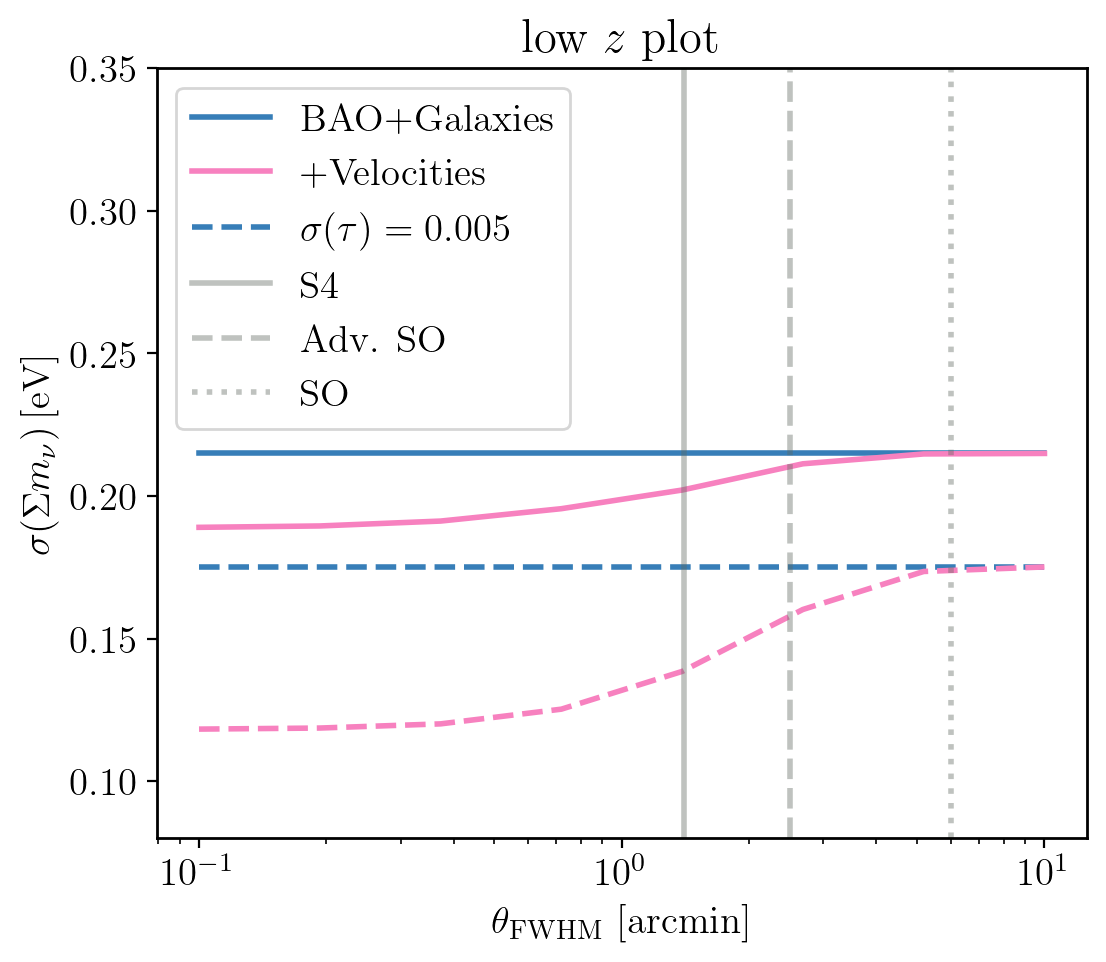

In [432]:
mnu_ind = free_params.index('mnu')
sig_mnu_f = np.zeros(len(fwhms))
sig_mnu_gal_f = np.zeros(len(fwhms))
sig_mnu_gal_vel_f = np.zeros(len(fwhms))
sig_mnu_f_pr = np.zeros(len(fwhms))
sig_mnu_gal_f_pr = np.zeros(len(fwhms))
sig_mnu_gal_vel_f_pr = np.zeros(len(fwhms))

bias_list = ['m', 'q', 'brsd', 'b_par', 'b_perp', 'b2']
fixed_params = ['brsd', 'b_par', 'b_perp']

bpar_pr = 1000.005

for t in range(len(fwhms)):
    F_bao_L = np.zeros((len(free_params), len(free_params)))
    F_bao_L[:7,:7] = F_bao
    
    F_vX = F_vX_t[t]
    F_XX = F_XX_t[t]
    
    covmat_gal, cov_params = covariance_mat(F_bao_L+F_XX, free_params, fixed_params+[], {})
    sig_mnu_gal_f[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_L+F_vX, free_params, ['brsd'], {'b_par':bpar_pr})
    sig_mnu_gal_vel_f[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_bao_L+F_XX, free_params, fixed_params+[], {'tau':0.005})
    sig_mnu_gal_f_pr[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_L+F_vX, free_params, ['brsd'], {'tau':0.005,'b_par':bpar_pr})
    sig_mnu_gal_vel_f_pr[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])

    
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_gal_f, label='BAO+Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_vel_f, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_gal_f_pr, label=r'$\sigma(\tau)=0.005$', color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_vel_f_pr, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], label = 'S4', alpha=0.4)
plt.axvline(x = 2.5, color = palette[4], label = 'Adv. SO', alpha=0.4, ls='--')
plt.axvline(x = 6., color = palette[4], label = 'SO', alpha=0.4, ls=':')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\theta_\mathrm{FWHM}$ [arcmin]')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'low $z$ plot')
plt.ylim(0.08,0.35)



(0.01, 0.06)

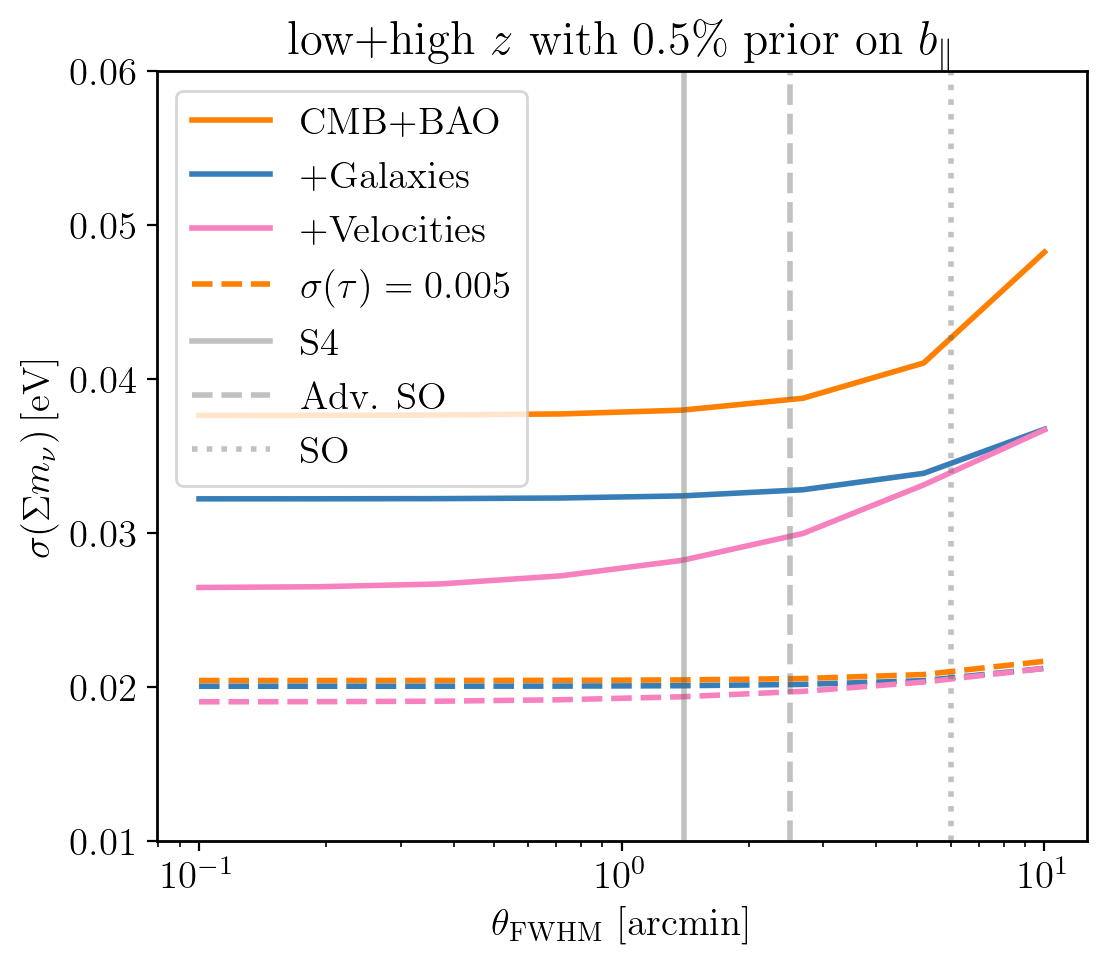

In [425]:
mnu_ind = free_params.index('mnu')
sig_mnu_f = np.zeros(len(fwhms))
sig_mnu_gal_f = np.zeros(len(fwhms))
sig_mnu_gal_vel_f = np.zeros(len(fwhms))
sig_mnu_f_pr = np.zeros(len(fwhms))
sig_mnu_gal_f_pr = np.zeros(len(fwhms))
sig_mnu_gal_vel_f_pr = np.zeros(len(fwhms))

bias_list = ['m', 'q', 'brsd', 'b_par', 'b_perp', 'b2']
fixed_params = ['brsd', 'b_par', 'b_perp']

bpar_pr = 0.005

for t in range(len(fwhms)):
    F_CMB_L = np.zeros((len(free_params), len(free_params)))
    #F_S4_t = data['fisherNonGaussian_delensed'][t]*fsky
    F_S4_t = F_CMB_f['fisherGaussian'][t]['lensed']*fsky
    F_S4_t = np.delete(F_S4_t, -1, axis=0)
    F_S4_t = np.delete(F_S4_t, -1, axis=1)
    F_CMB_L[:7,:7] = F_S4_t
    F_bao_L = np.zeros((len(free_params), len(free_params)))
    F_bao_L[:7,:7] = F_bao
    F_planck_lowell_L = np.zeros((len(free_params), len(free_params)))
    F_planck_lowell_L[:7,:7] = F_planck_lowell
    F_bao_CMB_f = F_CMB_L + F_bao_L + F_planck_lowell_L
    cov, covp = covariance_mat(F_bao_CMB_f, free_params, bias_list, {})
    sig_mnu_f[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    cov, covp = covariance_mat(F_bao_CMB_f, free_params, bias_list, {'tau':0.005})
    sig_mnu_f_pr[t] = np.sqrt(cov[mnu_ind,mnu_ind])
                
    F_vX = F_vX_t[t]
    F_XX = F_XX_t[t]
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_f+F_XX, free_params, fixed_params+[], {})
    sig_mnu_gal_f[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_f+F_vX, free_params, ['brsd'], {'b_par':bpar_pr})
    sig_mnu_gal_vel_f[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_f+F_XX, free_params, fixed_params+[], {'tau':0.005})
    sig_mnu_gal_f_pr[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_f+F_vX, free_params, ['brsd'], {'tau':0.005,'b_par':bpar_pr})
    sig_mnu_gal_vel_f_pr[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])

    
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_f, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_gal_f, label='+Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_vel_f, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_f_pr, label=r'$\sigma(\tau)=0.005$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_f_pr, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_vel_f_pr, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], label = 'S4', alpha=0.4)
plt.axvline(x = 2.5, color = palette[4], label = 'Adv. SO', alpha=0.4, ls='--')
plt.axvline(x = 6., color = palette[4], label = 'SO', alpha=0.4, ls=':')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\theta_\mathrm{FWHM}$ [arcmin]')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'low+high $z$ with 0.5\% prior on $b_\parallel$')
plt.ylim(0.01,0.06)



(0.01, 0.06)

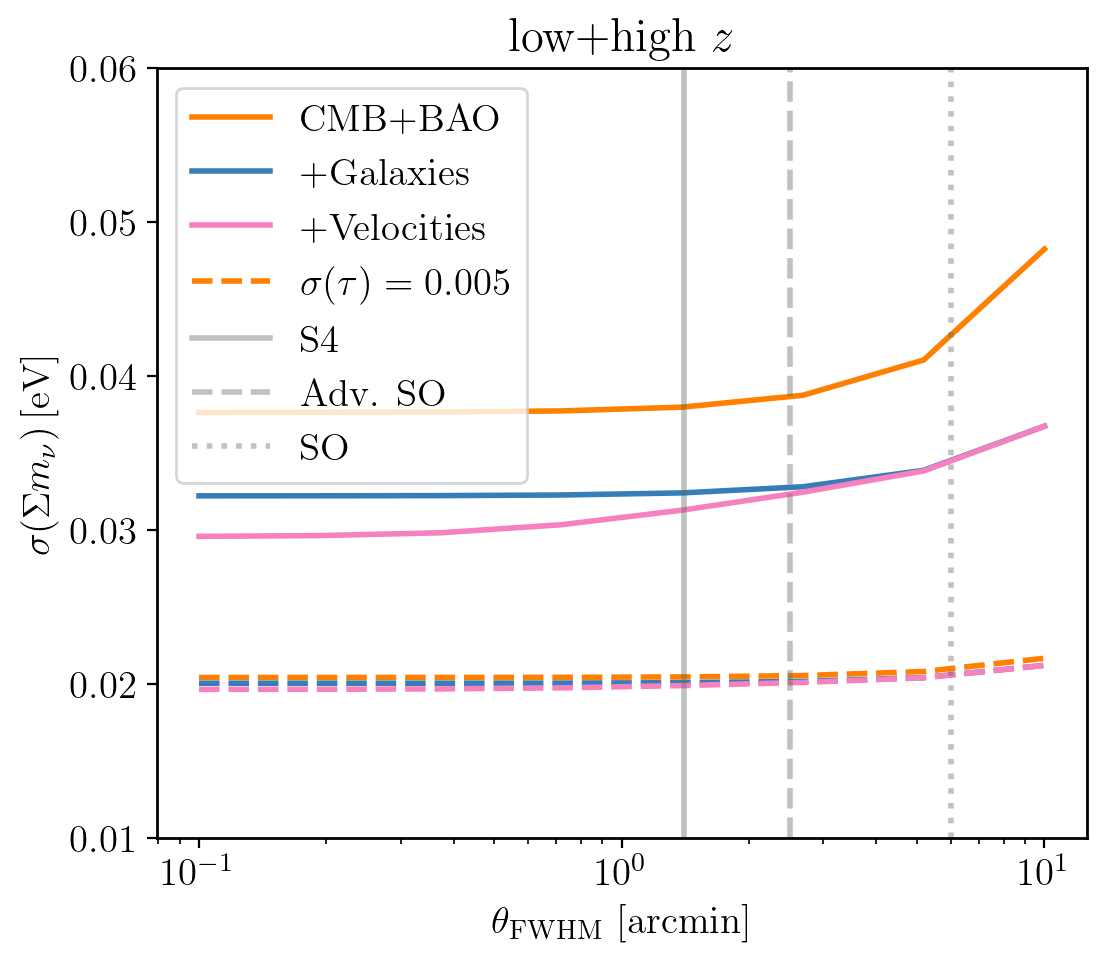

In [426]:
mnu_ind = free_params.index('mnu')
sig_mnu_f = np.zeros(len(fwhms))
sig_mnu_gal_f = np.zeros(len(fwhms))
sig_mnu_gal_vel_f = np.zeros(len(fwhms))
sig_mnu_f_pr = np.zeros(len(fwhms))
sig_mnu_gal_f_pr = np.zeros(len(fwhms))
sig_mnu_gal_vel_f_pr = np.zeros(len(fwhms))

bias_list = ['m', 'q', 'brsd', 'b_par', 'b_perp', 'b2']
fixed_params = ['brsd', 'b_par', 'b_perp']

bpar_pr = 1000.005

for t in range(len(fwhms)):
    F_CMB_L = np.zeros((len(free_params), len(free_params)))
    #F_S4_t = data['fisherNonGaussian_delensed'][t]*fsky
    F_S4_t = F_CMB_f['fisherGaussian'][t]['lensed']*fsky
    F_S4_t = np.delete(F_S4_t, -1, axis=0)
    F_S4_t = np.delete(F_S4_t, -1, axis=1)
    F_CMB_L[:7,:7] = F_S4_t
    F_bao_L = np.zeros((len(free_params), len(free_params)))
    F_bao_L[:7,:7] = F_bao
    F_planck_lowell_L = np.zeros((len(free_params), len(free_params)))
    F_planck_lowell_L[:7,:7] = F_planck_lowell
    F_bao_CMB_f = F_CMB_L + F_bao_L + F_planck_lowell_L
    cov, covp = covariance_mat(F_bao_CMB_f, free_params, bias_list, {})
    sig_mnu_f[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    cov, covp = covariance_mat(F_bao_CMB_f, free_params, bias_list, {'tau':0.005})
    sig_mnu_f_pr[t] = np.sqrt(cov[mnu_ind,mnu_ind])
                
    F_vX = F_vX_t[t]
    F_XX = F_XX_t[t]
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_f+F_XX, free_params, fixed_params+[], {})
    sig_mnu_gal_f[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_f+F_vX, free_params, ['brsd'], {'b_par':bpar_pr})
    sig_mnu_gal_vel_f[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_f+F_XX, free_params, fixed_params+[], {'tau':0.005})
    sig_mnu_gal_f_pr[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_f+F_vX, free_params, ['brsd'], {'tau':0.005,'b_par':bpar_pr})
    sig_mnu_gal_vel_f_pr[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])

    
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_f, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_gal_f, label='+Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_vel_f, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_f_pr, label=r'$\sigma(\tau)=0.005$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_f_pr, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_vel_f_pr, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], label = 'S4', alpha=0.4)
plt.axvline(x = 2.5, color = palette[4], label = 'Adv. SO', alpha=0.4, ls='--')
plt.axvline(x = 6., color = palette[4], label = 'SO', alpha=0.4, ls=':')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\theta_\mathrm{FWHM}$ [arcmin]')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'low+high $z$')
plt.ylim(0.01,0.06)



### Vary $\Delta_T$ for DESI

In [102]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_pr_DESI = np.zeros(len(Delta_Ts))

bias_list = ['bg', 'b_par', 'b_perp', 'b2']

#bias_params['bg'] = bg_DESI
bias1 = bias_params.copy()

fsky=0.4

deltas = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 3e-1, 3e-1, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
survey = 'DESI'
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bg', 'b_par', 'b_perp', 'b2']
fixed_params=['b_par', 'b_perp']

F_XX_t_DESI = []
F_vX_t_DESI = []


for t in range(len(Delta_Ts)):
    
    Fz_XX_DESI = np.zeros((len(zs_DESI),len(free_params)-len(fixed_params)-1,len(free_params)-len(fixed_params)-1))
    Fz_vX_DESI = np.zeros((len(zs_DESI),len(free_params)-1,len(free_params)-1))
    for i in range(len(zs_DESI)):
        bias1['bg'] = bgs_DESI[i]
        xx,vx = Fisher_mat(zs_DESI[i], cosmo_params, bias1, free_params, deltas, k_large, mu_L, ngs_DESI[i], survey, Delta_Ts[t], vs_DESI[i])
        
        cov_xx_DESI, cov_params2 = covariance_mat(xx, free_params, fixed_params, {})
        cov_xx_DESI = np.delete(cov_xx_DESI, bg_ind, axis=0)
        cov_xx_DESI = np.delete(cov_xx_DESI, bg_ind, axis=1)
        Fz_XX_DESI[i,:,:] = np.linalg.inv(cov_xx_DESI)

        cov_vx_DESI, cov_params = covariance_mat(vx, free_params, [], {})
        cov_vx_DESI = np.delete(cov_vx_DESI, bg_ind, axis=0)
        cov_vx_DESI = np.delete(cov_vx_DESI, bg_ind, axis=1)
        Fz_vX_DESI[i,:,:] = np.linalg.inv(cov_vx_DESI)

    F_vX_t_DESI.append(np.sum(Fz_vX_DESI, axis=0))
    F_XX_t_DESI.append(np.sum(Fz_XX_DESI, axis=0))
    

cov_params3 = cov_params2.copy()
cov_params3.remove('bg')

free_params3 = free_params.copy()
free_params3.remove('bg')


Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  15  iterations.


/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_1261/1162831189.py:89: RuntimeWarning: divide by zero encountered in divide
  N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_1261/1162831189.py:91: RuntimeWarning: divide by zero encountered in power
  N_vv_ML = (np.sqrt(1-new_resize_muL**2))**-2 * Nvv_perp # Mpc^3




Now simulating for (1+delta)H0, this is parameter #1 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)b2, this is parameter #11 (out of 11)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  17  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out o



Now simulating for (1+delta)b_perp, this is parameter #10 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #10 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #11 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #11 (out of 11)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  18  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out



Now simulating for (1-delta)bg, this is parameter #8 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #9 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_par, this is parameter #9 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_perp, this is parameter #10 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #10 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #11 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #11 (out of 11)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted 



Now simulating for (1+delta)mnu, this is parameter #7 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bg, this is parameter #8 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bg, this is parameter #8 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #9 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_par, this is parameter #9 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_perp, this is parameter #10 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #10 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (



Now simulating for (1-delta)As, this is parameter #5 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bg, this is parameter #8 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bg, this is parameter #8 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #9 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_p



Now simulating for (1+delta)ns, this is parameter #4 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bg, th



Now simulating for (1-delta)ombh2, this is parameter #2 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)

Bisection search converged in  17  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 11)
Note: redshifts have been re-sorte



Now simulating for (1+delta)b2, this is parameter #11 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #11 (out of 11)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  18  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 



Now simulating for (1-delta)b_par, this is parameter #9 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_perp, this is parameter #10 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #10 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #11 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #11 (out of 11)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  16  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out



Now simulating for (1+delta)bg, this is parameter #8 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bg, this is parameter #8 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #9 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_par, this is parameter #9 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_perp, this is parameter #10 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #10 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #11 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #11 (out of 11)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have b



Now simulating for (1-delta)tau, this is parameter #6 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bg, this is parameter #8 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bg, this is parameter #8 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #9 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_par, this is parameter #9 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_perp, this is parameter #10 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-de



Now simulating for (1+delta)As, this is parameter #5 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bg, this is parameter #8 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bg, this is parameter #8 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par,

(0.1, 0.7)

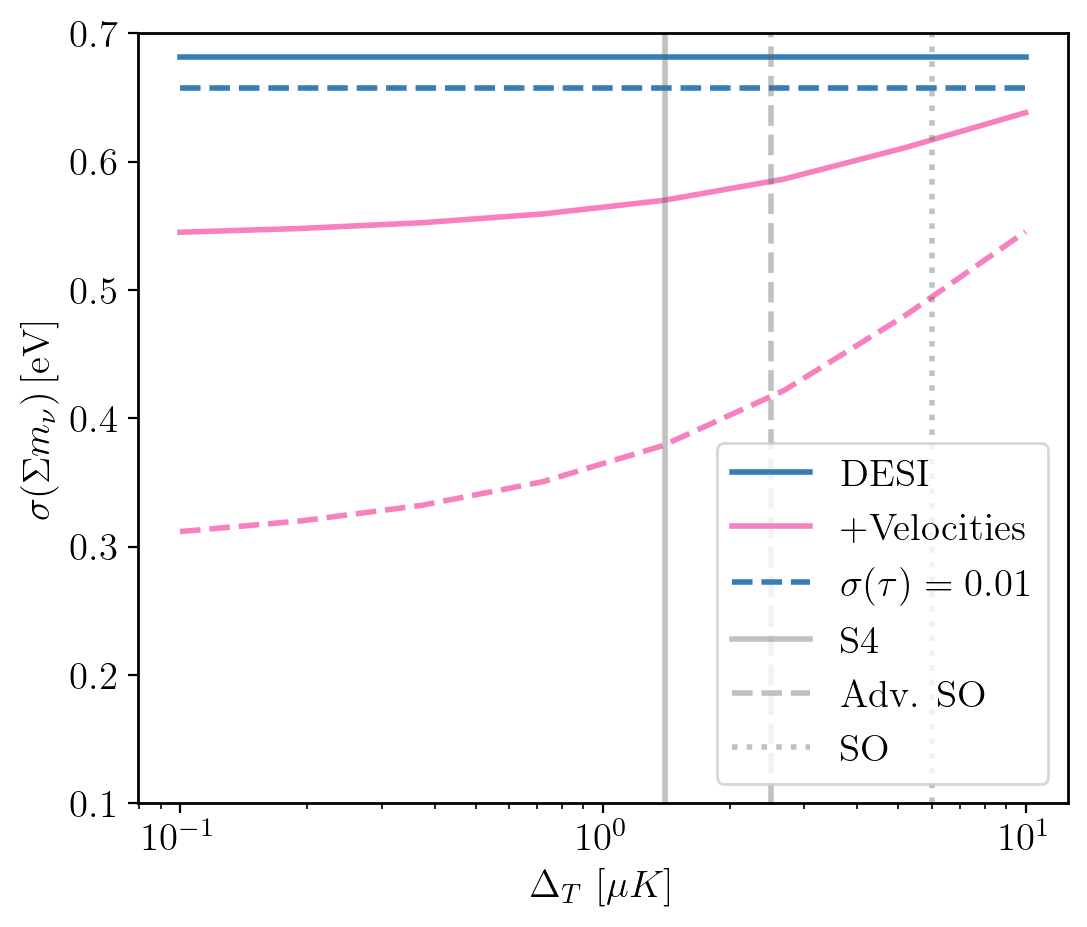

In [112]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_pr_DESI = np.zeros(len(Delta_Ts))

bias_list = ['bg', 'brsd', 'b_par', 'b_perp', 'b2']
fixed_params = ['brsd', 'b_par', 'b_perp']

bpar_pr = 1000.005

for t in range(len(Delta_Ts)):
                
    F_vX = F_vX_t_DESI[t]
    F_XX = F_XX_t_DESI[t]
    
    covmat_gal, cov_params = covariance_mat(F_XX, cov_params3, fixed_params+[], {})
    sig_mnu_gal_DT_DESI[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_vX, free_params3, [], {})
    sig_mnu_gal_vel_DT_DESI[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_XX, cov_params3, fixed_params+[], {'tau':0.01})
    sig_mnu_gal_DT_pr_DESI[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_vX, free_params3, [], {'tau':0.01})
    sig_mnu_gal_vel_DT_pr_DESI[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])

    
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_gal_DT_DESI, label='DESI', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_DESI, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr_DESI, label=r'$\sigma(\tau)=0.01$', color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_pr_DESI, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], label = 'S4', alpha=0.4)
plt.axvline(x = 2.5, color = palette[4], label = 'Adv. SO', alpha=0.4, ls='--')
plt.axvline(x = 6., color = palette[4], label = 'SO', alpha=0.4, ls=':')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
#plt.title(r'low+high $z$')
plt.ylim(0.1,0.7)



(0.1, 0.4)

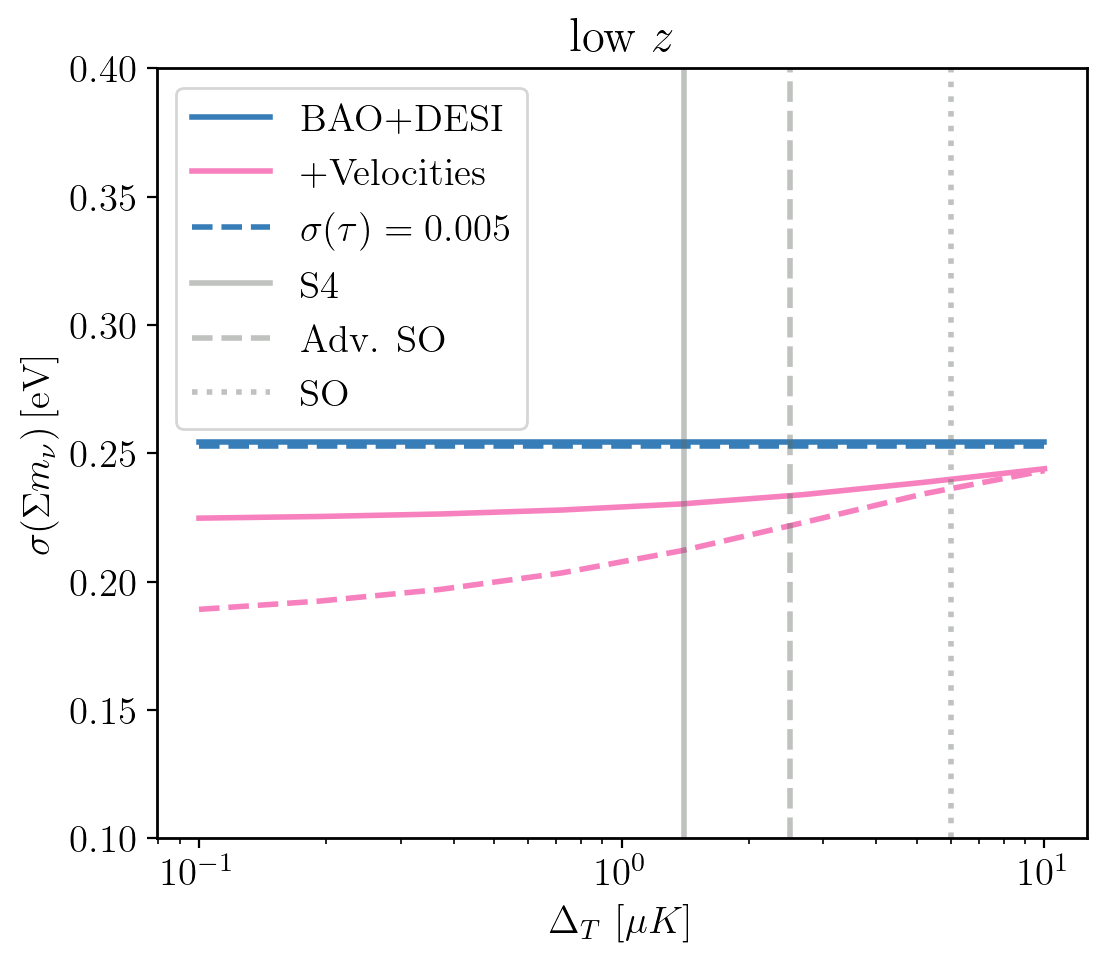

In [116]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_pr_DESI = np.zeros(len(Delta_Ts))

bias_list = ['bg', 'brsd', 'b_par', 'b_perp', 'b2']
fixed_params = ['brsd', 'b_par', 'b_perp']

bpar_pr = 1000.005

for t in range(len(Delta_Ts)):
                
    F_vX = F_vX_t_DESI[t]
    F_XX = F_XX_t_DESI[t]
    
    F_bao_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_bao_L1[:7,:7] = F_bao
    F_bao_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_bao_L2[:7,:7] = F_bao
    
    covmat_gal, cov_params = covariance_mat(F_bao_L1+F_XX, cov_params3, fixed_params+[], {})
    sig_mnu_gal_DT_DESI[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_L2+F_vX, free_params3, [], {})
    sig_mnu_gal_vel_DT_DESI[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_bao_L1+F_XX, cov_params3, fixed_params+[], {'tau':0.01})
    sig_mnu_gal_DT_pr_DESI[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_L2+F_vX, free_params3, [], {'tau':0.01})
    sig_mnu_gal_vel_DT_pr_DESI[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])

    
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_gal_DT_DESI, label='BAO+DESI', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_DESI, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr_DESI, label=r'$\sigma(\tau)=0.005$', color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_pr_DESI, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], label = 'S4', alpha=0.4)
plt.axvline(x = 2.5, color = palette[4], label = 'Adv. SO', alpha=0.4, ls='--')
plt.axvline(x = 6., color = palette[4], label = 'SO', alpha=0.4, ls=':')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'low $z$')
plt.ylim(0.1,0.4)



(0.01, 0.06)

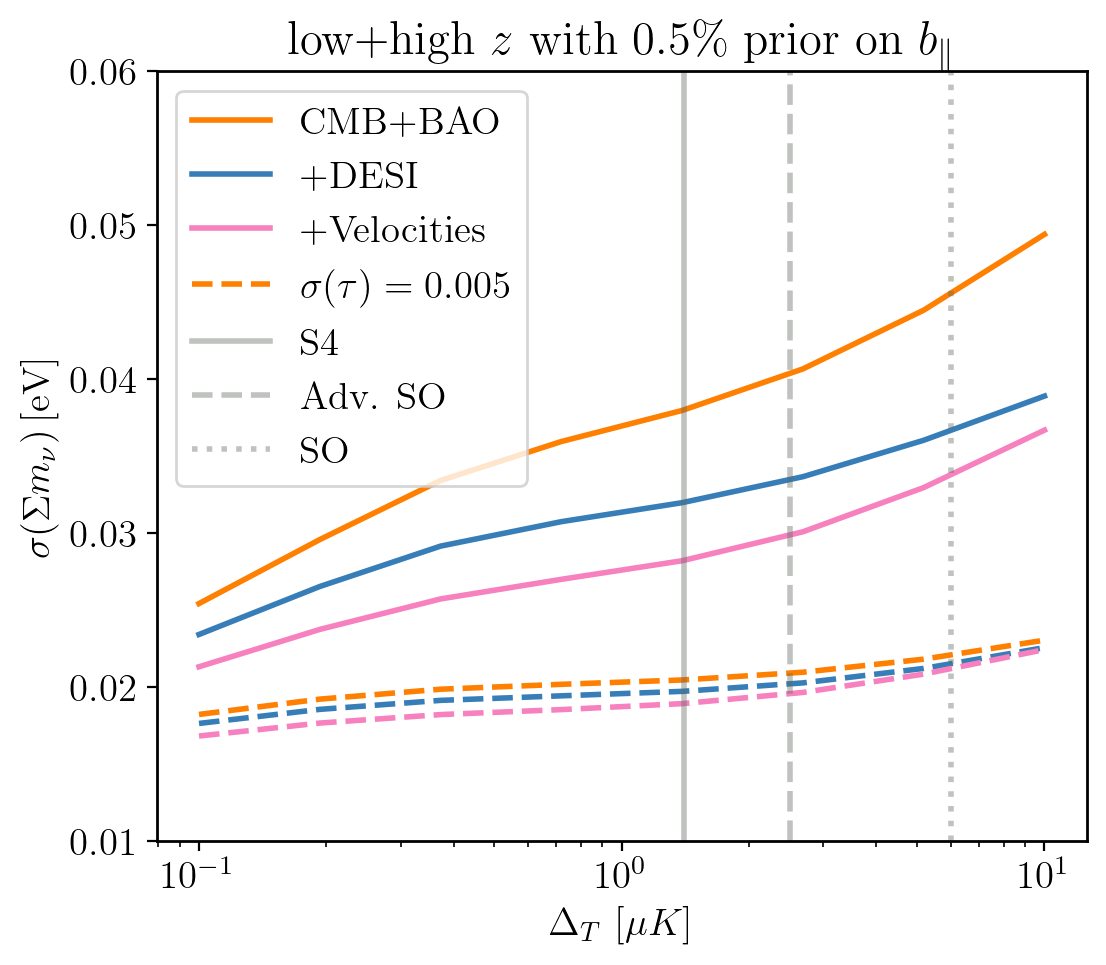

In [114]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_pr_DESI = np.zeros(len(Delta_Ts))

bias_list = ['bg', 'brsd', 'b_par', 'b_perp', 'b2']
fixed_params = ['brsd', 'b_par', 'b_perp']

bpar_pr = 0.005

for t in range(len(Delta_Ts)):
    F_vX = F_vX_t_DESI[t]
    F_XX = F_XX_t_DESI[t]
    
    F_CMB_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_CMB_L2 = np.zeros((len(F_vX), len(F_vX)))
    #F_S4_t = data['fisherNonGaussian_delensed'][t]*fsky
    F_S4_t = F_CMB_DT['fisherGaussian'][t]['lensed']*fsky
    F_S4_t = np.delete(F_S4_t, -1, axis=0)
    F_S4_t = np.delete(F_S4_t, -1, axis=1)
    F_CMB_L1[:7,:7] = F_S4_t
    F_CMB_L2[:7,:7] = F_S4_t
    F_bao_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_bao_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_bao_L1[:7,:7] = F_bao
    F_bao_L2[:7,:7] = F_bao
    F_planck_lowell_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_planck_lowell_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_planck_lowell_L1[:7,:7] = F_planck_lowell
    F_planck_lowell_L2[:7,:7] = F_planck_lowell
    F_bao_CMB_DT1 = F_CMB_L1 + F_bao_L1 + F_planck_lowell_L1
    F_bao_CMB_DT2 = F_CMB_L2 + F_bao_L2 + F_planck_lowell_L2
    cov, covp = covariance_mat(F_bao_CMB_DT2, free_params3, bias_list, {})
    sig_mnu_DT_DESI[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    cov, covp = covariance_mat(F_bao_CMB_DT2, free_params3, bias_list, {'tau':0.005})
    sig_mnu_DT_pr_DESI[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_DT1+F_XX, cov_params3, fixed_params+[], {})
    sig_mnu_gal_DT_DESI[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_DT2+F_vX, free_params3, [], {'b_par':bpar_pr})
    sig_mnu_gal_vel_DT_DESI[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_DT1+F_XX, cov_params3, fixed_params+[], {'tau':0.005})
    sig_mnu_gal_DT_pr_DESI[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_DT2+F_vX, free_params3, [], {'tau':0.005,'b_par':bpar_pr})
    sig_mnu_gal_vel_DT_pr_DESI[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
                
        
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_DT_DESI, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_gal_DT_DESI, label='+DESI', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_DESI, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_DT_pr_DESI, label=r'$\sigma(\tau)=0.005$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr_DESI, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_pr_DESI, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], label = 'S4', alpha=0.4)
plt.axvline(x = 2.5, color = palette[4], label = 'Adv. SO', alpha=0.4, ls='--')
plt.axvline(x = 6., color = palette[4], label = 'SO', alpha=0.4, ls=':')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'low+high $z$ with 0.5\% prior on $b_\parallel$')
plt.ylim(0.01,0.06)



(0.01, 0.06)

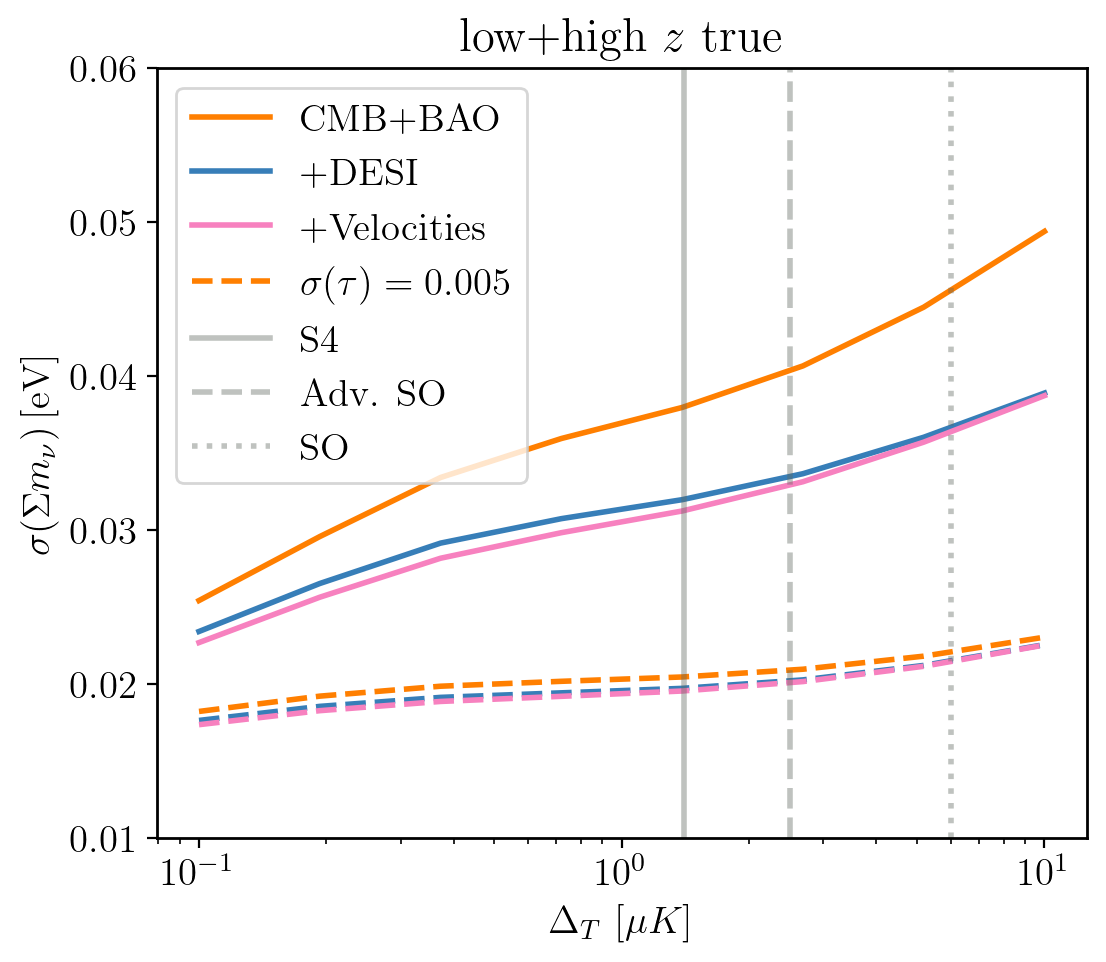

In [115]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_pr_DESI = np.zeros(len(Delta_Ts))

bias_list = ['bg', 'brsd', 'b_par', 'b_perp', 'b2']
fixed_params = ['brsd', 'b_par', 'b_perp']

bpar_pr = 1000.005

for t in range(len(Delta_Ts)):
    F_vX = F_vX_t_DESI[t]
    F_XX = F_XX_t_DESI[t]
    
    F_CMB_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_CMB_L2 = np.zeros((len(F_vX), len(F_vX)))
    #F_S4_t = data['fisherNonGaussian_delensed'][t]*fsky
    F_S4_t = F_CMB_DT['fisherGaussian'][t]['lensed']*fsky
    F_S4_t = np.delete(F_S4_t, -1, axis=0)
    F_S4_t = np.delete(F_S4_t, -1, axis=1)
    F_CMB_L1[:7,:7] = F_S4_t
    F_CMB_L2[:7,:7] = F_S4_t
    F_bao_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_bao_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_bao_L1[:7,:7] = F_bao
    F_bao_L2[:7,:7] = F_bao
    F_planck_lowell_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_planck_lowell_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_planck_lowell_L1[:7,:7] = F_planck_lowell
    F_planck_lowell_L2[:7,:7] = F_planck_lowell
    F_bao_CMB_DT1 = F_CMB_L1 + F_bao_L1 + F_planck_lowell_L1
    F_bao_CMB_DT2 = F_CMB_L2 + F_bao_L2 + F_planck_lowell_L2
    cov, covp = covariance_mat(F_bao_CMB_DT2, free_params3, bias_list, {})
    sig_mnu_DT_DESI[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    cov, covp = covariance_mat(F_bao_CMB_DT2, free_params3, bias_list, {'tau':0.005})
    sig_mnu_DT_pr_DESI[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_DT1+F_XX, cov_params3, fixed_params+[], {})
    sig_mnu_gal_DT_DESI[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_DT2+F_vX, free_params3, [], {})
    sig_mnu_gal_vel_DT_DESI[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_DT1+F_XX, cov_params3, fixed_params+[], {'tau':0.005})
    sig_mnu_gal_DT_pr_DESI[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_DT2+F_vX, free_params3, [], {'tau':0.005})
    sig_mnu_gal_vel_DT_pr_DESI[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
                
        
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_DT_DESI, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_gal_DT_DESI, label='+DESI', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_DESI, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_DT_pr_DESI, label=r'$\sigma(\tau)=0.005$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr_DESI, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_pr_DESI, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], label = 'S4', alpha=0.4)
plt.axvline(x = 2.5, color = palette[4], label = 'Adv. SO', alpha=0.4, ls='--')
plt.axvline(x = 6., color = palette[4], label = 'SO', alpha=0.4, ls=':')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'low+high $z$ true')
plt.ylim(0.01,0.06)



## Seperate kSZ and ML

In [128]:
#%% Calculate the reconstructed noise N_vv
def Rec_noise2(Z, cosmo_params, k_large, mu_L, bg, ng, survey, Delta_T):
    if survey == 'VRO10':
        sigma_phot = lambda z: 0.03*(1+z)
    elif survey == 'DESI':
        sigma_phot = lambda z: 0*(1+z)
    else:
        raise KeyError(f"{survey} is not a valid galaxy survey for this code!")
    nkS = 300
    nz = 101
    nmu = len(mu_L)
    k_small = np.linspace(1,5,nkS) # Mpc^-1
    mu_S = -(k_large[np.newaxis,:,np.newaxis]*np.ones((nkS,nkL,nmu))/k_small[:,np.newaxis,np.newaxis]*np.ones((nkS,nkL,nmu))) * mu_L[np.newaxis,np.newaxis,:]*np.ones((nkS,nkL,nmu))
    Mh = np.logspace(8,15,200) # Msun
    zcosmo = np.linspace(0.,15.,nz)
    cosmo_1 = cosmo_params.copy()
    camb_pars = camb.set_params(**cosmo_1)
    camb_pars.set_matter_power(redshifts=list(zcosmo))
    cosmo = camb.get_results(camb_pars)
    H = lambda z: cosmo.hubble_parameter(z)/(cu.c.to(u.km/u.s)).value # 1/Mpc    
    a = lambda z: 1/(1+z)
    T_CMB = ((camb_pars.TCMB* u.K).to(u.uK)).value # muK
    chi_star = lambda z: cosmo.comoving_radial_distance(z) # Mpc
    ell = lambda z,kS: chi_star(z) * kS
    gal_profile = hod.Leauthaud12_HOD
    elec_profile = 'electron'
    b1=None # linear biases, we add from the outside 
    b2=None # linear biases, we add from the outside 
    m_integrand=False # if False, the output is Pk integrated in Mh, otherwise you get the integrand in dMh
    rsd=False # RSD, we add from the outside
    fog=False # FoG, we add from the outside
    hcos_ksmall = hm.HaloModel([Z],k_small,Mh,params=cosmo_params)
    hcos_ksmall.add_hod("g",family=gal_profile,ngal=ng+np.asarray([Z])*0.,corr="max")
    hcos_ksmall.add_battaglia_profile("electron",family="AGN",xmax=20,nxs=5000)
    pgg_1h_ksmall = hcos_ksmall.get_power_1halo(name='g', name2=None, m_integrand=m_integrand,fog=fog)[0] # Mpc^3
    pgg_2h_ksmall = hcos_ksmall.get_power_2halo(name='g',name2=None,b1_in=b1,b2_in=b2,m_integrand=m_integrand,rsd=rsd,fog=fog)[0] # Mpc^3
    pge_1h_ksmall = hcos_ksmall.get_power_1halo(name='g', name2 = elec_profile, m_integrand=m_integrand,fog=fog)[0] # Mpc^3
    pge_2h_ksmall = hcos_ksmall.get_power_2halo(name='g',name2=elec_profile,b1_in=b1,b2_in=b2,m_integrand=m_integrand,rsd=rsd,fog=fog)[0] # Mpc^3
    fgrowth = fgrowth_k(Z,k_small,cosmo_params)
    resize_ksmall = k_small[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_fgrowth = fgrowth[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_pgg = (pgg_1h_ksmall+pgg_2h_ksmall)[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_ell_ksmall = chi_star(Z) * k_small[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_pge = (pge_1h_ksmall+pge_2h_ksmall)[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    P_gg_ksmall = (1 + mu_S**2*resize_fgrowth/bg)**2 * (resize_pgg) # Mpc^3
    W_phot_ksmall = np.exp(-mu_S**2*resize_ksmall**2*sigma_phot(Z)**2/2/H(Z)**2)
    P_gg_obs_ksmall = W_phot_ksmall**2 * P_gg_ksmall + 1/ng # Mpc^3
    P_ge_ksmall = W_phot_ksmall*(1 + mu_S**2*resize_fgrowth/bg) * (resize_pge) 
#     TT_total_for_S4 = np.loadtxt('./tt_total_power_s4_new_12.txt') # From Selim
#     lvec = TT_total_for_S4[:,0]
#     Cl_TT = interp1d(lvec,TT_total_for_S4[:,1],bounds_error=False,fill_value=0.) # muK^2
#     Cltot_noise = Cl_TT(resize_ell_ksmall)
    s = Delta_T *u.arcmin.to(u.radian)
    fwhm = 1.4 *u.arcmin.to(u.radian) #1.4
    N_ell=CMB_noise(resize_ell_ksmall, s, fwhm)
    Cltot_noise=Cl_tot(resize_ell_ksmall)+N_ell
    # kSZ
    xe = 1 # ionization fraction
    gasfrac = 0.9 # fraction of baryons in gas form, use default
    Yp = camb_pars.YHe # primordial He abundance
    ne0 = ksz.ne0_shaw(ombh2=cosmo_params['ombh2'],gasfrac=gasfrac,Yp=Yp) # m^-3 # mean free electron density at z = 0
    Kstar = lambda z: -ksz.ksz_radial_function(z, camb_pars.ombh2, Yp) # muK / Mpc
    itgrnd = resize_ksmall * (P_ge_ksmall**2 / P_gg_obs_ksmall) / Cltot_noise # Mpc^-1 muK^-2
    mask = np.isinf(itgrnd)
    itgrnd[mask] = 0.
    integral = np.trapz(itgrnd, x=k_small, axis=0) # Mpc / muK^2
    Nvv_par = (chi_star(Z)/ Kstar(Z))**2 * 2*np.pi / integral # Mpc^3
    N_vv_kSZ = (mu_L[np.newaxis,:]*np.ones((nkL,nmu)))**-2 * Nvv_par
    
    T_CMB=2.7260 #K
    T_CMB_uK=T_CMB*1e6 #uK
    # get potential Pk (non linearities included) - CAMB results is already multiplied by k^4
    interp_Pphiphi = camb.get_matter_power_interpolator(camb_pars, zmin=0, zmax=zcosmo[-1], nz_step=150, zs=None, kmax=max(k_small), nonlinear=True,var1=camb.model.Transfer_Weyl, var2=camb.model.Transfer_Weyl, hubble_units=False, 
                                                        k_hunit=False, return_z_k=False, k_per_logint=None, log_interp=False,  extrap_kmax=True).P  # Mpc^3
    omegam = (camb_pars.ombh2 + camb_pars.omch2 + camb_pars.omnuh2) / (camb_pars.H0 / 100) ** 2
    rhoM0 = 3*omegam*H(0.)**2 # Mpc^-2
    # potential Pk , change of units
    use_Pphiphi_ksmall = (interp_Pphiphi(use_z,k_small)/k_small**4)[:,np.newaxis,np.newaxis]*np.ones((nkS,nkL,nmu)) # Mpc^3
    noise_pot = ((1+use_z)*rhoM0/2)**2/((resize_ksmall)**4 * bg**2*ng * W_phot_ksmall**2)  # Mpc^3
    # observed potential
    use_Ppot_ob = use_Pphiphi_ksmall + noise_pot # Mpc^3
    itgrnd_ML = (resize_ksmall)**3 * (use_Pphiphi_ksmall**2 / use_Ppot_ob) / Cltot_noise # muK^-2
    mask = np.isinf(itgrnd_ML)
    itgrnd_ML[mask] = 0
    integral_ML = np.trapz(itgrnd_ML, x=k_small, axis=0) # 1 / Mpc / muK^2
    new_resize_muL = mu_L[np.newaxis,:]*np.ones((nkL,nmu))
    new_resize_kL = k_large[:,np.newaxis]*np.ones((nkL,nmu))
    # noise on the transverse velocity potential (T_CMB factor to cancel the uK units from Cls)
    N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
    Nvv_perp = (new_resize_kL)**2 * N_perp_Vpot # v = grad pot so in Fourier you get v = k*pot
    N_vv_ML = (np.sqrt(1-new_resize_muL**2))**-2 * Nvv_perp # Mpc^3

    return N_vv_kSZ, N_vv_ML
    
    

#%% Calculate power spectra
def get_powers2(Z, cosmo_params, bias_params, k_large, mu, survey):
    nmu = len(mu)
    nkL = len(k_large)
    nz = 101
    zcosmo = np.linspace(0.,15.,nz)
    cosmo_1 = cosmo_params.copy()
    camb_pars = camb.set_params(**cosmo_1)
    camb_pars.set_matter_power(redshifts=list(zcosmo))
    cosmo = camb.get_results(camb_pars)
    H = lambda z: cosmo.hubble_parameter(z)/(cu.c.to(u.km/u.s)).value # 1/Mpc
    fgrowth = fgrowth_k(Z,k_large,cosmo_params)
    resize_klarge = k_large[:,np.newaxis]*np.ones((nkL,nmu))
    resize_fgrowth = fgrowth[:,np.newaxis]*np.ones((nkL,nmu))
    resize_mu = mu[np.newaxis,:]*np.ones((nkL,nmu))
    resize_Pmm = Pmm_k(k_large, Z, cosmo_params)[:,np.newaxis]*np.ones((nkL,nmu))
    RSD = bias_params['brsd']*resize_fgrowth*resize_mu**2
    
    if survey == 'VRO10':
        bg1 = bias_params['m']*Z+bias_params['q']
    elif survey == 'DESI':
        bg1 = bias_params['bg']
    #bg2 = bias_params['bg']+bias_params['b2']*resize_klarge**2 # in case of DESI
    bg2 = bg1+bias_params['b2']*resize_klarge**2 # in case of VRO10

    a = lambda z: 1/(1+z)
    b_v = resize_fgrowth * a(Z) * H(Z) / resize_klarge
    bv = bias_params['bv'] * b_v
    
    Pgg = (bg2 + RSD)**2 * resize_Pmm
    Pvv = bv**2 * resize_Pmm
    Pgv = bv * (bg2 + RSD) * resize_Pmm
    
    return Pgg, Pgv, Pvv



#%% Calculate noise power spectra
def get_noises2(Z, cosmo_params, k_large, mu_L, bg, ng, survey, Delta_T):
    nmu = len(mu_L)
    nkL = len(k_large)
    if survey == 'VRO10':
        sigma_phot = lambda z: 0.03*(1+z)
    elif survey == 'DESI':
        sigma_phot = lambda z: 0*(1+z)
    else:
        raise KeyError(f"{survey} is not a valid galaxy survey for this code!")
    nz = 101
    zcosmo = np.linspace(0.,15.,nz)
    cosmo_1 = cosmo_params.copy()
    camb_pars = camb.set_params(**cosmo_1)
    camb_pars.set_matter_power(redshifts=list(zcosmo))
    cosmo = camb.get_results(camb_pars)
    H = lambda z: cosmo.hubble_parameter(z)/(cu.c.to(u.km/u.s)).value # 1/Mpc
    a = lambda z: 1/(1+z)
    #fgrowth = fgrowth_k(k_large,Z,cosmo_params)
    
    resize_muL = mu_L[np.newaxis,:]*np.ones((nkL,nmu))
    resize_klarge = k_large[:,np.newaxis]*np.ones((nkL,nmu))
    W_phot_klarge = np.exp(-resize_muL**2*resize_klarge**2*sigma_phot(Z)**2/2/H(Z)**2)
    Ngg = 1/ W_phot_klarge**2 / ng
    
    Nvv_kSZ, Nvv_ML = Rec_noise2(Z, cosmo_params, k_large, mu_L, bg, ng, survey, Delta_T)
    
    return Ngg, Nvv_kSZ, Nvv_ML



#%% Calculate derivatives of power spectra
def derivs2(Z, cosmo0, bias0, free_params, deltas, k, mu, survey):
    nmu = len(mu)
    nk = len(k)
    #bv = M.bv
    d_Pgg = np.zeros((len(free_params), nk, nmu))
    d_Pgv = np.zeros((len(free_params), nk, nmu))
    d_Pvv = np.zeros((len(free_params), nk, nmu))
    param_values = np.zeros(len(free_params))
    for free_param_ind, free_param in enumerate(free_params):
        if free_param in cosmo0:
            param_values[free_param_ind] = cosmo0[free_param]
        elif free_param in bias0:
            param_values[free_param_ind] = bias0[free_param]
        else:
            raise KeyError(f"{free_param} is not a valid parameters for this code!")
            
    for i, param in enumerate(free_params):
        delta = deltas[i]
        param_value = param_values[i]
        if param in cosmo0:
            cosmo_p = cosmo0.copy()
            cosmo_n = cosmo0.copy()
            if not cosmo0[param] == 0.:
                cosmo_p[param] = cosmo0[param]*(1.+delta)
                cosmo_n[param] = cosmo0[param]*(1.-delta)
            else:
                cosmo_p[param] = delta
                cosmo_n[param] = -delta
            print('\n\nNow simulating for (1+delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            Pgg_p, Pgv_p, Pvv_p = get_powers2(Z, cosmo_p, bias0, k_large, mu_L, survey)
            print('\n\nNow simulating for (1-delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            Pgg_n, Pgv_n, Pvv_n = get_powers2(Z, cosmo_n, bias0, k_large, mu_L, survey)
        else:
            bias_p = bias0.copy()
            bias_n = bias0.copy()
            if not bias0[param] == 0.:
                bias_p[param] = bias0[param]*(1.+delta)
                bias_n[param] = bias0[param]*(1.-delta)
            else:
                bias_p[param] = delta
                bias_n[param] = -delta
            print('\n\nNow simulating for (1+delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            Pgg_p, Pgv_p, Pvv_p = get_powers2(Z, cosmo0, bias_p, k_large, mu_L, survey)
            print('\n\nNow simulating for (1-delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            Pgg_n, Pgv_n, Pvv_n = get_powers2(Z, cosmo0, bias_n, k_large, mu_L, survey)
        if not param_value == 0.:
            d_Pgg[i] = (Pgg_p - Pgg_n)/(2*param_value*delta)
            d_Pgv[i] = (Pgv_p - Pgv_n)/(2*param_value*delta)
            d_Pvv[i] = (Pvv_p - Pvv_n)/(2*param_value*delta)
        else:
            d_Pgg[i] = (Pgg_p - Pgg_n)/(2*delta)
            d_Pgv[i] = (Pgv_p - Pgv_n)/(2*delta)
            d_Pvv[i] = (Pvv_p - Pvv_n)/(2*delta)
    return d_Pgg, d_Pgv, d_Pvv
    
    
    
def Fisher_mat2(Z, cosmo0, bias0, free_params, deltas, k, mu, ng, survey, Delta_T, vol):
    k_grid=np.meshgrid(mu, k)[1]
    if survey == 'VRO10':
        bg = bias0['m']*Z+bias0['q']
    elif survey == 'DESI':
        bg = bias0['bg']
    else:
        raise KeyError(f"{survey} is not a valid galaxy survey for this code!")
    Pgg, Pgv, Pvv = get_powers2(Z, cosmo0, bias0, k, mu, survey)
    Ngg, Nvv_kSZ, Nvv_ML = get_noises2(Z, cosmo0, k, mu, bg, ng, survey, Delta_T)
    d_Pgg, d_Pgv, d_Pvv = derivs2(Z, cosmo0, bias0, free_params, deltas, k, mu, survey)
    S=np.zeros((len(k),len(mu),2,2))
    S[:,:,0,0]=Pvv; S[:,:,0,1]=Pgv; S[:,:,1,0]=Pgv; S[:,:,1,1]=Pgg;
    N_kSZ=np.zeros((len(k),len(mu),2,2))
    N_kSZ[:,:,0,0]=Nvv_kSZ; N_kSZ[:,:,1,1]=Ngg;
    N_ML=np.zeros((len(k),len(mu),2,2))
    N_ML[:,:,0,0]=Nvv_ML; N_ML[:,:,1,1]=Ngg;
    C_kSZ = S+N_kSZ
    C_ML = S+N_ML
    C_inv_kSZ = np.linalg.inv(C_kSZ)
    C_inv_ML = np.linalg.inv(C_ML)
    F_gg=np.zeros((len(free_params), len(free_params)))
    F_gv_kSZ=np.zeros((len(free_params), len(free_params)))
    F_gv_ML=np.zeros((len(free_params), len(free_params)))
    F_vv_kSZ=np.zeros((len(free_params), len(free_params)))
    F_vv_ML=np.zeros((len(free_params), len(free_params)))
    for a in range(len(free_params)):
        d_Pgg_a=d_Pgg[a,:,:]; d_Pgv_a=d_Pgv[a,:,:]; d_Pvv_a=d_Pvv[a,:,:];
        for b in range(len(free_params)):
            d_Pgg_b=d_Pgg[b,:,:]; d_Pgv_b=d_Pgv[b,:,:]; d_Pvv_b=d_Pvv[b,:,:];
            dC_a=np.zeros((len(k),len(mu),2,2))
            dC_a[:,:,0,0]=d_Pvv_a; dC_a[:,:,0,1]=d_Pgv_a; dC_a[:,:,1,0]=d_Pgv_a; dC_a[:,:,1,1]=d_Pgg_a;
            dC_b=np.zeros((len(k),len(mu),2,2))
            dC_b[:,:,0,0]=d_Pvv_b; dC_b[:,:,0,1]=d_Pgv_b; dC_b[:,:,1,0]=d_Pgv_b; dC_b[:,:,1,1]=d_Pgg_b;
    
               
            int_F_gv_kSZ=vol.value*((k_grid**2)/(8.*(np.pi**2)))*(np.trace(np.matmul(dC_a, np.matmul(C_inv_kSZ, np.matmul(dC_b, C_inv_kSZ))), axis1=2, axis2=3))
            F_gv_kSZ[a,b]=integrate.simps(integrate.simps(int_F_gv_kSZ, mu, axis=1), k)
            F_gv_kSZ[b,a]=F_gv_kSZ[a,b]
            
            int_F_gv_ML=vol.value*((k_grid**2)/(8.*(np.pi**2)))*(np.trace(np.matmul(dC_a, np.matmul(C_inv_ML, np.matmul(dC_b, C_inv_ML))), axis1=2, axis2=3))
            F_gv_ML[a,b]=integrate.simps(integrate.simps(int_F_gv_ML, mu, axis=1), k)
            F_gv_ML[b,a]=F_gv_ML[a,b]
            
            int_F_gg=vol.value*((k_grid**2)/(8.*(np.pi**2)))*(d_Pgg_a*d_Pgg_b)*((1./(Pgg+Ngg))**2)
            F_gg[a,b]=integrate.simps(integrate.simps(int_F_gg, mu, axis=1), k)
            F_gg[b,a]=F_gg[a,b]
            
            int_F_vv_kSZ=vol.value*((k_grid**2)/(8.*(np.pi**2)))*(d_Pvv_a*d_Pvv_b)*((1./(Pvv+Nvv_kSZ))**2)
            F_vv_kSZ[a,b]=integrate.simps(integrate.simps(int_F_vv_kSZ, mu, axis=1), k)
            F_vv_kSZ[b,a]=F_vv_kSZ[a,b]
            
            int_F_vv_ML=vol.value*((k_grid**2)/(8.*(np.pi**2)))*(d_Pvv_a*d_Pvv_b)*((1./(Pvv+Nvv_ML))**2)
            F_vv_ML[a,b]=integrate.simps(integrate.simps(int_F_vv_ML, mu, axis=1), k)
            F_vv_ML[b,a]=F_vv_ML[a,b]
            
    
    return F_gg, F_gv_kSZ, F_gv_ML, F_vv_kSZ, F_vv_ML


In [116]:
bias_params

{'m': 0.7,
 'q': 0.9,
 'brsd': 1.0,
 'b_par': 1.0,
 'b_perp': 1.0,
 'b2': 0.0,
 'bv': 1.0,
 'bg': 1.5}

In [275]:

deltas = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 3e-1, 3e-1, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
survey = 'VRO10'
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'm', 'q', 'brsd', 'b2', 'bv']
fixed_params=['bv']
fix_biases=['m', 'q', 'brsd', 'b2']

xx,vx_ksz,vx_ml,vv_ksz,vv_ml = Fisher_mat2(use_z, cosmo_params, bias_params, free_params, deltas, k_large, mu_L, nsources_VRO10, survey, Delta_T_S4, vol_VRO10)


Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  15  iterations.


/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_80785/1540730000.py:89: RuntimeWarning: divide by zero encountered in divide
  N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_80785/1540730000.py:91: RuntimeWarning: divide by zero encountered in power
  N_vv_ML = (np.sqrt(1-new_resize_muL**2))**-2 * Nvv_perp # Mpc^3




Now simulating for (1+delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt

In [276]:
print('\n Galaxies:')
covmat_xx, cov_params = covariance_mat(xx, free_params, fixed_params, {})
print_1_sigmas(covmat_xx,cov_params)
print('\n Galaxies+kSZ:')
covmat_vx_ksz, cov_params = covariance_mat(vx_ksz, free_params, [], {})
print_1_sigmas(covmat_vx_ksz,cov_params)
print('\n Galaxies+ML:')
covmat_vx_ml, cov_params = covariance_mat(vx_ml, free_params, [], {})
print_1_sigmas(covmat_vx_ml,cov_params)
print('\n Velocity kSZ:')
covmat_vv_ksz, cov_params = covariance_mat(vv_ksz, free_params, fix_biases, {})
print_1_sigmas(covmat_vv_ksz,cov_params)
print('\n Velocity ML:')
covmat_vv_ml, cov_params = covariance_mat(vv_ml, free_params, fix_biases, {})
print_1_sigmas(covmat_vv_ml,cov_params)



 Galaxies:


1-sigma of H0 is 568.527934411705
1-sigma of ombh2 is 0.0005120858740547665
1-sigma of omch2 is 0.0024509255620374214
1-sigma of ns is 0.037883488186372716
1-sigma of As is nan
1-sigma of tau is 498.1741171413577
1-sigma of mnu is 0.9004912263129725
1-sigma of m is 53518.11766484485
1-sigma of q is 93820.02788237447
1-sigma of brsd is nan
1-sigma of b2 is nan

 Galaxies+kSZ:


1-sigma of H0 is 565.0536968139332
1-sigma of ombh2 is 0.0005083096972091758
1-sigma of omch2 is 0.002417965746999196
1-sigma of ns is 0.03418620736252089
1-sigma of As is 0.00019224633603539556
1-sigma of tau is 497.7896308847746
1-sigma of mnu is 0.8611693596279039
1-sigma of m is nan
1-sigma of q is nan
1-sigma of brsd is 43692.34928589433
1-sigma of b2 is 3495387.929068004
1-sigma of bv is 43692.34912100604

 Galaxies+ML:


1-sigma of H0 is 568.1162132592501
1-sigma of ombh2 is 0.0005116381132504759
1-sigma of omch2 is 0.0024468289357226264
1-sigma of ns is 0.037518782669351054
1-sigma of As is 

/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_80785/1405122994.py:355: RuntimeWarning: invalid value encountered in sqrt
  sigmas[param] = np.sqrt(cov_mat[ind,ind])


With redshfit binning

In [129]:
deltas = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 3e-1, 3e-1, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]

survey = 'VRO10'
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'm', 'q', 'brsd', 'b2', 'bv']
fixed_params=['bv']
fix_biases=['m', 'q', 'brsd', 'b2']


zs = np.array([0.2,0.7,1.3,1.9,2.6])
bgs = np.array([1.05,1.37,1.79,2.22,2.74])
ngs = np.array([5e-2,2e-2,6e-3,15e-4,3e-4])
vs = (np.array([5.2,43.6,75.9,89.3,119.9])*u.Gpc**3).to(u.Mpc**3)
bias1 = bias_params.copy()

Fz_XX=np.zeros((len(zs),len(free_params),len(free_params)))
Fz_vX_kSZ=np.zeros((len(zs),len(free_params),len(free_params)))
Fz_vX_ML=np.zeros((len(zs),len(free_params),len(free_params)))
Fz_vv_kSZ=np.zeros((len(zs),len(free_params),len(free_params)))
Fz_vv_ML=np.zeros((len(zs),len(free_params),len(free_params)))
for i in range(len(zs)):
    
    xx,vx_ksz,vx_ml,vv_ksz,vv_ml = Fisher_mat2(zs[i], cosmo_params, bias_params, free_params, deltas, k_large, mu_L, ngs[i], survey, Delta_T_S4, vs[i])
    Fz_XX[i,:,:]=xx
    Fz_vX_kSZ[i,:,:]=vx_ksz
    Fz_vX_ML[i,:,:]=vx_ml
    Fz_vv_kSZ[i,:,:]=vv_ksz
    Fz_vv_ML[i,:,:]=vv_ml


Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  15  iterations.
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_67845/1808638655.py:89: RuntimeWarning: divide by zero encountered in divide
  N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_67845/1808638655.py:91: RuntimeWarning: divide by zero encountered in power
  N_vv_ML = (np.sqrt(1-new_resize_muL**2))**-2 * Nvv_perp # Mpc^3




Now simulating for (1+delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


N

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, this is parameter #8 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


N

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this is parameter #9 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


N

In [130]:
F_vX_kSZ = np.sum(Fz_vX_kSZ, axis=0)
F_vX_ML = np.sum(Fz_vX_ML, axis=0)
F_XX = np.sum(Fz_XX, axis=0)
F_vv_kSZ = np.sum(Fz_vv_kSZ, axis=0)
F_vv_ML = np.sum(Fz_vv_ML, axis=0)


print('\n Galaxies:')
covmat_xx, cov_params = covariance_mat(F_XX, free_params, fixed_params+['brsd'], {})
print_1_sigmas(covmat_xx,cov_params)
print('\n Galaxies+kSZ:')
covmat_vx_ksz, cov_params = covariance_mat(F_vX_kSZ, free_params, ['brsd'], {})
print_1_sigmas(covmat_vx_ksz,cov_params)
print('\n Galaxies+ML:')
covmat_vx_ml, cov_params = covariance_mat(F_vX_ML, free_params, ['brsd'], {})
print_1_sigmas(covmat_vx_ml,cov_params)
print('\n Velocity kSZ:')
covmat_vv_ksz, cov_params = covariance_mat(F_vv_kSZ, free_params, fix_biases+['brsd'], {})
print_1_sigmas(covmat_vv_ksz,cov_params)
print('\n Velocity ML:')
covmat_vv_ml, cov_params = covariance_mat(F_vv_ML, free_params, fix_biases+['brsd'], {})
print_1_sigmas(covmat_vv_ml,cov_params)



 Galaxies:


1-sigma of H0 is 281.53546579734245
1-sigma of ombh2 is 0.00024295891981701166
1-sigma of omch2 is 0.0011437452545669162
1-sigma of ns is 0.02678558057419526
1-sigma of As is 8.555581600046347e-09
1-sigma of tau is 66.19388956295013
1-sigma of mnu is 0.185807526205222
1-sigma of m is nan
1-sigma of q is nan
1-sigma of b2 is 1.4320987304973034

 Galaxies+kSZ:


1-sigma of H0 is 183.61763268707227
1-sigma of ombh2 is 0.00023587852861586838
1-sigma of omch2 is 0.0010935116267492286
1-sigma of ns is 0.021906507566870514
1-sigma of As is 5.545020547522504e-09
1-sigma of tau is 6.98814696375606
1-sigma of mnu is 0.14210026837453668
1-sigma of m is nan
1-sigma of q is nan
1-sigma of b2 is 1.1898064783919295
1-sigma of bv is 0.8530930463828237

 Galaxies+ML:


1-sigma of H0 is 279.30911509531137
1-sigma of ombh2 is 0.00024026854020562475
1-sigma of omch2 is 0.0011316942459567029
1-sigma of ns is 0.026635109102041817
1-sigma of As is 8.473591943227568e-09
1-sigma of tau is 51.3069

/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_67845/2647675735.py:420: RuntimeWarning: invalid value encountered in sqrt
  sigmas[param] = np.sqrt(cov_mat[ind,ind])


In [138]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_ksz_DT2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_ml_DT2 = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_ksz_DT_pr2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_ml_DT_pr2 = np.zeros(len(Delta_Ts))

bias_list = ['m', 'q', 'brsd', 'bv', 'b2']

In [140]:

fsky=0.4

deltas = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 3e-1, 3e-1, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
survey = 'VRO10'
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'm', 'q', 'brsd', 'bv', 'b2']

F_XX_t = []
F_vX_kSZ_t = []
F_vX_ML_t = []

zs = np.array([0.2,0.7,1.3,1.9,2.6])
bgs = np.array([1.05,1.37,1.79,2.22,2.74])
ngs = np.array([5e-2,2e-2,6e-3,15e-4,3e-4])
vs = (np.array([5.2,43.6,75.9,89.3,119.9])*u.Gpc**3).to(u.Mpc**3)

for t in range(len(Delta_Ts)):
    
    Fz_XX=np.zeros((len(zs),len(free_params),len(free_params)))
    Fz_vX_kSZ=np.zeros((len(zs),len(free_params),len(free_params)))
    Fz_vX_ML=np.zeros((len(zs),len(free_params),len(free_params)))
    for i in range(len(zs)):
        xx,vx_ksz,vx_ml,_,_ = Fisher_mat2(zs[i], cosmo_params, bias_params, free_params, deltas, k_large, mu_L, ngs[i], survey, Delta_Ts[t], vs[i])
        Fz_XX[i,:,:]=xx
        Fz_vX_kSZ[i,:,:]=vx_ksz
        Fz_vX_ML[i,:,:]=vx_ml
        
    F_vX_kSZ_t.append(np.sum(Fz_vX_kSZ, axis=0))
    F_vX_ML_t.append(np.sum(Fz_vX_ML, axis=0))
    F_XX_t.append(np.sum(Fz_XX, axis=0))


Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  13  iterations.


/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_1261/1540730000.py:89: RuntimeWarning: divide by zero encountered in divide
  N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_1261/1540730000.py:91: RuntimeWarning: divide by zero encountered in power
  N_vv_ML = (np.sqrt(1-new_resize_muL**2))**-2 * Nvv_perp # Mpc^3




Now simulating for (1+delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)q, this is parameter #9 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv, this is parameter #11 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv, this is parameter #11 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #12 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #12 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest



Now simulating for (1+delta)As, this is parameter #5 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, this is parameter #8 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this is parameter #8 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this 

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  15  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest fi



Now simulating for (1+delta)q, this is parameter #9 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv, this is parameter #11 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv, this is parameter #11 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #12 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #12 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sor



Now simulating for (1-delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, this is parameter #8 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  14  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of



Now simulating for (1-delta)m, this is parameter #8 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this is parameter #9 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv, this is parameter #11 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv, this is parameter #11 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #12 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, 



Now simulating for (1+delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, thi



Now simulating for (1-delta)b2, this is parameter #12 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  17  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out o



Now simulating for (1+delta)m, this is parameter #8 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this is parameter #8 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this is parameter #9 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv, this is parameter #11 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv, this is parameter #11 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, th



Now simulating for (1-delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu,



Now simulating for (1+delta)b2, this is parameter #12 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #12 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  16  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 



Now simulating for (1-delta)mnu, this is parameter #7 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, this is parameter #8 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this is parameter #8 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this is parameter #9 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv, this is parameter #11 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv, th



Now simulating for (1+delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mn



Now simulating for (1-delta)bv, this is parameter #11 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #12 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #12 (out of 12)
Note: redshifts have been re-sorted (earliest first)


(0.1, 0.4)

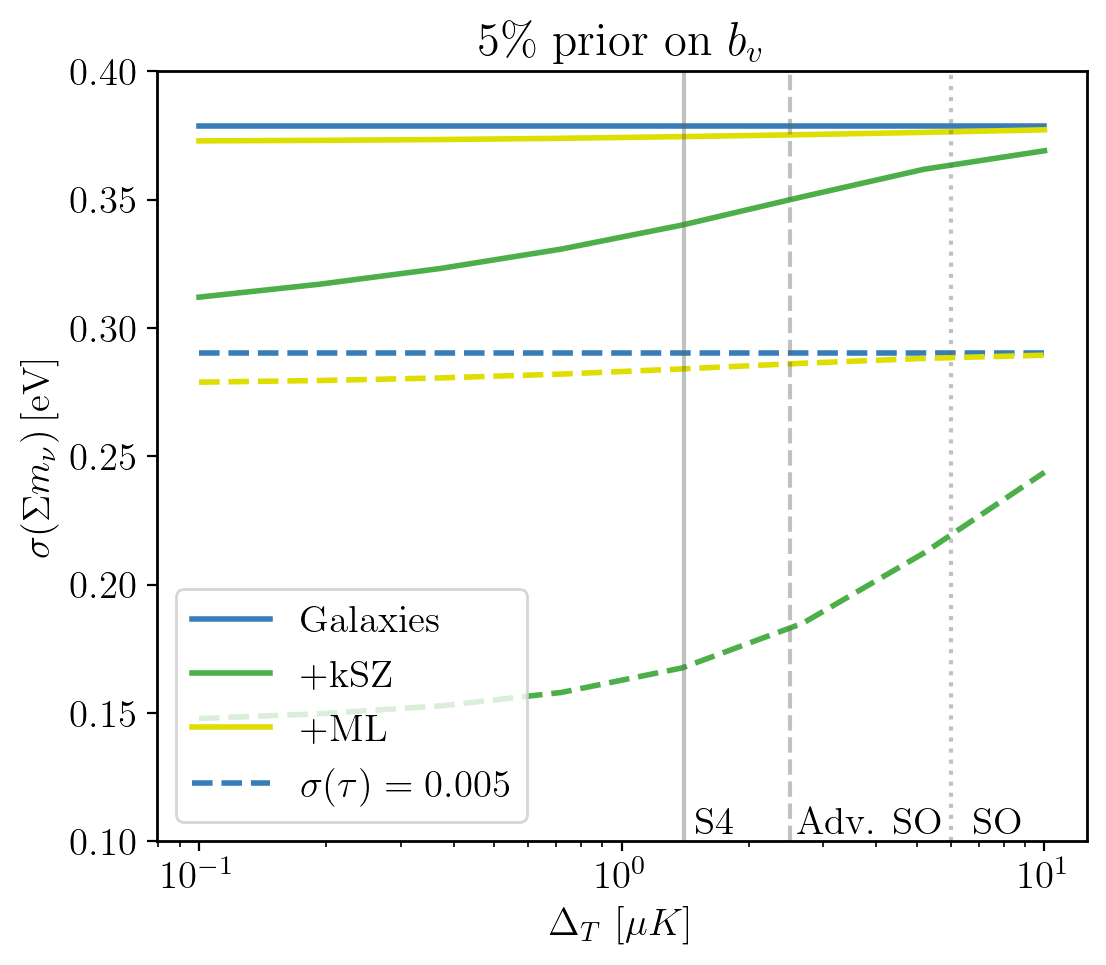

In [175]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_ksz_DT2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_ml_DT2 = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_ksz_DT_pr2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_ml_DT_pr2 = np.zeros(len(Delta_Ts))

bias_list = ['m', 'q', 'brsd', 'bv', 'b2']
fixed_params = ['bv']

for t in range(len(Delta_Ts)):
                
    F_vX_kSZ = F_vX_kSZ_t[t]
    F_vX_ML = F_vX_ML_t[t]
    F_XX = F_XX_t[t]
    
    covmat_gal, cov_params = covariance_mat(F_XX, free_params, fixed_params+['brsd'], {})
    sig_mnu_gal_DT2[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_ksz, cov_params = covariance_mat(F_vX_kSZ, free_params, ['brsd'], {'bv':0.05})
    sig_mnu_gal_ksz_DT2[t] = np.sqrt(covmat_gal_ksz[mnu_ind,mnu_ind])
    covmat_gal_ml, cov_params = covariance_mat(F_vX_ML, free_params, ['brsd'], {'bv':0.05})
    sig_mnu_gal_ml_DT2[t] = np.sqrt(covmat_gal_ml[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_XX, free_params, fixed_params+['brsd'], {'tau':0.005})
    sig_mnu_gal_DT_pr2[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_ksz, cov_params = covariance_mat(F_vX_kSZ, free_params, ['brsd'], {'tau':0.005,'bv':0.05})
    sig_mnu_gal_ksz_DT_pr2[t] = np.sqrt(covmat_gal_ksz[mnu_ind,mnu_ind])
    covmat_gal_ml, cov_params = covariance_mat(F_vX_ML, free_params, ['brsd'], {'tau':0.005,'bv':0.05})
    sig_mnu_gal_ml_DT_pr2[t] = np.sqrt(covmat_gal_ml[mnu_ind,mnu_ind])


#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_gal_DT2, label='Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_ksz_DT2, label='+kSZ', color=palette[7])
plt.plot(Delta_Ts, sig_mnu_gal_ml_DT2, label='+ML', color=palette[13])
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr2, label=r'$\sigma(\tau)=0.005$', color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_ksz_DT_pr2, color=palette[7], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_ml_DT_pr2, color=palette[13], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 0.1, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 0.1, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 0.1, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)

plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'5\% prior on $b_v$')
plt.ylim(0.1,0.4)




In [287]:

fixed_params = ['bv']

for t in range(len(Delta_Ts)):
    F_bao_CMB_L = np.zeros((len(free_params), len(free_params)))
    #F_S4_t = F_CMB_DT['fisherNonGaussian_delensed'][t]*fsky
    F_S4_t = F_CMB_DT['fisherGaussian'][t]['lensed']*fsky
    F_CMB_DT
    F_S4_t = np.delete(F_S4_t, -1, axis=0)
    F_S4_t = np.delete(F_S4_t, -1, axis=1)
    F_bao_CMB_L[:7,:7] = F_S4_t
    F_bao_L = np.zeros((len(free_params), len(free_params)))
    F_bao_L[:7,:7] = F_bao
    F_planck_lowell_L = np.zeros((len(free_params), len(free_params)))
    F_planck_lowell_L[:7,:7] = F_planck_lowell
    F_bao_CMB_DT = F_bao_CMB_L + F_bao_L + F_planck_lowell_L
    cov, covp = covariance_mat(F_bao_CMB_DT, free_params, bias_list, {})
    sig_mnu_DT2[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    cov, covp = covariance_mat(F_bao_CMB_DT, free_params, bias_list, {'tau':0.005})
    sig_mnu_DT_pr2[t] = np.sqrt(cov[mnu_ind,mnu_ind])
                
    F_vX_kSZ = F_vX_kSZ_t[t]
    F_vX_ML = F_vX_ML_t[t]
    F_XX = F_XX_t[t]
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_DT+F_XX, free_params, fixed_params+['brsd'], {})
    sig_mnu_gal_DT2[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_ksz, cov_params = covariance_mat(F_bao_CMB_DT+F_vX_kSZ, free_params, ['brsd'], {})
    sig_mnu_gal_ksz_DT2[t] = np.sqrt(covmat_gal_ksz[mnu_ind,mnu_ind])
    covmat_gal_ml, cov_params = covariance_mat(F_bao_CMB_DT+F_vX_ML, free_params, ['brsd'], {})
    sig_mnu_gal_ml_DT2[t] = np.sqrt(covmat_gal_ml[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_DT+F_XX, free_params, fixed_params+['brsd'], {'tau':0.005})
    sig_mnu_gal_DT_pr2[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_ksz, cov_params = covariance_mat(F_bao_CMB_DT+F_vX_kSZ, free_params, ['brsd'], {'tau':0.005})
    sig_mnu_gal_ksz_DT_pr2[t] = np.sqrt(covmat_gal_ksz[mnu_ind,mnu_ind])
    covmat_gal_ml, cov_params = covariance_mat(F_bao_CMB_DT+F_vX_ML, free_params, ['brsd'], {'tau':0.005})
    sig_mnu_gal_ml_DT_pr2[t] = np.sqrt(covmat_gal_ml[mnu_ind,mnu_ind])


(0.01, 0.06)

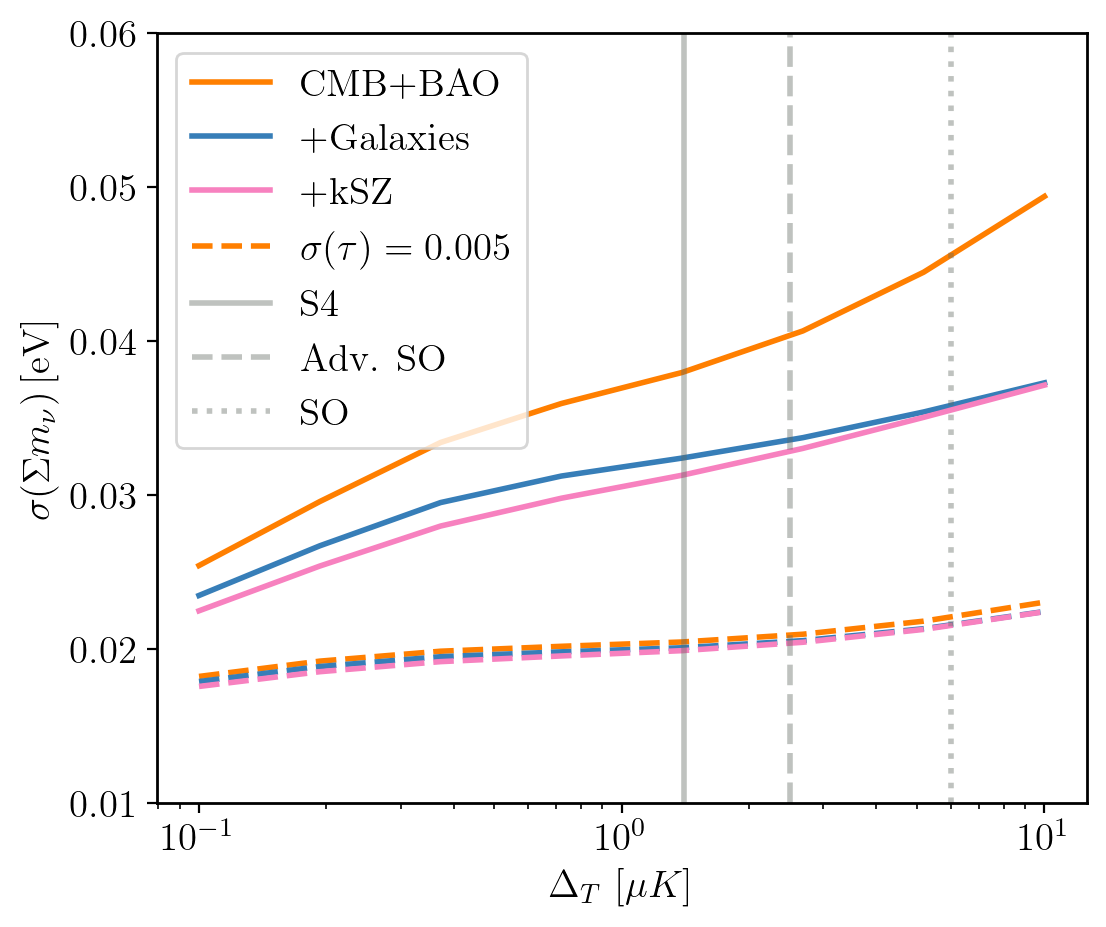

In [289]:
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_DT2, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_gal_DT2, label='+Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_ksz_DT2, label='+kSZ', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_DT_pr2, label=r'$\sigma(\tau)=0.005$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr2, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_ksz_DT_pr2, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], label = 'S4', alpha=0.4)
plt.axvline(x = 2.5, color = palette[4], label = 'Adv. SO', alpha=0.4, ls='--')
plt.axvline(x = 6., color = palette[4], label = 'SO', alpha=0.4, ls=':')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.ylim(0.01,0.06)



(0.01, 0.06)

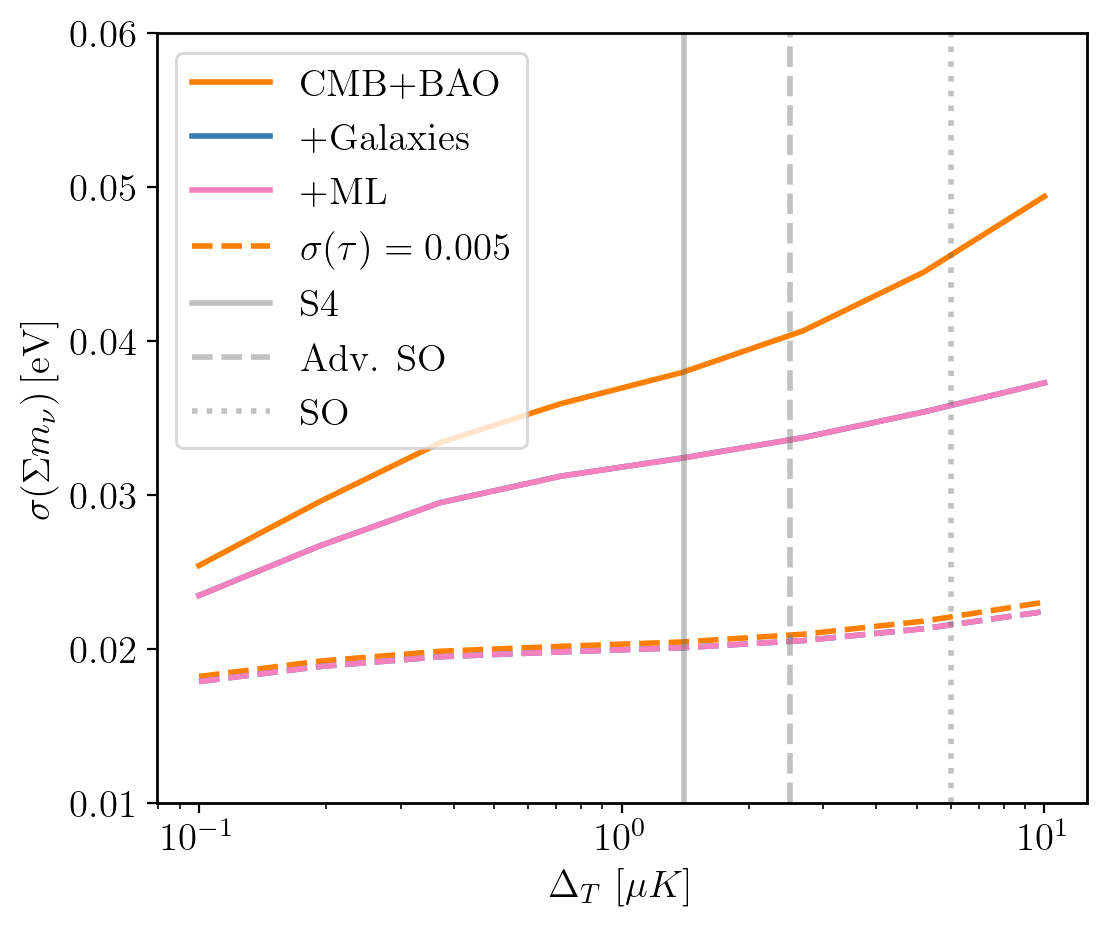

In [291]:
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_DT2, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_gal_DT2, label='+Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_ml_DT2, label='+ML', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_DT_pr2, label=r'$\sigma(\tau)=0.005$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr2, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_ml_DT_pr2, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], label = 'S4', alpha=0.4)
plt.axvline(x = 2.5, color = palette[4], label = 'Adv. SO', alpha=0.4, ls='--')
plt.axvline(x = 6., color = palette[4], label = 'SO', alpha=0.4, ls=':')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.ylim(0.01,0.06)


In [293]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_ksz_DT2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_ml_DT2 = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_ksz_DT_pr2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_ml_DT_pr2 = np.zeros(len(Delta_Ts))

bias_list = ['m', 'q', 'brsd', 'bv', 'b2']
fixed_params = ['bv']

for t in range(len(Delta_Ts)):
                
    F_vX_kSZ = F_vX_kSZ_t[t]
    F_vX_ML = F_vX_ML_t[t]
    F_XX = F_XX_t[t]
    
    covmat_gal, cov_params = covariance_mat(F_XX, free_params, fixed_params+['brsd'], {})
    sig_mnu_gal_DT2[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_ksz, cov_params = covariance_mat(F_vX_kSZ, free_params, ['brsd'], {'bv':0.01})
    sig_mnu_gal_ksz_DT2[t] = np.sqrt(covmat_gal_ksz[mnu_ind,mnu_ind])
    covmat_gal_ml, cov_params = covariance_mat(F_vX_ML, free_params, ['brsd'], {'bv':0.01})
    sig_mnu_gal_ml_DT2[t] = np.sqrt(covmat_gal_ml[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_XX, free_params, fixed_params+['brsd'], {'tau':0.005})
    sig_mnu_gal_DT_pr2[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_ksz, cov_params = covariance_mat(F_vX_kSZ, free_params, ['brsd'], {'tau':0.005,'bv':0.01})
    sig_mnu_gal_ksz_DT_pr2[t] = np.sqrt(covmat_gal_ksz[mnu_ind,mnu_ind])
    covmat_gal_ml, cov_params = covariance_mat(F_vX_ML, free_params, ['brsd'], {'tau':0.005,'bv':0.01})
    sig_mnu_gal_ml_DT_pr2[t] = np.sqrt(covmat_gal_ml[mnu_ind,mnu_ind])


(0.1, 0.4)

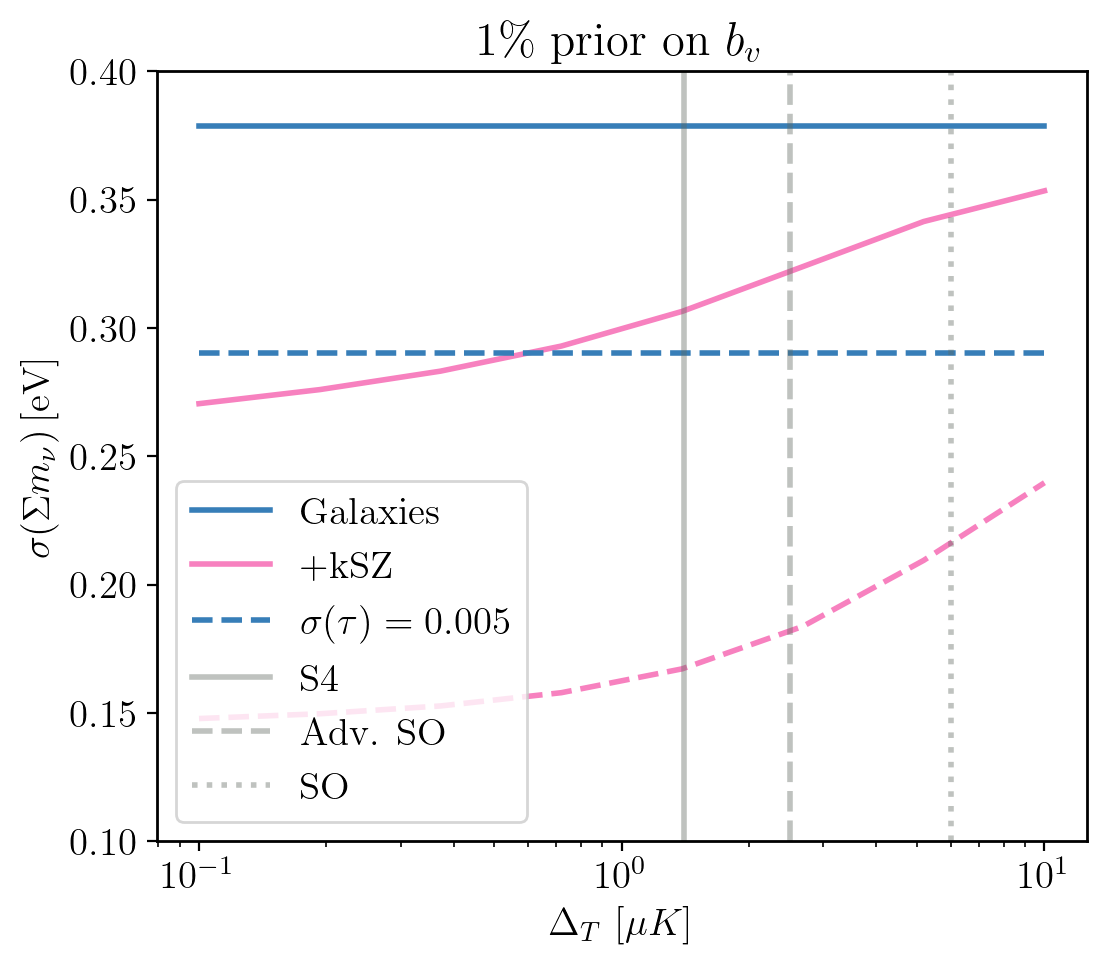

In [296]:
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_gal_DT2, label='Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_ksz_DT2, label='+kSZ', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr2, label=r'$\sigma(\tau)=0.005$', color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_ksz_DT_pr2, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], label = 'S4', alpha=0.4)
plt.axvline(x = 2.5, color = palette[4], label = 'Adv. SO', alpha=0.4, ls='--')
plt.axvline(x = 6., color = palette[4], label = 'SO', alpha=0.4, ls=':')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'1\% prior on $b_v$')
plt.ylim(0.1,0.4)




(0.1, 0.4)

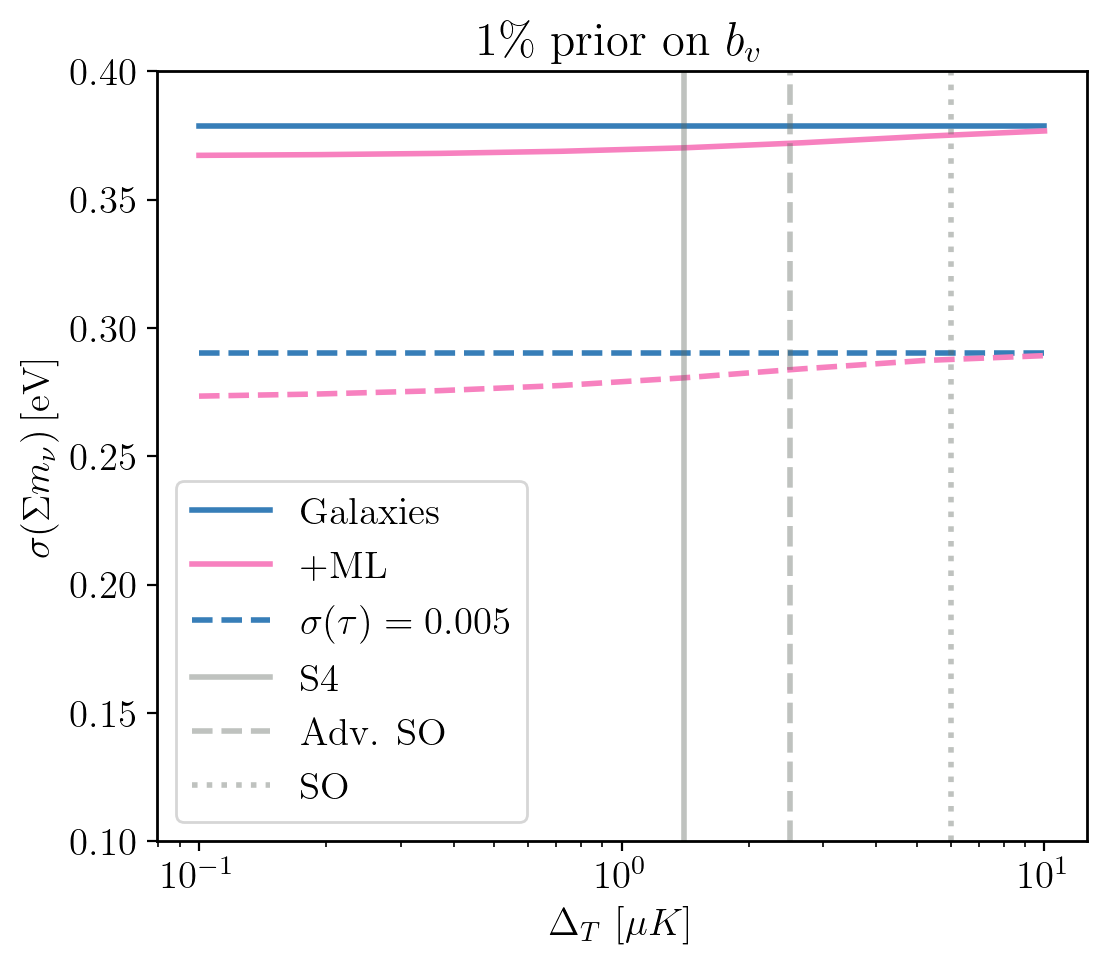

In [297]:
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_gal_DT2, label='Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_ml_DT2, label='+ML', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr2, label=r'$\sigma(\tau)=0.005$', color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_ml_DT_pr2, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], label = 'S4', alpha=0.4)
plt.axvline(x = 2.5, color = palette[4], label = 'Adv. SO', alpha=0.4, ls='--')
plt.axvline(x = 6., color = palette[4], label = 'SO', alpha=0.4, ls=':')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'1\% prior on $b_v$')
plt.ylim(0.1,0.4)


